In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import html5lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import time
from pandasql import sqldf


from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

import pickle

In [2]:
data = [[
[2010,41,'https://web.archive.org/web/20101111114925/http://www.forbes.com/lists/2010/10/billionaires-2010_The-Worlds-Billionaires_Rank.html',
'#nextPage > dl > dd:nth-child(11) > a'],
[2011,13,'https://web.archive.org/web/20110504020049/http://www.forbes.com/wealth/billionaires/list',
'html body#rlfulllist div#contentwrapper section#listcontent.contentrow.clearfix div#thelist.fright.complete nav.pagination.clearfix.backnext a.iconoverlay.next span.icon'],    
[2012,13,'https://web.archive.org/web/20120516224324/http://www.forbes.com/billionaires/list/',
'html.js.history.svg.inlinesvg body#fulllist div#contentwrapper section#listcontent.contentrow.clearfix div#thelist.fright nav#listPagination.pagination.backnext.clearfix a.iconoverlay.next span.icon'],    
[2013,13,'https://web.archive.org/web/20130127165310/http://www.forbes.com/billionaires/list/',
'#listPagination > a.iconoverlay.next'],
    
],
    
[    
[2014,np.nan,'https://web.archive.org/web/20140519182420/http://www.forbes.com/billionaires/list/'],
[2015,np.nan,'https://web.archive.org/web/20150525203821/http://www.forbes.com/billionaires/list/'],
[2016,np.nan,'https://web.archive.org/web/20160505035939/http://www.forbes.com/billionaires/list/'],
[2017,np.nan,'https://web.archive.org/web/20170525044503/https://www.forbes.com/billionaires/list/'],
[2018,np.nan,'https://web.archive.org/web/20180524012157/https://www.forbes.com/billionaires/list/'],
[2019,np.nan,'https://web.archive.org/web/20190304152923/https://www.forbes.com/billionaires/list/']
],
    
[
[2020,'https://web.archive.org/web/20200613164318/https://www.forbes.com/real-time-billionaires/#414088763d78'],
],
    
[
[2021,14,'https://web.archive.org/web/20210517125957/https://www.forbes.com/billionaires/',
 'html body div#___gatsby div#gatsby-focus-wrapper div.page-wrapper div.content-wrapper div.table-block div.table-block-wrapper div.table div.table-body div.table-row-group div.below-row-content div.pagination button.pagination-btn.pagination-btn--next div.next-page span.bubble-arrow__label'],
[2022,14,'https://web.archive.org/web/20220803060520/https://www.forbes.com/billionaires/',
 '#gatsby-focus-wrapper > div > div > div.table-block > div.table-block-wrapper > div.table > div.table-body > div:nth-child(27) > div.table-row-group__container > div.below-row-content > div.pagination > button.pagination-btn.pagination-btn--next > div > i']    
    
]
]

In [3]:
def get_pages_with_click_key(data,driver):
    

    
    print(data[0])
    
    driver.get(data[2])
    # driver.fullscreen_window()
        
    if data[0] == 2013:
        driver.execute_script("window.scrollTo(0,7000)")            

    page = {}
    
    time.sleep(5)
    
    page[0] = driver.page_source
    
    
    for i in range(1,data[1]):
        # driver.fullscreen_window()
        if data[0] == 2022:
            time.sleep(3)
        
        if data[0] == 2013:
            driver.execute_script("window.scrollTo(0,7000)")           
                
        if data[0] in [2010,2011]:
            driver.find_element(By.PARTIAL_LINK_TEXT,'Next').click()
        else:
            driver.find_element(By.CSS_SELECTOR,data[3]).click()

        time.sleep(8)
                
        page[i] = driver.page_source
                
    
    
    
    return page
    
    


In [4]:
def get_pages_with_scroll(data,driver,scroll_n):
    
    
    print(data[0])
        
    driver.get(data[2])
    
    d = webdriver.ActionChains(driver)


    for i in range(scroll_n):
        d.key_down(Keys.CONTROL)
        d.send_keys(Keys.END)
        d.perform()
        time.sleep(2)
            
    return {0:driver.page_source}

    
    
 

In [5]:
use_backup_data = True

In [6]:
if use_backup_data == True:
    with open('data/total_data.pkl','rb') as file:
        total_data = pickle.load(file)
    
else:
    options = webdriver.ChromeOptions()
    prefs = {"profile.managed_default_content_settings.images": 2}
    options.add_experimental_option("prefs", prefs)
    options.add_argument("--start-maximized")
    driver = webdriver.Chrome(options=options)
    
    
    driver.maximize_window()
    total_data = {}
    
    # 2010 - 2013
    
    
    for date_n in data[0]:
        total_data[date_n[0]] = get_pages_with_click_key(date_n,driver)
    
    
    
    # 2014 - 2019
    
    for date_n in data[1]:
        total_data[date_n[0]] = get_pages_with_scroll(date_n,driver,100)
    
    
    
    
    # 2020
    
    driver.get(data[2][0][1])
    x = webdriver.ActionChains(driver)

    for i in range(100):
        driver.find_element(By.CLASS_NAME,'scrolly-table').click()
        x.key_down(Keys.CONTROL)
        x.send_keys(Keys.END)
        x.perform()
        time.sleep(1.5)
        
    total_data[2020] = {0:driver.page_source}
    
    
    # 2021 - 2022
    
    for date_n in data[3]:
        total_data[date_n[0]] = get_pages_with_click_key(date_n,driver)
    
    
            
    
    with open('data/total_data.pkl','wb') as file:
        pickle.dump(total_data,file)

In [7]:
table_2010 = pd.DataFrame(columns=['rank','name','citizenship','age','net_worth','residence'])

for page in total_data[2010]:
    soup = BeautifulSoup(total_data[2010][page],'lxml')

    for i in soup.find_all('tr'):
        row = []
        try:
            col = i.find_all('td',{'class':'highlight'})
            row.append(str(col[0]).split('\n')[-2].split('\t')[-1])
            
            col = i.find_all('td',{'class':'rowcolor'})
            row.append(str(col[0]).split('</a></td>')[0].split('>')[-1])
            row.append(str(col[1]).split('\n')[-2].split('\t')[-1])
            row.append(str(col[2]).split('\n')[-2].split('\t')[-1])
            row.append(str(col[3]).split('\n')[-2].split('\t')[-1])
            row.append(str(col[4]).split('\n')[-2].split('\t')[-1])

            table_2010.loc[len(table_2010)] = row

        except:
            pass



In [8]:
table_2010.head()

rank                           name    citizenship age net_worth  \
0    1  Carlos Slim Helu &amp; family         Mexico  70      53.5   
1    2              William Gates III  United States  54      53.0   
2    3                 Warren Buffett  United States  79      47.0   
3    4                  Mukesh Ambani          India  52      29.0   
4    5                 Lakshmi Mittal          India  59      28.7   

        residence  
0          Mexico  
1   United States  
2   United States  
3           India  
4  United Kingdom

In [9]:
table_2011 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])

for page in total_data[2011]:
    soup = BeautifulSoup(total_data[2011][page],'lxml')

    for i in soup.find_all('tr'):
        row = []
        try:
            col = i.find_all('td')
            
            row.append(str(col[0]).split('</td>')[-2].split('>')[-1])
            row.append(str(col[1]).split('</h3>\n</td>')[-2].split('</a>')[-1])
            row.append(str(col[2]).split(' B')[-2].split('$')[-1])
            row.append(str(col[3]).split('</td>')[-2].split('<td>')[-1])
            row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
            row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])

            table_2011.loc[len(table_2011)] = row

        except:
            pass


In [10]:
table_2011.head()

rank                           name net_worth age              source  \
0    1  Carlos Slim Helu &amp; family        74  71             telecom   
1    2                    Bill Gates         56  55           Microsoft   
2    3                Warren Buffett         50  80  Berkshire Hathaway   
3    4               Bernard Arnault         41  62                LVMH   
4    5                 Larry Ellison       39.5  66              Oracle   

       citizenship  
0        Mexico     
1  United States    
2  United States    
3        France     
4  United States

In [11]:
table_2012 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])

for page in total_data[2012]:
    soup = BeautifulSoup(total_data[2012][page],'lxml')

    for i in soup.find_all('tr'):
        row = []
        try:
            col = i.find_all('td')
            
            row.append(str(col[0]).split('</td>')[-2].split('>')[-1])
            try:
                row.append(str(col[1]).split('</h3></td>')[-2].split('<h3>')[-1])
            except:
                row.append(str(col[1]).split('</h3> </td>')[-2].split('<h3>')[-1])
            row.append(str(col[2]).split(' B')[-2].split('$')[-1])
            row.append(str(col[3]).split('</td>')[-2].split('<td>')[-1])
            row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
            row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])

            table_2012.loc[len(table_2012)] = row

        except:
            pass


In [12]:
table_2012.head()

rank                           name net_worth age              source  \
0    1  Carlos Slim Helu &amp; family        69  72             telecom   
1    2                     Bill Gates        61  56           Microsoft   
2    3                 Warren Buffett        44  81  Berkshire Hathaway   
3    4                Bernard Arnault        41  63                LVMH   
4    5                 Amancio Ortega      37.5  75                Zara   

     citizenship  
0         Mexico  
1  United States  
2  United States  
3         France  
4          Spain

In [13]:
table_2013 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])

for page in total_data[2013]:
    soup = BeautifulSoup(total_data[2013][page],'lxml')

    for i in soup.find_all('tr'):
        row = []
        try:
            col = i.find_all('td')
            
            row.append(str(col[0]).split('</td>')[-2].split('>')[-1])
            try:
                row.append(str(col[1]).split('</h3></td>')[-2].split('<h3>')[-1])
            except:
                row.append(str(col[1]).split('</h3> </td>')[-2].split('<h3>')[-1])
            row.append(str(col[2]).split(' B')[-2].split('$')[-1])
            row.append(str(col[3]).split('</td>')[-2].split('<td>')[-1])
            row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
            row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])

            table_2013.loc[len(table_2013)] = row

        except:
            pass


In [14]:
table_2013.head()

rank                           name net_worth age              source  \
0    1  Carlos Slim Helu &amp; family        69  72             telecom   
1    2                     Bill Gates        61  57           Microsoft   
2    3                 Warren Buffett        44  82  Berkshire Hathaway   
3    4                Bernard Arnault        41  63                LVMH   
4    5                 Amancio Ortega      37.5  76                Zara   

     citizenship  
0         Mexico  
1  United States  
2  United States  
3         France  
4          Spain

In [15]:
table_2014 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2014][0],'lxml')

for i in soup.find_all('tr',{'class':'data'}):
    row = []
    try:
        col = i.find_all('td')
            
        row.append(str(col[1]).split('</td>')[-2].split('>')[-1].split('#')[1])
        try:
            row.append(str(col[2]).split('</a></td>')[-2].split('/">')[-1])
        except:
            row.append(str(col[2]).split('</a> </td>')[-2].split('/">')[-1])
        row.append(str(col[3]).split(' B')[-2].split('$')[-1])
        row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[6]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[7]).split('</td>')[-2].split('<td>')[-1])
            

        table_2014.loc[len(table_2014)] = row

    except:
        pass


In [16]:
table_2014.head()

rank              name net_worth age              source    citizenship
0   1         Bill Gates      76.0  62           Microsoft  United States
1   2   Carlos Slim Helu      72.0  77             telecom         Mexico
2   3     Amancio Ortega      64.0  81              retail          Spain
3   4     Warren Buffett      58.2  87  Berkshire Hathaway  United States
4   5      Larry Ellison      48.0  73              Oracle  United States

In [17]:
table_2015 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2015][0],'lxml')

for i in soup.find_all('tr',{'class':'data'}):
    row = []
    try:
        col = i.find_all('td')
            
        row.append(str(col[1]).split('</td>')[-2].split('>')[-1].split('#')[1])
        try:
            row.append(str(col[2]).split('</a></td>')[-2].split('">')[-1])
        except:
            row.append(str(col[2]).split('</a> </td>')[-2].split('">')[-1])
        
        row.append(str(col[3]).split(' B')[-2].split('$')[-1])
        row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[6]).split('</td>')[-2].split('<td>')[-1])
            

        table_2015.loc[len(table_2015)] = row

    except:
        pass


In [18]:
table_2015.head()

rank              name net_worth age              source    citizenship
0   1         Bill Gates      79.2  59           Microsoft  United States
1   2   Carlos Slim Helu      77.1  75             telecom         Mexico
2   3     Warren Buffett      72.7  84  Berkshire Hathaway  United States
3   4     Amancio Ortega      64.5  79                Zara          Spain
4   5      Larry Ellison      54.3  70              Oracle  United States

In [19]:
table_2016 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2016][0],'lxml')

for i in soup.find_all('tr',{'class':'data'}):
    row = []
    try:
        col = i.find_all('td')
            
        row.append(str(col[1]).split('</td>')[-2].split('>')[-1].split('#')[1])
        try:
            row.append(str(col[2]).split('</a></td>')[-2].split('">')[-1])
        except:
            row.append(str(col[2]).split('</a> </td>')[-2].split('">')[-1])
        
        row.append(str(col[3]).split(' B')[-2].split('$')[-1])
        row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[6]).split('</td>')[-2].split('<td>')[-1])
            

        table_2016.loc[len(table_2016)] = row

    except:
        pass


In [20]:
table_2016.head()

rank              name net_worth age              source    citizenship
0   1         Bill Gates        75  61           Microsoft  United States
1   2     Amancio Ortega        67  81                Zara          Spain
2   3     Warren Buffett      60.8  87  Berkshire Hathaway  United States
3   4   Carlos Slim Helu        50  77             telecom         Mexico
4   5         Jeff Bezos      45.2  53          Amazon.com  United States

In [21]:
table_2017 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2017][0],'lxml')

for i in soup.find_all('tr',{'class':'data'}):
    row = []
    try:
        col = i.find_all('td')
            
        row.append(str(col[1]).split('</td>')[-2].split('>')[-1].split('#')[1])
        try:
            row.append(str(col[2]).split('</a></td>')[-2].split('">')[-1])
        except:
            row.append(str(col[2]).split('</a> </td>')[-2].split('">')[-1])
        
        row.append(str(col[3]).split(' B')[-2].split('$')[-1])
        row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[6]).split('</td>')[-2].split('<td>')[-1])
            

        table_2017.loc[len(table_2017)] = row

    except:
        pass


In [22]:
table_2017.head()

rank             name net_worth age              source    citizenship
0   1        Bill Gates        86  61           Microsoft  United States
1   2    Warren Buffett      75.6  87  Berkshire Hathaway  United States
2   3        Jeff Bezos      72.8  53          Amazon.com  United States
3   4    Amancio Ortega      71.3  81                Zara          Spain
4   5   Mark Zuckerberg        56  33            Facebook  United States

In [23]:
table_2018 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2018][0],'lxml')

for i in soup.find_all('tr',{'class':'data'}):
    row = []
    try:
        col = i.find_all('td')
            
        row.append(str(col[1]).split('</td>')[-2].split('>')[-1].split('#')[1])
        try:
            row.append(str(col[2]).split('</a></td>')[-2].split('">')[-1])
        except:
            row.append(str(col[2]).split('</a> </td>')[-2].split('">')[-1])
        
        row.append(str(col[3]).split(' B')[-2].split('$')[-1])
        row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[6]).split('</td>')[-2].split('<td>')[-1])
            

        table_2018.loc[len(table_2018)] = row

    except:
        pass


In [24]:
table_2018.head()

rank             name net_worth age              source    citizenship
0   1        Jeff Bezos       112  54              Amazon  United States
1   2        Bill Gates        90  62           Microsoft  United States
2   3    Warren Buffett        84  87  Berkshire Hathaway  United States
3   4   Bernard Arnault        72  69                LVMH         France
4   5   Mark Zuckerberg        71  33            Facebook  United States

In [25]:
table_2019 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2019][0],'lxml')

for i in soup.find_all('tr',{'class':'data'}):
    row = []
    try:
        col = i.find_all('td')
            
        row.append(str(col[1]).split('</td>')[-2].split('>')[-1].split('#')[1])
        try:
            row.append(str(col[2]).split('</a></td>')[-2].split('">')[-1])
        except:
            row.append(str(col[2]).split('</a> </td>')[-2].split('">')[-1])
        
        row.append(str(col[3]).split(' B')[-2].split('$')[-1])
        row.append(str(col[4]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[5]).split('</td>')[-2].split('<td>')[-1])
        row.append(str(col[6]).split('</td>')[-2].split('<td>')[-1])
            

        table_2019.loc[len(table_2019)] = row

    except:
        pass


In [26]:
table_2019.head()

rank             name net_worth age              source    citizenship
0   1        Jeff Bezos       112  54              Amazon  United States
1   2        Bill Gates        90  62           Microsoft  United States
2   3    Warren Buffett        84  87  Berkshire Hathaway  United States
3   4   Bernard Arnault        72  69                LVMH         France
4   5   Mark Zuckerberg        71  33            Facebook  United States

In [27]:
table_2020 = pd.DataFrame(columns=['rank','name','net_worth','age','source','citizenship'])


soup = BeautifulSoup(total_data[2020][0],'lxml')
table = soup.find('table',{'class':'ng-scope ng-table'})

for q,w,e,r,t,y in zip( table.find_all('td',{'class':'rank'}),table.find_all('td',{'class':'name'}),table.find_all('td',{'class':'Net Worth'}), table.find_all('td',{'class':'age'}),table.find_all('td',{'class':'source'}),table.find_all('td',{'class':'Country/Territory'})):
    row = []
    try:
        col = [q,w,e,r,t,y]
            
        row.append(str(col[0].find('span')).split('</span>')[-2].split('>')[-1])
        row.append(str(col[1].find('a')).split('</a>')[-2].split('>')[-1])
        row.append(str(col[2].find('span')).split(' B')[-2].split('$')[-1])
        row.append(str(col[3].find('span')).split('</span>')[-2].split('>')[-1])
        row.append(str(col[4].find('span')).split('</span>')[-2].split('>')[-1])
        row.append(str(col[5].find('span')).split('</span>')[-2].split('>')[-1])

        table_2020.loc[len(table_2020)] = row

    except:
        pass

In [28]:
table_2020.head()

rank                          name net_worth age              source  \
0    1                    Jeff Bezos     148.8  56              Amazon   
1    2                    Bill Gates     108.9  65           Microsoft   
2    3  Bernard Arnault &amp; family     103.7  71                LVMH   
3    4               Mark Zuckerberg      85.7  36            Facebook   
4    5                Warren Buffett      73.2  90  Berkshire Hathaway   

     citizenship  
0  United States  
1  United States  
2         France  
3  United States  
4  United States

In [29]:
table_2021 = pd.DataFrame(columns=['rank','name','net_worth','age','source','category','citizenship'])

for page in total_data[2021]:
    soup = BeautifulSoup(total_data[2021][page],'lxml')
    table = soup.find('div',{'class':'table'})


    for q,w,e,r,t,y,u in zip( table.find_all('div',{'class':'rank'}),table.find_all('div',{'class':'personName'}),table.find_all('div',{'class':'netWorth'}), table.find_all('div',{'class':'age'}),table.find_all('div',{'class':'source'}),table.find_all('div',{'class':'category'}),table.find_all('div',{'class':'countryOfCitizenship'})):
        row = []
        try:
            col = [q,w,e,r,t,y,u]

            row.append(str(col[0]).split('.</div>')[-2].split('>')[-1])
            row.append(str(col[1]).split(' </div></div>')[-2].split('>')[-1])
            row.append(str(col[2]).split(' B')[-2].split('$')[-1])
            row.append(str(col[3]).split('</div></div>')[-2].split('>')[-1])
            row.append(str(col[4]).split('class="source-column"><div>')[-1].split('<span')[-2])
            row.append(str(col[5]).split(';"><div>')[-1].split('<span')[-2])
            row.append(str(col[6]).split('</div>')[-2].split('">')[-1])

            table_2021.loc[len(table_2021)] = row

        except:
            pass

In [30]:
table_2021.head()

rank                          name net_worth age         source  \
0    1                    Jeff Bezos       177  57         Amazon   
1    2                     Elon Musk       151  49  Tesla, SpaceX   
2    3  Bernard Arnault &amp; family       150  72           LVMH   
3    4                    Bill Gates       124  65      Microsoft   
4    5               Mark Zuckerberg        97  36       Facebook   

                category    citizenship  
0            Technology   United States  
1            Automotive   United States  
2  Fashion &amp; Retail          France  
3            Technology   United States  
4            Technology   United States

In [31]:
table_2022 = pd.DataFrame(columns=['rank','name','net_worth','age','source','category','citizenship'])

for page in total_data[2022]:
    soup = BeautifulSoup(total_data[2022][page],'lxml')
    table = soup.find('div',{'class':'table-body'})


    for q,w,e,r,t,y,u in zip( table.find_all('div',{'class':'rank'}),table.find_all('div',{'class':'personName'}),table.find_all('div',{'class':'netWorth'}), table.find_all('div',{'class':'age'}),table.find_all('div',{'class':'source'}),table.find_all('div',{'class':'category'}),table.find_all('div',{'class':'countryOfCitizenship'})):
        row = []
        try:
            col = [q,w,e,r,t,y,u]

            row.append(str(col[0]).split('.</div>')[-2].split('>')[-1])
            row.append(str(col[1]).split(' </div></div>')[-2].split('>')[-1])
            row.append(str(col[2]).split(' B')[-2].split('$')[-1])
            row.append(str(col[3]).split('</div></div>')[-2].split('>')[-1])
            row.append(str(col[4]).split('</span><span class')[-2].split('>')[-1])
            row.append(str(col[5]).split(';"><div>')[-1].split('<span')[-2])
            row.append(str(col[6]).split('</div>')[-2].split('">')[-1])

            table_2022.loc[len(table_2022)] = row

        except:
            pass

In [32]:
table_2022.head()

rank                          name net_worth age              source  \
0    1                     Elon Musk       219  50       Tesla, SpaceX   
1    2                    Jeff Bezos       171  58              Amazon   
2    3  Bernard Arnault &amp; family       158  73                LVMH   
3    4                    Bill Gates       129  66           Microsoft   
4    5                Warren Buffett       118  91  Berkshire Hathaway   

                     category    citizenship  
0                 Automotive   United States  
1                 Technology   United States  
2       Fashion &amp; Retail          France  
3                 Technology   United States  
4  Finance &amp; Investments   United States

In [33]:
df = pd.DataFrame(columns=['year','rank', 'name', 'citizenship', 'age', 'net_worth', 'residence', 'source', 'category'])

In [34]:
for i in range(10,23):
    print(f"table_20{i}['year'] = 20{i}")

table_2010['year'] = 2010
table_2011['year'] = 2011
table_2012['year'] = 2012
table_2013['year'] = 2013
table_2014['year'] = 2014
table_2015['year'] = 2015
table_2016['year'] = 2016
table_2017['year'] = 2017
table_2018['year'] = 2018
table_2019['year'] = 2019
table_2020['year'] = 2020
table_2021['year'] = 2021
table_2022['year'] = 2022


In [35]:
table_2010['year'] = 2010
table_2011['year'] = 2011
table_2012['year'] = 2012
table_2013['year'] = 2013
table_2014['year'] = 2014
table_2015['year'] = 2015
table_2016['year'] = 2016
table_2017['year'] = 2017
table_2018['year'] = 2018
table_2019['year'] = 2019
table_2020['year'] = 2020
table_2021['year'] = 2021
table_2022['year'] = 2022

In [36]:
df = pd.concat([df,table_2010,table_2011,table_2012,table_2013,table_2014,table_2015,table_2016,table_2017,table_2018,table_2019,table_2020,table_2021,table_2022],axis=0).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23110 entries, 0 to 23109
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         23110 non-null  object
 1   rank         23110 non-null  object
 2   name         23110 non-null  object
 3   citizenship  23110 non-null  object
 4   age          23110 non-null  object
 5   net_worth    23110 non-null  object
 6   residence    1011 non-null   object
 7   source       22099 non-null  object
 8   category     5423 non-null   object
dtypes: object(9)
memory usage: 1.6+ MB


In [37]:
df['citizenship'].replace('Macau','Macao',inplace=True)

In [38]:
df['citizenship'].replace('Eswatini (Swaziland)','Eswatini',inplace=True)
df['citizenship'].replace('Swaziland','Eswatini',inplace=True)

In [39]:
def clear_space(x):
    n = 0
    m = 0
    
    for i in x:
        if i == ' ':
            n+=1
        else:
            n = 0
            
        if n>1:
            break
        m+=1
    
    if 'United Kingdom' in x:
        return 'United Kingdom'
    elif n>1:
        return x[:m-1]
    else:
        return x[:m]

In [40]:
df['citizenship'] = df['citizenship'].apply(clear_space)

In [41]:
df.tail()

year  rank                         name citizenship age net_worth  \
23105  2022  2578                Zhang Yuqiang       China  66         1   
23106  2022  2578                   Zhou Ruxin       China  59         1   
23107  2022  2578        Wen Zhou &amp; family       China  57         1   
23108  2022  2578     Zhou Yifeng &amp; family       China  43         1   
23109  2022  2578  Zhuang Kuilong &amp; family       China  59         1   

      residence                   source        category  
23105       NaN               Fiberglass  Manufacturing   
23106       NaN               Navigation     Technology   
23107       NaN                chemicals  Manufacturing   
23108       NaN  liquefied petroleum gas         Energy   
23109       NaN                polyester  Manufacturing

In [42]:
x = []
for i in df['name']:
    if '&amp;' not in i:
        x.append(i)
    else:
        x.append(i.replace('&amp;','&'))

df['name'] = x
x[-1],len(x),len(df['name'])

('Zhuang Kuilong & family', 23110, 23110)

In [43]:
continents_df = pd.read_csv('data/continents.csv')

continents_df.head()

Continent   Country
0    Africa   Algeria
1    Africa    Angola
2    Africa     Benin
3    Africa  Botswana
4    Africa   Burkina

In [44]:
n =0 
for i in df['citizenship'].unique():
    if i.lower() in [i.lower() for i in list(continents_df['Country'])]:
        n+=1
    else:
        print(f"{i}")
n / len(df['citizenship'].unique())

 N/A
Eswatini


0.9761904761904762

In [45]:
continents = []
for i in df['citizenship']:
    if i.lower() in [i.lower() for i in list(continents_df['Country'])]:
        continents.append(continents_df['Continent'][[i.lower() for i in list(continents_df['Country'])].index(i.lower())])
    else:
        continents.append(np.nan)

In [46]:
df['continents'] = continents

In [47]:
df.head()

year rank                       name    citizenship age net_worth  \
0  2010    1  Carlos Slim Helu & family         Mexico  70      53.5   
1  2010    2          William Gates III  United States  54      53.0   
2  2010    3             Warren Buffett  United States  79      47.0   
3  2010    4              Mukesh Ambani          India  52      29.0   
4  2010    5             Lakshmi Mittal          India  59      28.7   

        residence source category     continents  
0          Mexico    NaN      NaN  North America  
1   United States    NaN      NaN  North America  
2   United States    NaN      NaN  North America  
3           India    NaN      NaN           Asia  
4  United Kingdom    NaN      NaN           Asia

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23110 entries, 0 to 23109
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         23110 non-null  object
 1   rank         23110 non-null  object
 2   name         23110 non-null  object
 3   citizenship  23110 non-null  object
 4   age          23110 non-null  object
 5   net_worth    23110 non-null  object
 6   residence    1011 non-null   object
 7   source       22099 non-null  object
 8   category     5423 non-null   object
 9   continents   23099 non-null  object
dtypes: object(10)
memory usage: 1.8+ MB


In [49]:
def change_num(x):
    j = []
    for i in x:
        
        try:
            j.append(np.float64(i))

        except:
            j.append(np.nan)
    return j

In [50]:
change_num([df['age'][0]])

[70.0]

In [51]:
for i in ['year','rank','age','net_worth']:
    df[i] = change_num(df[i])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23110 entries, 0 to 23109
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         23110 non-null  float64
 1   rank         23110 non-null  float64
 2   name         23110 non-null  object 
 3   citizenship  23110 non-null  object 
 4   age          22418 non-null  float64
 5   net_worth    23110 non-null  float64
 6   residence    1011 non-null   object 
 7   source       22099 non-null  object 
 8   category     5423 non-null   object 
 9   continents   23099 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1.8+ MB


In [53]:
clear_space('elon musk ')

'elon musk '

In [54]:
class world_bank():
    def __init__(self,indicator_string):
        self.indicator_string=indicator_string
        url='http://api.worldbank.org/v2/country/all/indicator/'
        url=url+self.indicator_string+f"?format=json"
        data=requests.get(url)
        new_data=data.json()

        page_n=new_data[0]['total']


        url=url+f"&per_page={page_n}"

        data=requests.get(url)
        new_data=data.json()
        
        self.new_data=new_data[1]
        
        
    def get_countries(self):
        unique_country_names = []
        for i in pd.DataFrame(self.new_data)['country']:
            if i['value'] not in unique_country_names:
                unique_country_names.append(i['value'])
            
        group_of_countries = []
        countries = []
        reached_afganistan = False
        
        for country in unique_country_names:
            if reached_afganistan == False:
            
                if country == 'Afghanistan':
                    reached_afganistan = True
                    countries.append(country)
                
                elif country != 'Afghanistan':
                    group_of_countries.append(country)

            elif reached_afganistan == True:
                countries.append(country)

        return group_of_countries, countries
        
        
    def get_indicator(self,country=None,name=None):
        
        if name==None:
            name=self.indicator_string
            
        
        dataset = []
        
        if country != None:
            for i in self.new_data:

                if i['country']['value'] in country:

                    country_name = i['country']['value']
                    date_value= int( i['date'] )

                    if i['value'] != None:
                        wb_indicator = i['value']

                    else:
                        wb_indicator = np.nan

                    dataset.append([country_name,date_value,wb_indicator])
        
        else:
            
            for i in self.new_data:
                country_name = i['country']['value']
                date_value= int( i['date'] )

                if i['value'] != None:
                    wb_indicator = i['value']

                else:
                    wb_indicator = np.nan

                dataset.append([country_name,date_value,wb_indicator])


        return pd.DataFrame(dataset,columns=['country_name','date_value',name],index=None)
    
    
    
    

In [55]:
wb_country_list = pd.DataFrame(list(continents_df['Country'].unique()),columns=['country'])

In [56]:
dummy_list = [['Czechia','Czech Republic'],
     ['Egypt','Egypt, Arab Rep.'],
     ['Eswatini (Swaziland)','Eswatini'],
    ['Hong Kong','Hong Kong SAR, China'],
    ['Macao','Macao SAR, China'],
    ['Russia','Russian Federation'],
    ['Slovakia','Slovak Republic'],
    ['South Korea','Korea, Rep.'],
    ['Swaziland','Eswatini'],
    ['Turkey','Turkiye'],
    ['Venezuela','Venezuela, RB']
    ]
    
for i,ii in dummy_list:
    wb_country_list['country'].replace(i,ii,inplace=True)

In [57]:
bank = world_bank('SP.POP.TOTL')

In [58]:
population = bank.get_indicator(country=list(wb_country_list['country']),name='country_population')

In [59]:
bank = world_bank('SP.URB.TOTL')

urban_population = bank.get_indicator(country=list(wb_country_list['country']),name='urban_population')

In [60]:
bank = world_bank('NY.GDP.MKTP.KD')

gdp = bank.get_indicator(country=list(wb_country_list['country']),name='gdp_usd_mil')

In [61]:
bank = world_bank('NY.GDP.PCAP.KD')

gdp_pcapita = bank.get_indicator(country=list(wb_country_list['country']),name='gdp_per_capita')

In [62]:
bank = world_bank('NE.TRD.GNFS.ZS')

trade = bank.get_indicator(country=list(wb_country_list['country']),name='trade_percent_gdp')

In [63]:
bank = world_bank('EN.ATM.GHGT.KT.CE')

co2_emmissions = bank.get_indicator(country=list(wb_country_list['country']),name='co2_emmissions')


In [64]:
bank = world_bank('NY.GDP.MKTP.KD.ZG')

gdp_growth = bank.get_indicator(country=list(wb_country_list['country']),name='gdp_growth')

In [65]:
lines = '''
    select gdp.country_name,gdp.date_value, 
    country_population,urban_population,gdp_usd_mil,gdp_growth,gdp_per_capita,trade_percent_gdp,co2_emmissions
    
        
from gdp 
cross join population on (gdp.country_name = population.country_name and gdp.date_value = population.date_value)
cross join urban_population on (gdp.country_name = urban_population.country_name and gdp.date_value = urban_population.date_value)
cross join gdp_pcapita on (gdp.country_name = gdp_pcapita.country_name and gdp.date_value = gdp_pcapita.date_value)
cross join trade on (gdp.country_name = trade.country_name and gdp.date_value = trade.date_value)
cross join co2_emmissions on (gdp.country_name = co2_emmissions.country_name and gdp.date_value = co2_emmissions.date_value)
cross join gdp_growth on (gdp.country_name = gdp_growth.country_name and gdp.date_value = gdp_growth.date_value)


'''

world_bank_df = sqldf(lines)

In [66]:
world_bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_name        10850 non-null  object 
 1   date_value          10850 non-null  int64  
 2   country_population  10837 non-null  float64
 3   urban_population    10837 non-null  float64
 4   gdp_usd_mil         8424 non-null   float64
 5   gdp_growth          8400 non-null   float64
 6   gdp_per_capita      8421 non-null   float64
 7   trade_percent_gdp   7496 non-null   float64
 8   co2_emmissions      5129 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 763.0+ KB


In [67]:
for i,ii in dummy_list:
    world_bank_df['country_name'].replace(ii,i,inplace=True)

In [68]:
world_bank_df['gdp_usd_mil'] = world_bank_df['gdp_usd_mil'].apply(lambda x:x/1000000)

In [69]:
world_bank_df[[i for i in world_bank_df.columns if i not in ['country_name']]] = world_bank_df[[i for i in world_bank_df.columns if i not in ['country_name']]].apply(round,ndigits=2)

In [70]:
lines = f'''
    select year,rank,name,citizenship,age,net_worth,residence,source,category,continents,
    country_population,urban_population,gdp_usd_mil,gdp_growth,gdp_per_capita,trade_percent_gdp,co2_emmissions
    
    from df left join
    world_bank_df on (world_bank_df.country_name = df.citizenship and world_bank_df.date_value = df.year)


'''

df_final = sqldf(lines)

In [71]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23110 entries, 0 to 23109
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                23110 non-null  float64
 1   rank                23110 non-null  float64
 2   name                23110 non-null  object 
 3   citizenship         23110 non-null  object 
 4   age                 22418 non-null  float64
 5   net_worth           23110 non-null  float64
 6   residence           1011 non-null   object 
 7   source              22099 non-null  object 
 8   category            5423 non-null   object 
 9   continents          23099 non-null  object 
 10  country_population  20029 non-null  float64
 11  urban_population    20029 non-null  float64
 12  gdp_usd_mil         19992 non-null  float64
 13  gdp_growth          20001 non-null  float64
 14  gdp_per_capita      19992 non-null  float64
 15  trade_percent_gdp   19132 non-null  float64
 16  co2_

In [72]:
df_final.head()

year  rank                       name    citizenship   age  net_worth  \
0  2010.0   1.0  Carlos Slim Helu & family         Mexico  70.0       53.5   
1  2010.0   2.0          William Gates III  United States  54.0       53.0   
2  2010.0   3.0             Warren Buffett  United States  79.0       47.0   
3  2010.0   4.0              Mukesh Ambani          India  52.0       29.0   
4  2010.0   5.0             Lakshmi Mittal          India  59.0       28.7   

        residence source category     continents  country_population  \
0          Mexico   None     None  North America        1.140930e+08   
1   United States   None     None  North America        3.093271e+08   
2   United States   None     None  North America        3.093271e+08   
3           India   None     None           Asia        1.234281e+09   
4  United Kingdom   None     None           Asia        1.234281e+09   

   urban_population  gdp_usd_mil  gdp_growth  gdp_per_capita  \
0        88781438.0   1012981.36        5.12         8878.56   
1       249849720.0  16383037.06        2.71        52963.46   
2       249849720.0  16383037.06        2.71        52963.46   
3       381763164.0   1535897.53        8.50         1244.37   
4       381763164.0   1535897.53        8.50         1244.37   

   trade_percent_gdp  co2_emmissions  
0              60.76       642909.97  
1              28.22      6427129.88  
2              28.22      6427129.88  
3              49.26      2533989.99  
4              49.26      2533989.99

In [73]:
df_final['nth'] = 1

In [74]:
y = df_final[['nth','citizenship','year','net_worth']].groupby(['citizenship','year'],as_index=False).sum()

In [75]:
lines = f'''
    select year,nth as billionaires, citizenship as country, net_worth,
    country_population,urban_population,gdp_usd_mil,gdp_growth,gdp_per_capita,trade_percent_gdp,co2_emmissions
    
    from y left join
    world_bank_df on (world_bank_df.country_name = y.citizenship and world_bank_df.date_value = y.year)
    


'''

countries_df = sqldf(lines)

In [76]:
million = 1000000

In [77]:
countries_df['billionaires_per_mil_population'] = np.round((countries_df['billionaires'] / countries_df['country_population'])*million,4)

In [78]:
countries_df.head()

year  billionaires  country  net_worth  country_population  \
0  2011.0             2      N/A        2.4                 NaN   
1  2015.0             1  Algeria        3.1          39728020.0   
2  2016.0             1  Algeria        3.1          40551398.0   
3  2017.0             1  Algeria        3.1          41389174.0   
4  2018.0             1  Algeria        4.0          42228415.0   

   urban_population  gdp_usd_mil  gdp_growth  gdp_per_capita  \
0               NaN          NaN         NaN             NaN   
1        28146508.0    165979.28         3.7         4177.89   
2        28977623.0    171290.62         3.2         4224.04   
3        29821728.0    173517.39         1.3         4192.34   
4        30670076.0    175426.09         1.1         4154.22   

   trade_percent_gdp  co2_emmissions  billionaires_per_mil_population  
0                NaN             NaN                              NaN  
1              59.70       263140.01                           0.0252  
2              55.93       265359.99                           0.0247  
3              55.32       268899.99                           0.0242  
4              58.07       278030.00                           0.0237

In [79]:
pd.DataFrame(countries_df['year']).sort_values('year')['year'].unique()

array([2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022.])

### Handling the missing values

In [80]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             856 non-null    float64
 1   billionaires                     856 non-null    int64  
 2   country                          856 non-null    object 
 3   net_worth                        856 non-null    float64
 4   country_population               742 non-null    float64
 5   urban_population                 742 non-null    float64
 6   gdp_usd_mil                      721 non-null    float64
 7   gdp_growth                       726 non-null    float64
 8   gdp_per_capita                   721 non-null    float64
 9   trade_percent_gdp                688 non-null    float64
 10  co2_emmissions                   583 non-null    float64
 11  billionaires_per_mil_population  742 non-null    float64
dtypes: float64(10), int64(

In [81]:
countries_df['country'].nunique()

84

In [82]:
countries_df['country'] = countries_df['country'].apply(lambda x: x if x != ' N/A' else np.nan)

In [83]:
for col in countries_df.columns:
    n = 30 - len(col)
    print(col,' '*n, '  :  ',np.round(countries_df[col].isnull().mean(),4))

year                              :   0.0
billionaires                      :   0.0
country                           :   0.0012
net_worth                         :   0.0
country_population                :   0.1332
urban_population                  :   0.1332
gdp_usd_mil                       :   0.1577
gdp_growth                        :   0.1519
gdp_per_capita                    :   0.1577
trade_percent_gdp                 :   0.1963
co2_emmissions                    :   0.3189
billionaires_per_mil_population    :   0.1332


In [84]:
list(countries_df.columns)[9]

'trade_percent_gdp'

In [85]:
countries_df['country'].loc[98]

'Canada'

In [86]:
countries_df['year'].loc[98]

2021.0

In [87]:
list(np.isnan(countries_df[(countries_df['country'] == 'Canada') & (countries_df['year'] == 2019)]['co2_emmissions']))[0]

False

In [88]:
countries_df.reset_index(drop=True,inplace=True)

In [89]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             856 non-null    float64
 1   billionaires                     856 non-null    int64  
 2   country                          855 non-null    object 
 3   net_worth                        856 non-null    float64
 4   country_population               742 non-null    float64
 5   urban_population                 742 non-null    float64
 6   gdp_usd_mil                      721 non-null    float64
 7   gdp_growth                       726 non-null    float64
 8   gdp_per_capita                   721 non-null    float64
 9   trade_percent_gdp                688 non-null    float64
 10  co2_emmissions                   583 non-null    float64
 11  billionaires_per_mil_population  742 non-null    float64
dtypes: float64(10), int64(

In [90]:
for n in range(len(countries_df)):
    if True in list(countries_df.loc[n].isna()):
        x = []
        m = 0
        for i in list(countries_df.loc[n].isna()):
            if i == True and m >2:
                x.append(m)
            m+=1
        
        country = countries_df['country'].loc[n]
        year = countries_df['year'].loc[n]
        
        if isinstance(country,str) == True:
            for i in x:
                found_val = False
                y = year

                for er in range(16):
                    if y==2010 or found_val == True:
                        break
                    
                    row = countries_df[(countries_df['country'] == country) & (countries_df['year'] == y)][list(countries_df.columns)[i]]
                    if len(row) > 0:
                        if np.isnan(list(row)[0]) == True:
                            y = y -1
                        else:
                            found_val = True
                        
                    else:
                        y = y -1
                        
                if len(row) > 0:
                    countries_df.loc[n,list(countries_df.columns)[i]] = list(row)[0]
                
                
    # if n in list(range(0,900,50)):
        # print(n)

In [91]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             856 non-null    float64
 1   billionaires                     856 non-null    int64  
 2   country                          855 non-null    object 
 3   net_worth                        856 non-null    float64
 4   country_population               812 non-null    float64
 5   urban_population                 812 non-null    float64
 6   gdp_usd_mil                      792 non-null    float64
 7   gdp_growth                       805 non-null    float64
 8   gdp_per_capita                   792 non-null    float64
 9   trade_percent_gdp                774 non-null    float64
 10  co2_emmissions                   778 non-null    float64
 11  billionaires_per_mil_population  812 non-null    float64
dtypes: float64(10), int64(

In [92]:
for col in countries_df.columns:
    n = 30 - len(col)
    print(col,' '*n, '  :  ',np.round(countries_df[col].isnull().mean(),4))

year                              :   0.0
billionaires                      :   0.0
country                           :   0.0012
net_worth                         :   0.0
country_population                :   0.0514
urban_population                  :   0.0514
gdp_usd_mil                       :   0.0748
gdp_growth                        :   0.0596
gdp_per_capita                    :   0.0748
trade_percent_gdp                 :   0.0958
co2_emmissions                    :   0.0911
billionaires_per_mil_population    :   0.0514


In [93]:
len(countries_df[countries_df.isnull()]) 

856

In [94]:
countries_df[countries_df['co2_emmissions'].isna()]['country'].unique()

array([nan, 'Barbados', 'Bulgaria', 'Czech Republic', 'Czechia',
       'Estonia', 'Eswatini', 'Guernsey', 'Hong Kong', 'Macao', 'Monaco',
       'Taiwan', 'Uruguay'], dtype=object)

In [95]:
countries_df[countries_df['country']=='Macao']

year  billionaires country  net_worth  country_population  \
420  2017.0             1   Macao        1.0            622578.0   
421  2018.0             1   Macao        1.4            631633.0   
422  2019.0             1   Macao        1.4            640446.0   
423  2020.0             1   Macao        2.0            649342.0   
424  2021.0             1   Macao        3.1            658391.0   
425  2022.0             1   Macao        1.9            658391.0   

     urban_population  gdp_usd_mil  gdp_growth  gdp_per_capita  \
420          622578.0     49208.81        9.98        79040.39   
421          631633.0     52389.97        6.46        82943.68   
422          640446.0     51073.94       -2.51        79747.46   
423          649342.0     23488.19      -54.01        36172.29   
424          658391.0     27713.91       17.99        42093.40   
425          658391.0     27713.91       17.99        42093.40   

     trade_percent_gdp  co2_emmissions  billionaires_per_mil_population  
420             114.76             NaN                           1.6062  
421             115.63             NaN                           1.5832  
422             114.39             NaN                           1.5614  
423             121.25             NaN                           1.5400  
424             164.18             NaN                           1.5189  
425             164.18             NaN                           1.5189

In [96]:
len(countries_df)

856

In [97]:
year

2022.0

In [98]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             856 non-null    float64
 1   billionaires                     856 non-null    int64  
 2   country                          855 non-null    object 
 3   net_worth                        856 non-null    float64
 4   country_population               812 non-null    float64
 5   urban_population                 812 non-null    float64
 6   gdp_usd_mil                      792 non-null    float64
 7   gdp_growth                       805 non-null    float64
 8   gdp_per_capita                   792 non-null    float64
 9   trade_percent_gdp                774 non-null    float64
 10  co2_emmissions                   778 non-null    float64
 11  billionaires_per_mil_population  812 non-null    float64
dtypes: float64(10), int64(


## Exploratory Data Analysis

<AxesSubplot:xlabel='gdp_per_capita', ylabel='billionaires'>

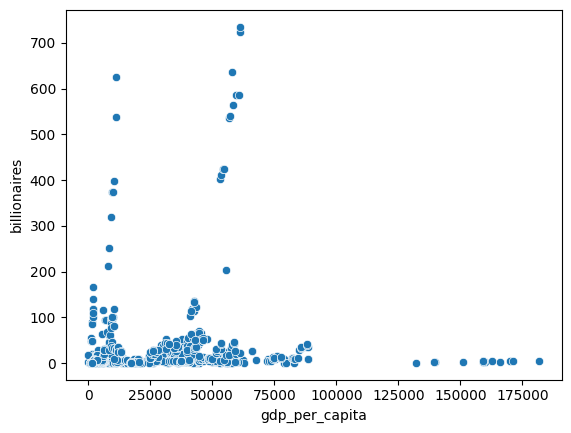

In [99]:
sns.scatterplot(data=countries_df,x='gdp_per_capita',y='billionaires')

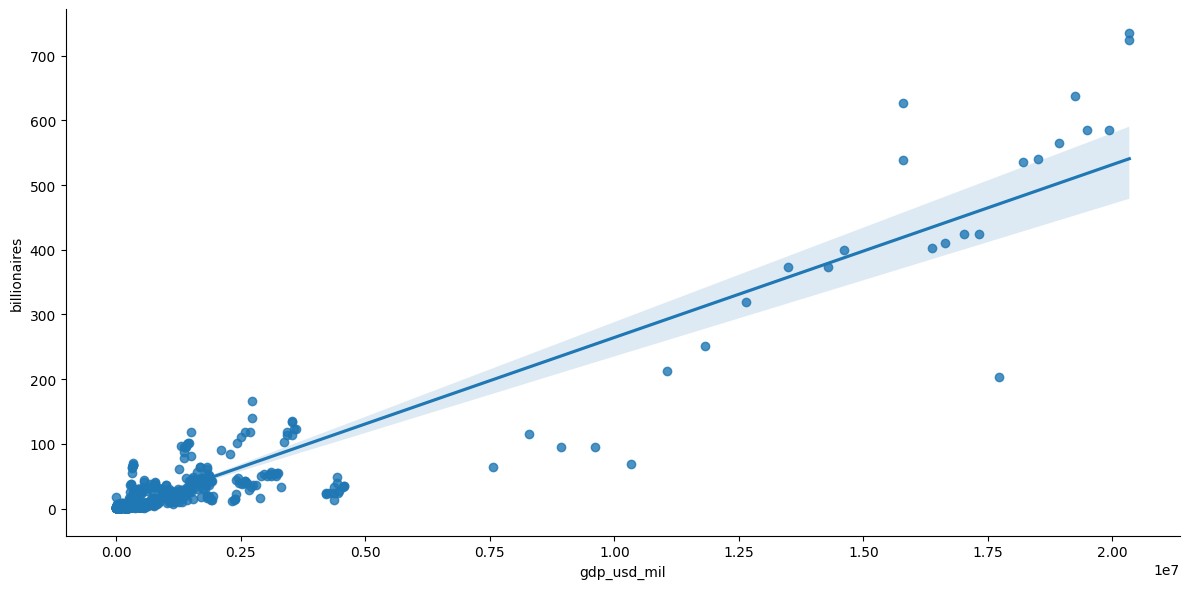

In [100]:
x = sns.lmplot(data=countries_df,x='gdp_usd_mil',y='billionaires',height=6,aspect=2)


## Presumptions
<b>
<font size = 4>
 <br>   
 1) we are presuming that the billionaires are the innovators <br>
 2) more billionaires produce more wealth ie. GDP and vice versa.
    </b> (as clearly visible in the graph above)
    <br><b>
 <font size = 4>
 3) therefore having more billionaires is a good thing for a country.<br>

In [101]:
x = countries_df[countries_df['year']==2010][['country','billionaires','net_worth']].sort_values('billionaires',ascending=False)
z = x.copy()
z = z.head(8)
z.reset_index(drop=True,inplace=True)
z.loc[len(z)] = ['others',x['billionaires'].sum() - z['billionaires'].sum(),x['net_worth'].sum() - z['net_worth'].sum()]
z


country  billionaires  net_worth
0   United States           403     1349.3
1           China            64      133.2
2          Russia            62      265.0
3         Germany            53      217.7
4           India            49      222.1
5  United Kingdom            29       76.7
6          Turkey            28       42.8
7       Hong Kong            25      115.6
8          others           298     1145.4

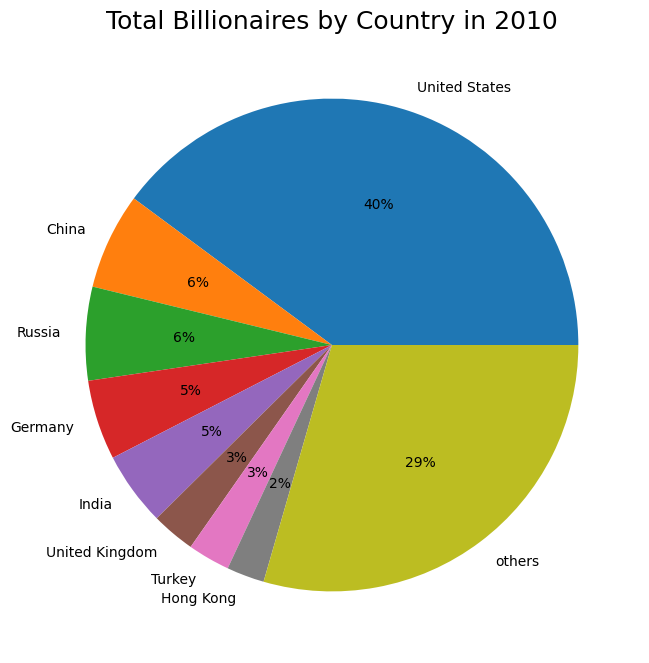

In [102]:
plt.figure(figsize=(8,8))
plt.pie(z['billionaires'],labels=z['country'],autopct='%.0f%%')
plt.title('Total Billionaires by Country in 2010',fontdict={'fontsize':18})
plt.show()

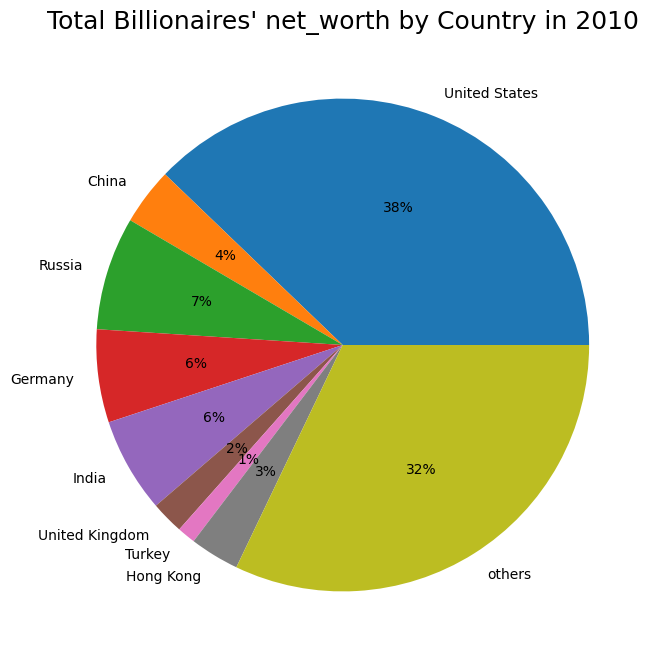

In [103]:
plt.figure(figsize=(8,8))
plt.pie(z['net_worth'],labels=z['country'],autopct='%.0f%%')
plt.title("Total Billionaires' net_worth by Country in 2010",fontdict={'fontsize':18})
plt.show()

In [104]:
x = countries_df[countries_df['year']==2022][['country','billionaires','net_worth']].sort_values('billionaires',ascending=False)
z = x.copy()
z = z.head(8)
z.reset_index(drop=True,inplace=True)
z.loc[len(z)] = ['others',x['billionaires'].sum() - z['billionaires'].sum(),x['net_worth'].sum() - z['net_worth'].sum()]
z


country  billionaires  net_worth
0  United States           735    4701.10
1          China           539    1962.45
2          India           166     749.80
3        Germany           134     608.00
4         Russia            81     300.40
5      Hong Kong            67     383.40
6         Canada            65     312.60
7         Brazil            62     186.70
8         others           819    3501.50

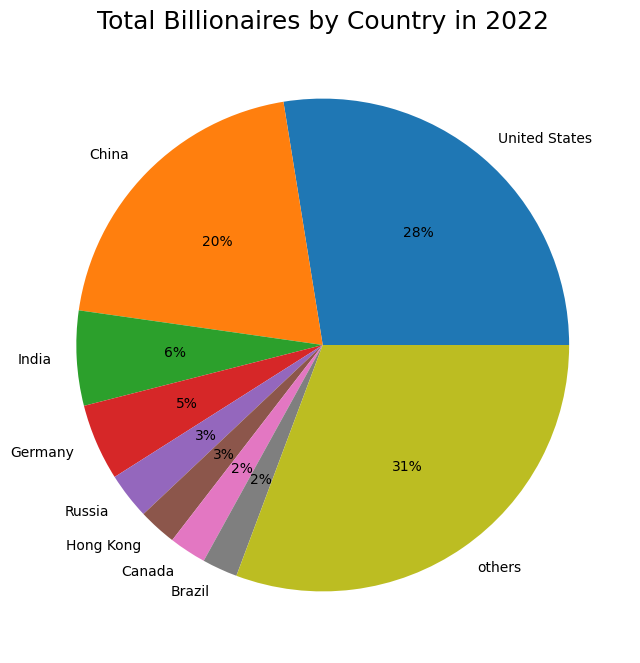

In [105]:
plt.figure(figsize=(8,8))
plt.pie(z['billionaires'],labels=z['country'],autopct='%.0f%%')
plt.title('Total Billionaires by Country in 2022',fontdict={'fontsize':18})
plt.show()

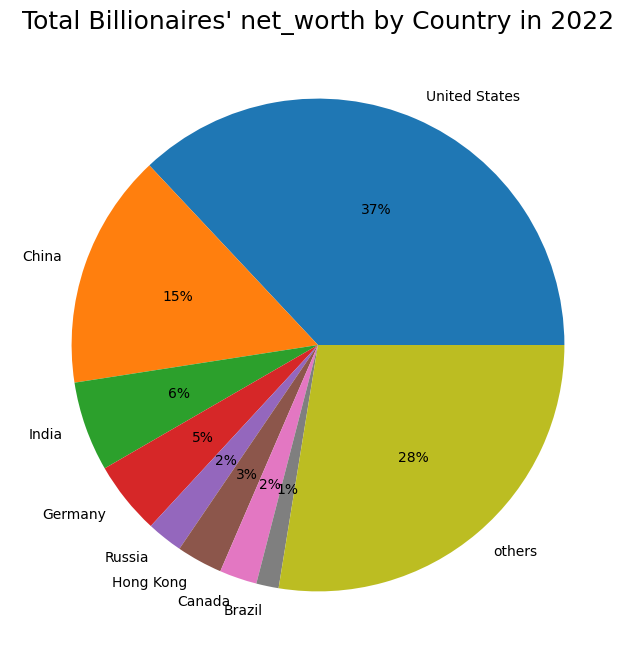

In [106]:
plt.figure(figsize=(8,8))
plt.pie(z['net_worth'],labels=z['country'],autopct='%.0f%%')
plt.title("Total Billionaires' net_worth by Country in 2022",fontdict={'fontsize':18})
plt.show()

In [107]:
countries_df

year  billionaires   country  net_worth  country_population  \
0    2011.0             2       NaN        2.4                 NaN   
1    2015.0             1   Algeria        3.1          39728020.0   
2    2016.0             1   Algeria        3.1          40551398.0   
3    2017.0             1   Algeria        3.1          41389174.0   
4    2018.0             1   Algeria        4.0          42228415.0   
..      ...           ...       ...        ...                 ...   
851  2018.0             1  Zimbabwe        1.4          14438812.0   
852  2019.0             1  Zimbabwe        1.4          14645473.0   
853  2020.0             1  Zimbabwe        1.7          14862927.0   
854  2021.0             1  Zimbabwe        1.5          15092171.0   
855  2022.0             1  Zimbabwe        3.0          15092171.0   

     urban_population  gdp_usd_mil  gdp_growth  gdp_per_capita  \
0                 NaN          NaN         NaN             NaN   
1          28146508.0    165979.28        3.70         4177.89   
2          28977623.0    171290.62        3.20         4224.04   
3          29821728.0    173517.39        1.30         4192.34   
4          30670076.0    175426.09        1.10         4154.22   
..                ...          ...         ...             ...   
851         4650597.0     22077.32        4.82         1529.03   
852         4717307.0     20720.84       -6.14         1414.83   
853         4792105.0     19426.05       -6.25         1307.01   
854         4875224.0     20562.36        5.85         1362.45   
855         4875224.0     20562.36        5.85         1362.45   

     trade_percent_gdp  co2_emmissions  billionaires_per_mil_population  
0                  NaN             NaN                              NaN  
1                59.70       263140.01                           0.0252  
2                55.93       265359.99                           0.0247  
3                55.32       268899.99                           0.0242  
4                58.07       278030.00                           0.0237  
..                 ...             ...                              ...  
851              69.45        30830.00                           0.0693  
852              63.28        30530.00                           0.0683  
853              76.00        30530.00                           0.0673  
854              76.00        30530.00                           0.0663  
855              76.00        30530.00                           0.0663  

[856 rows x 12 columns]

In [108]:
top_countries = []
for i in pd.DataFrame(countries_df['year']).sort_values('year')['year'].unique():
    print(i,'  \n')
    x = countries_df[countries_df['year']==i][['country','billionaires']].groupby('country',as_index=False).sum().sort_values('billionaires',ascending=False).reset_index(drop=True).head(10)
    print(x)
    print('\n\n\n')
    for ii in x['country']:
        if ii not in top_countries:
            top_countries.append(ii)

2010.0   

          country  billionaires
0   United States           403
1           China            64
2          Russia            62
3         Germany            53
4           India            49
5  United Kingdom            29
6          Turkey            28
7       Hong Kong            25
8          Canada            24
9           Japan            22




2011.0   

          country  billionaires
0   United States           411
1           China           116
2          Russia            97
3           India            56
4         Germany            50
5          Turkey            38
6       Hong Kong            36
7  United Kingdom            33
8          Brazil            31
9          Canada            25




2012.0   

          country  billionaires
0   United States           424
1          Russia            96
2           China            95
3         Germany            55
4           India            48
5       Hong Kong            38
6          Brazil            37

In [109]:
df['name'] = df['name'].apply(lambda x: x if x[-1]!=' ' else x[:-1])

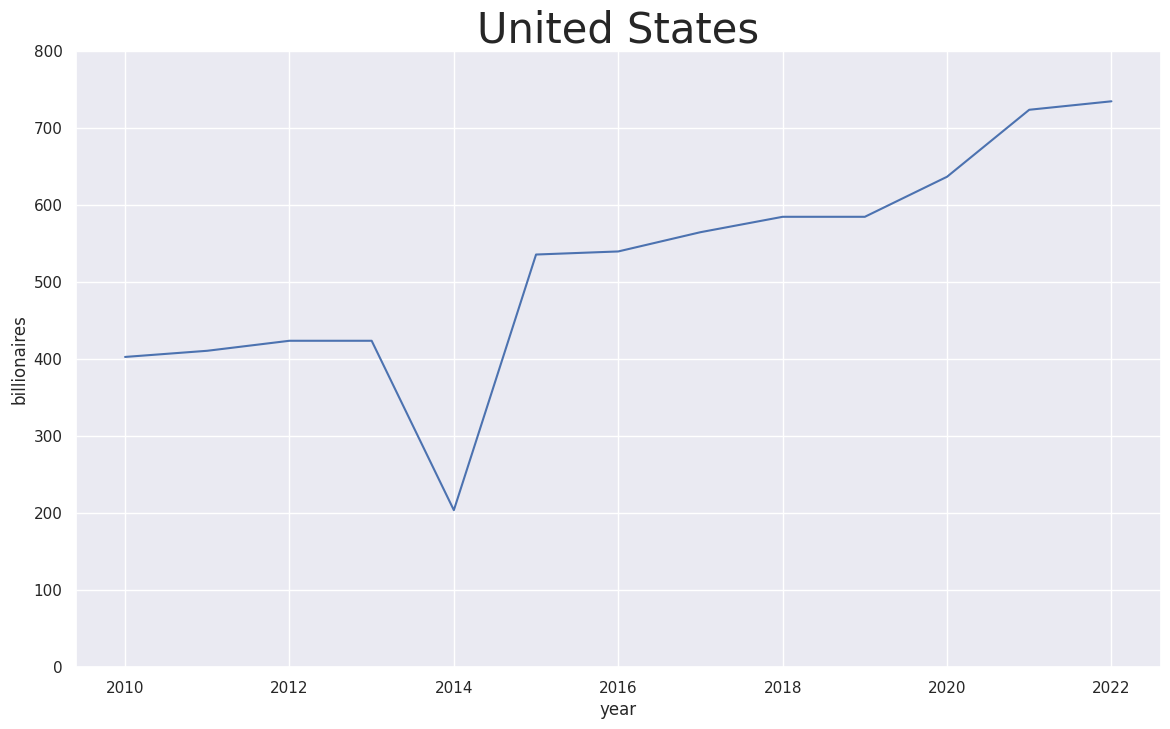

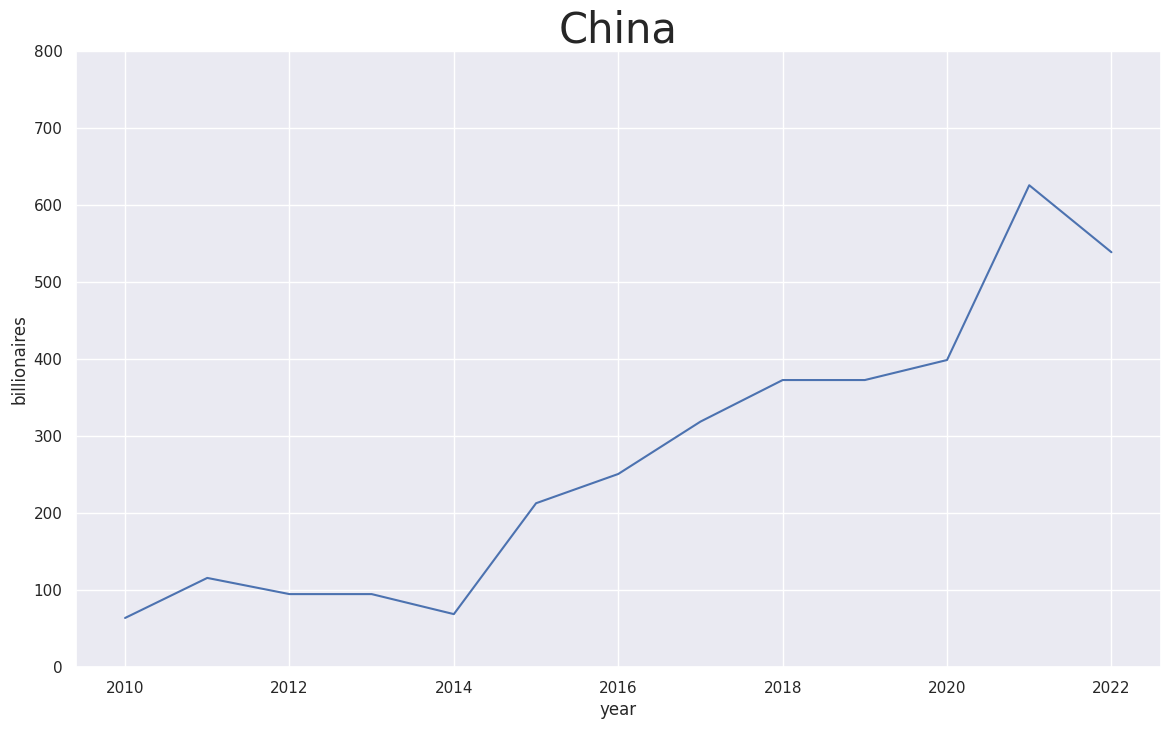

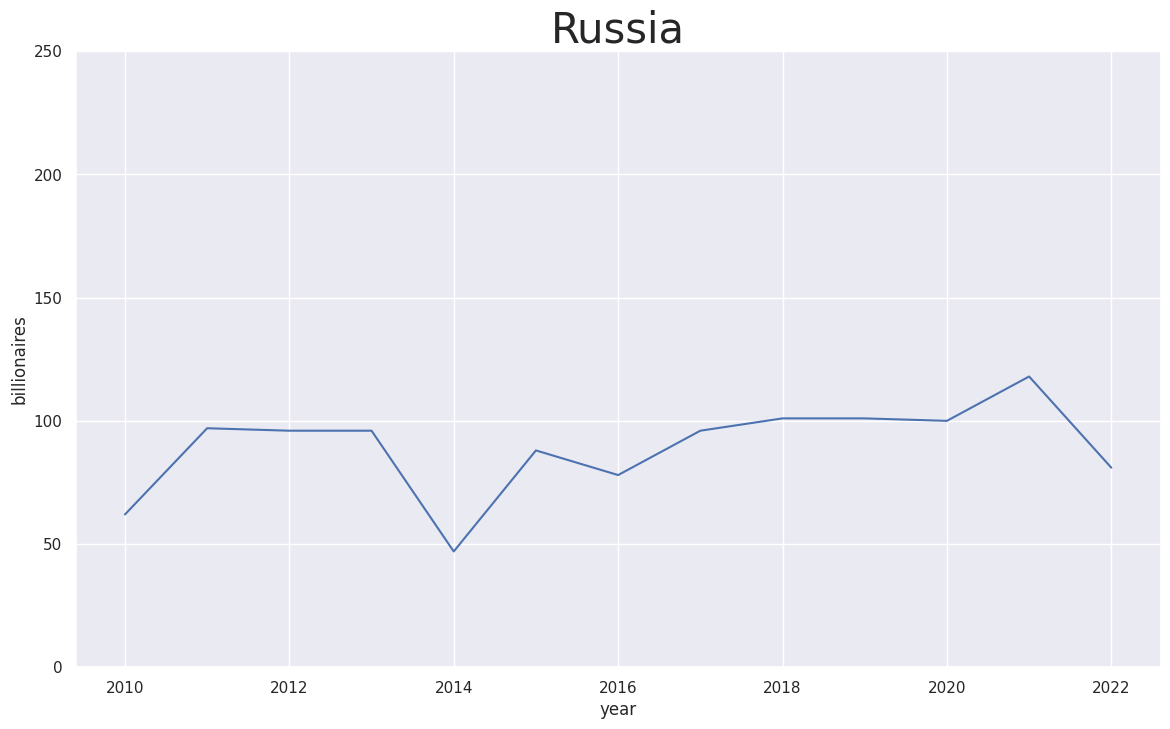

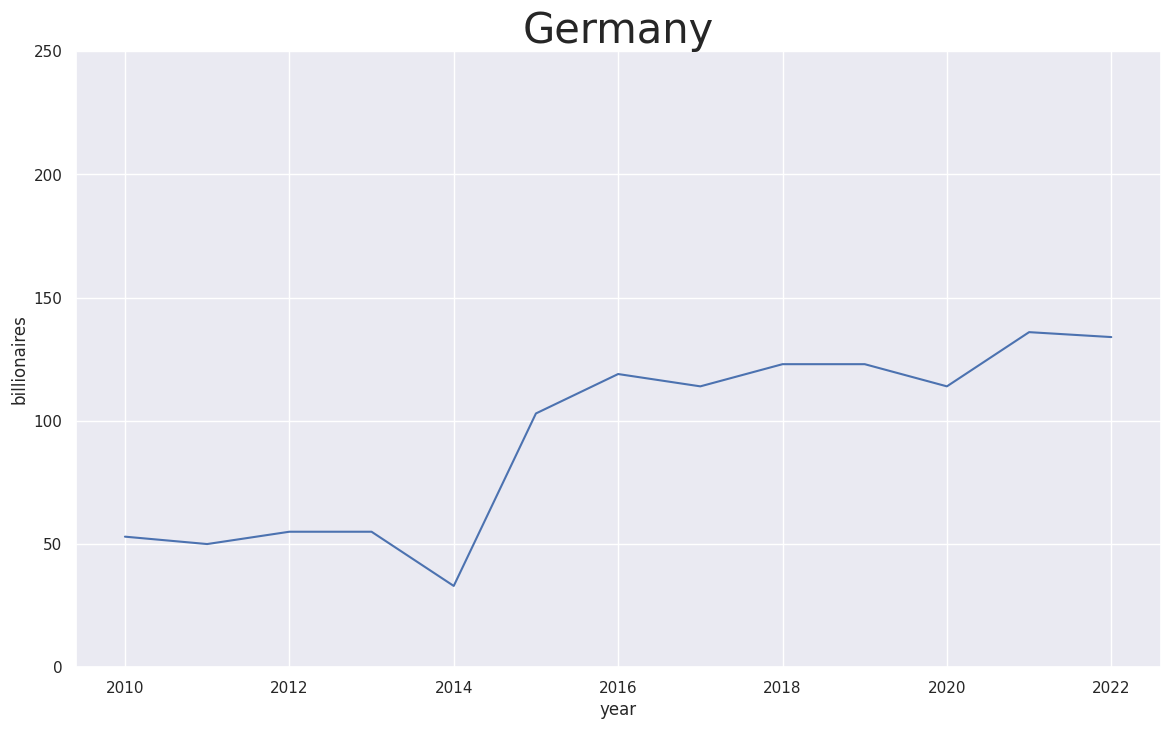

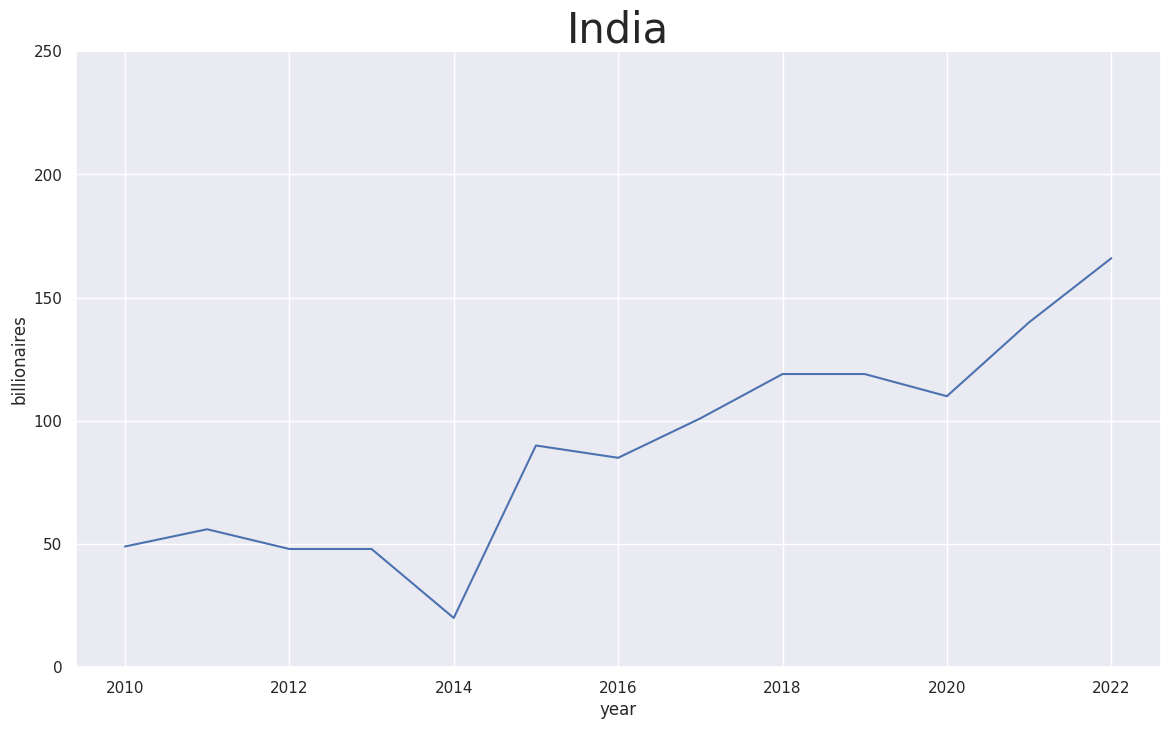

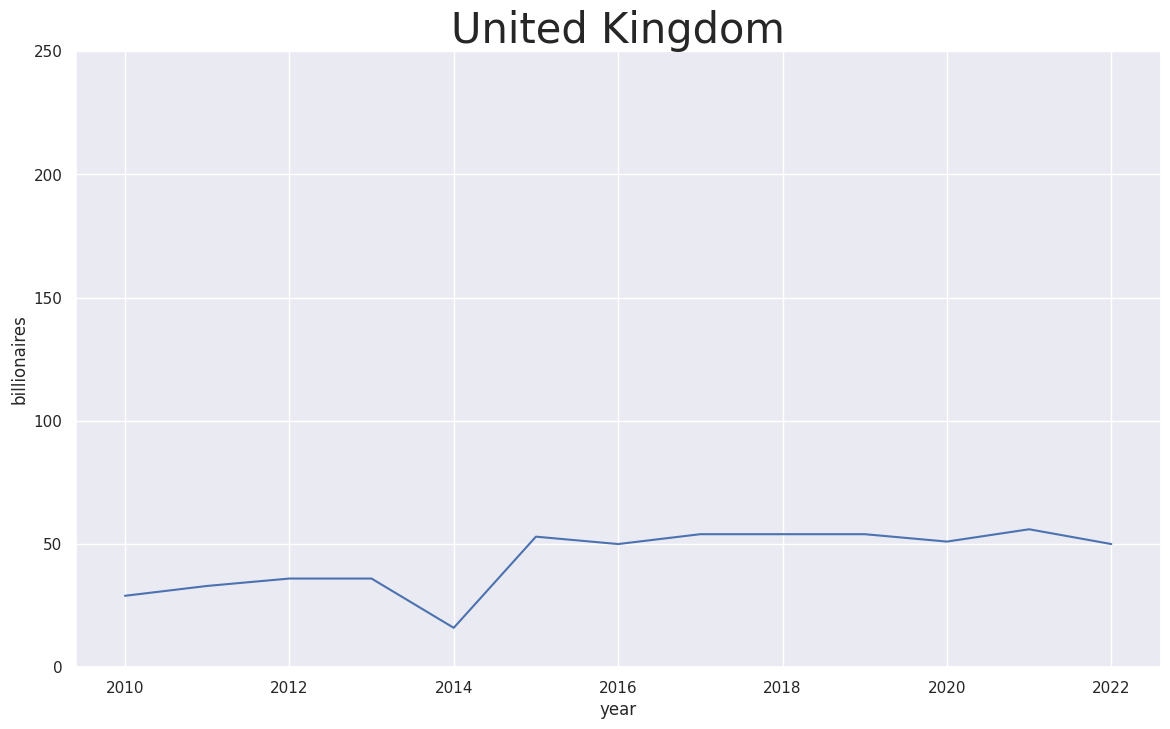

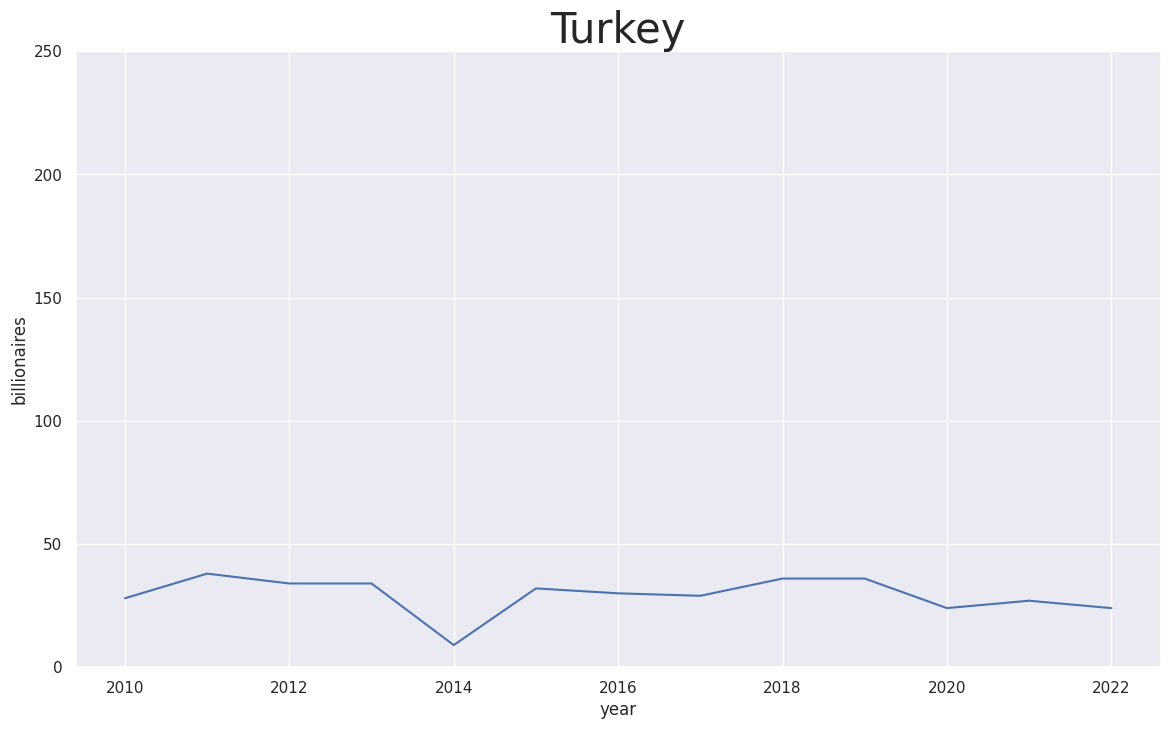

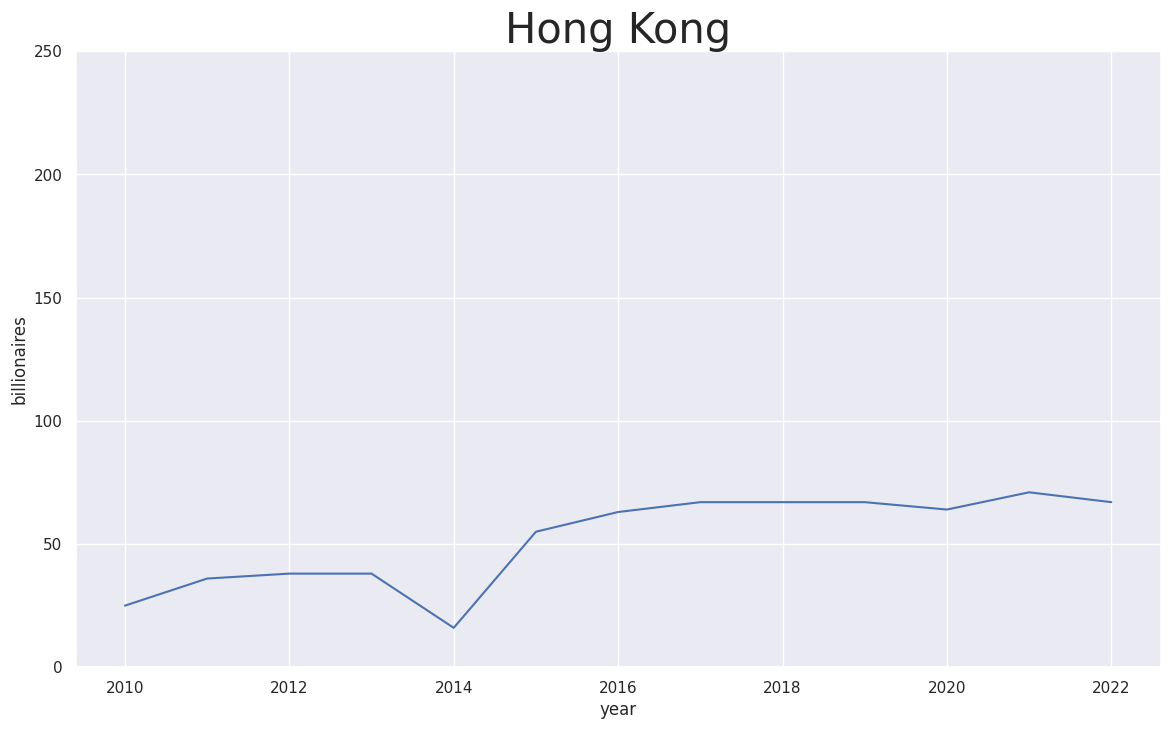

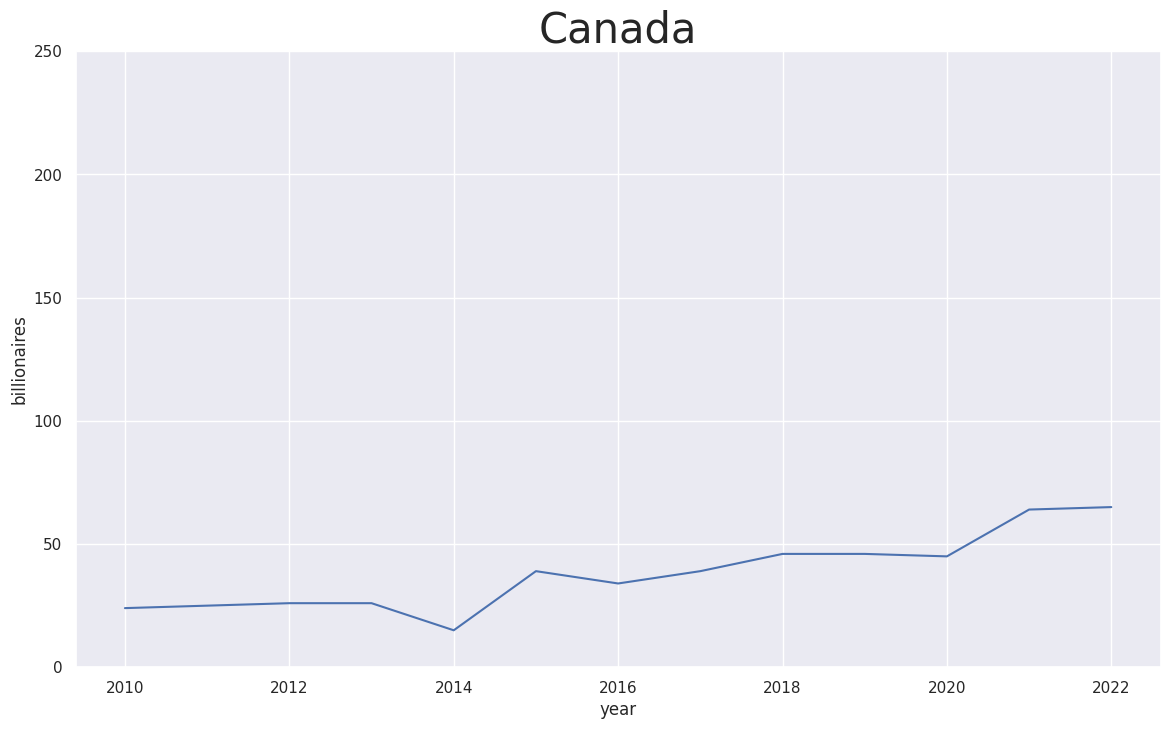

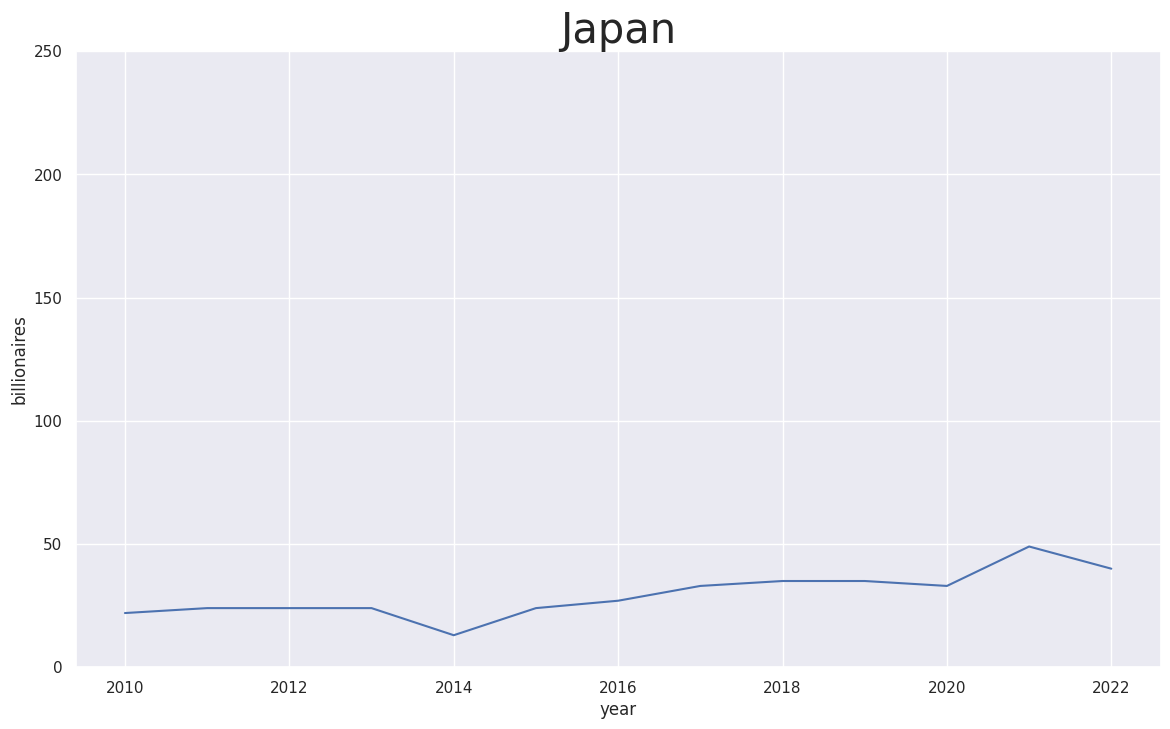

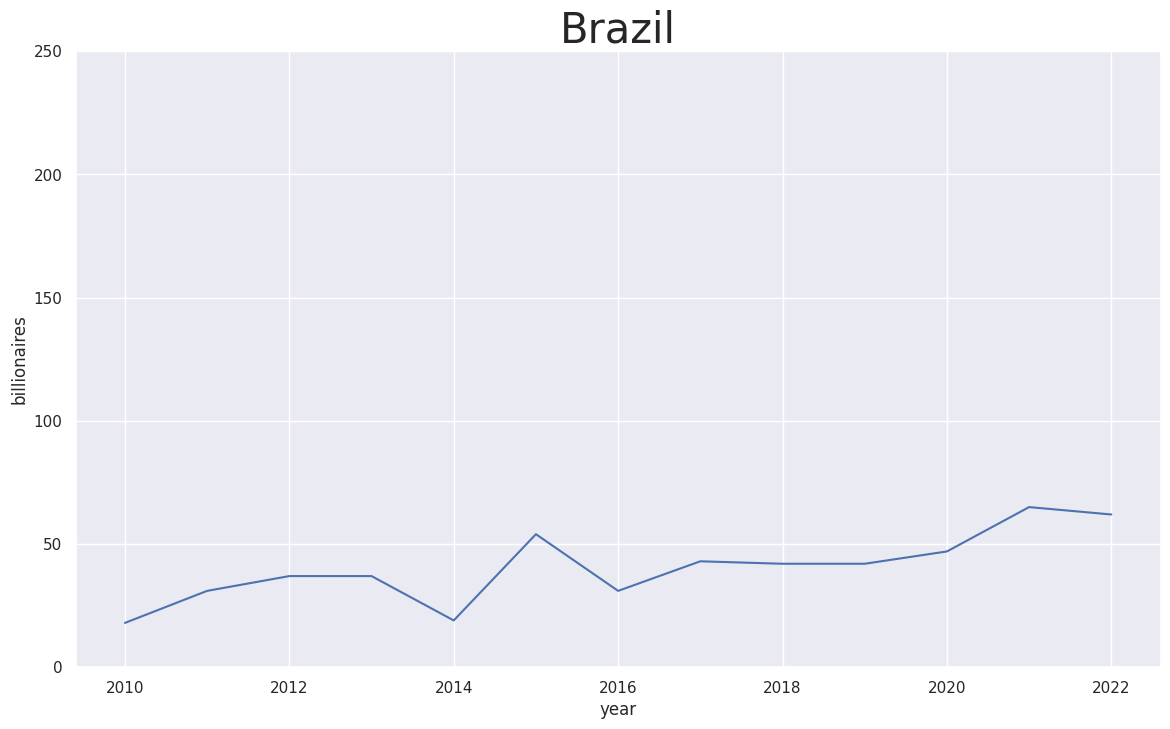

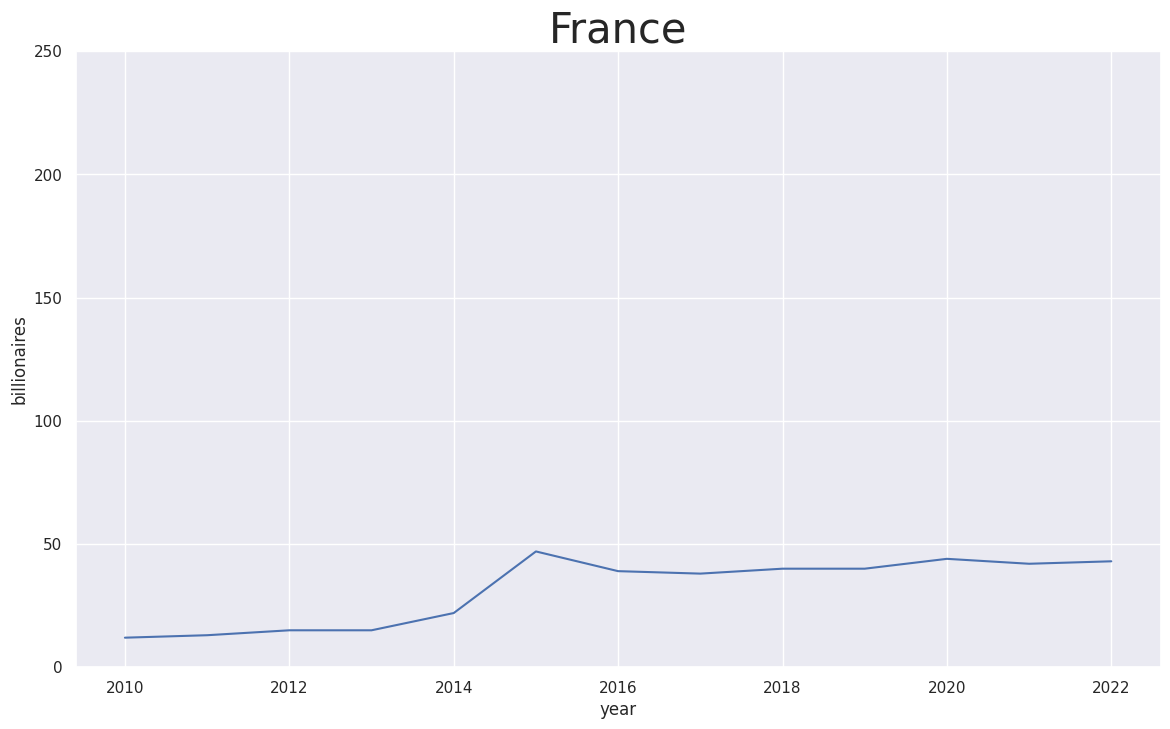

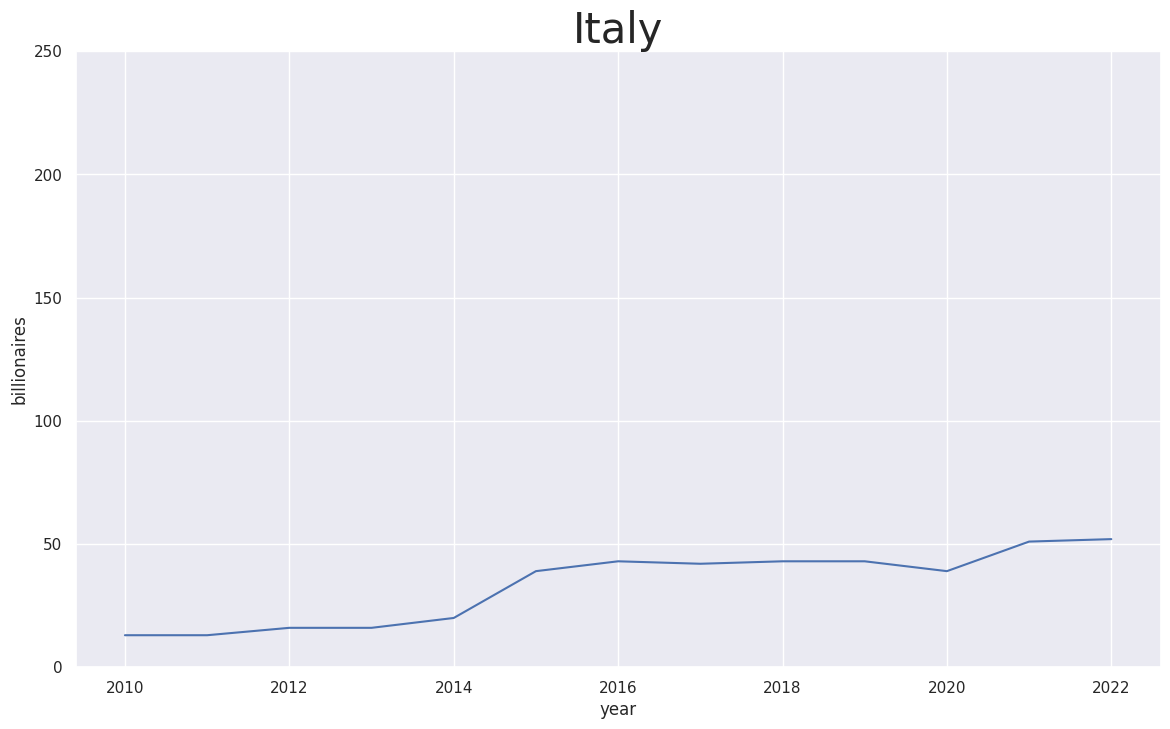

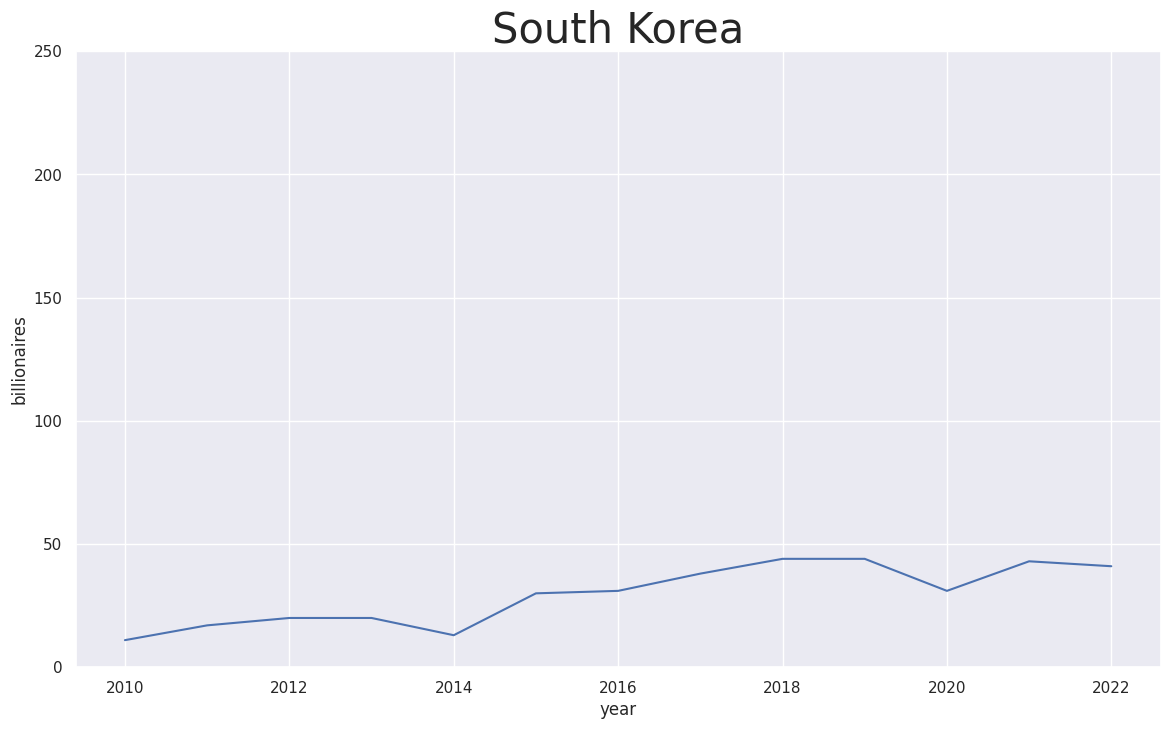

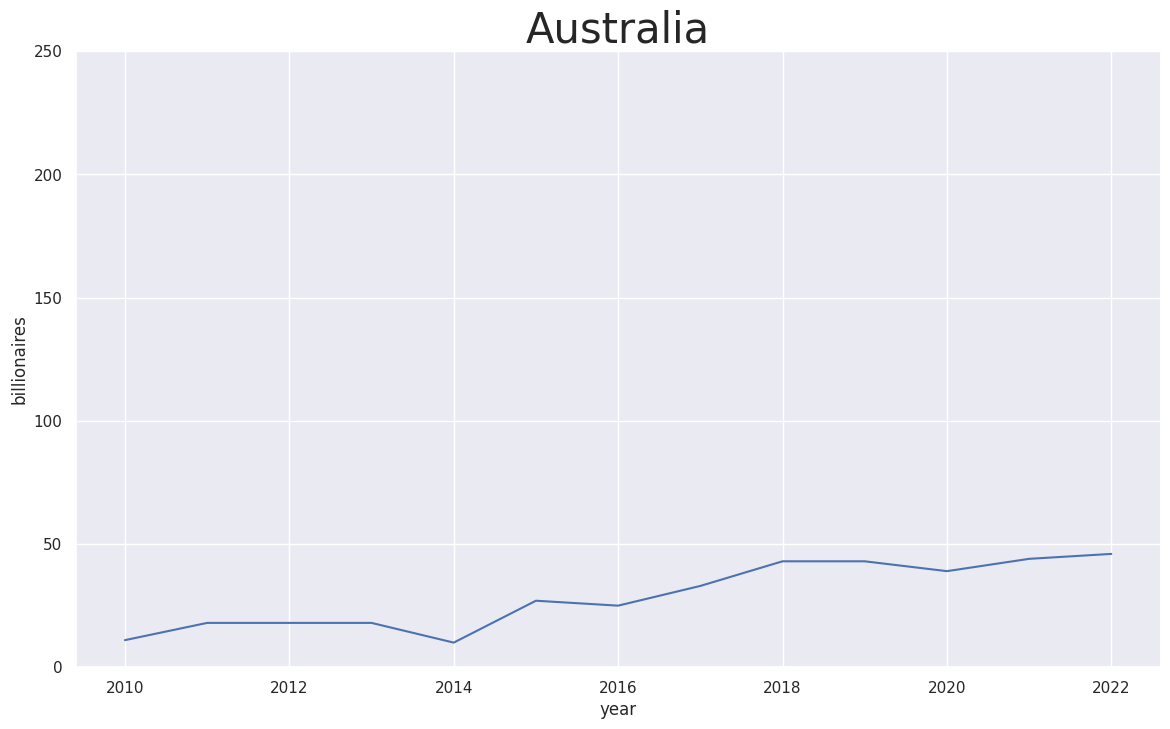

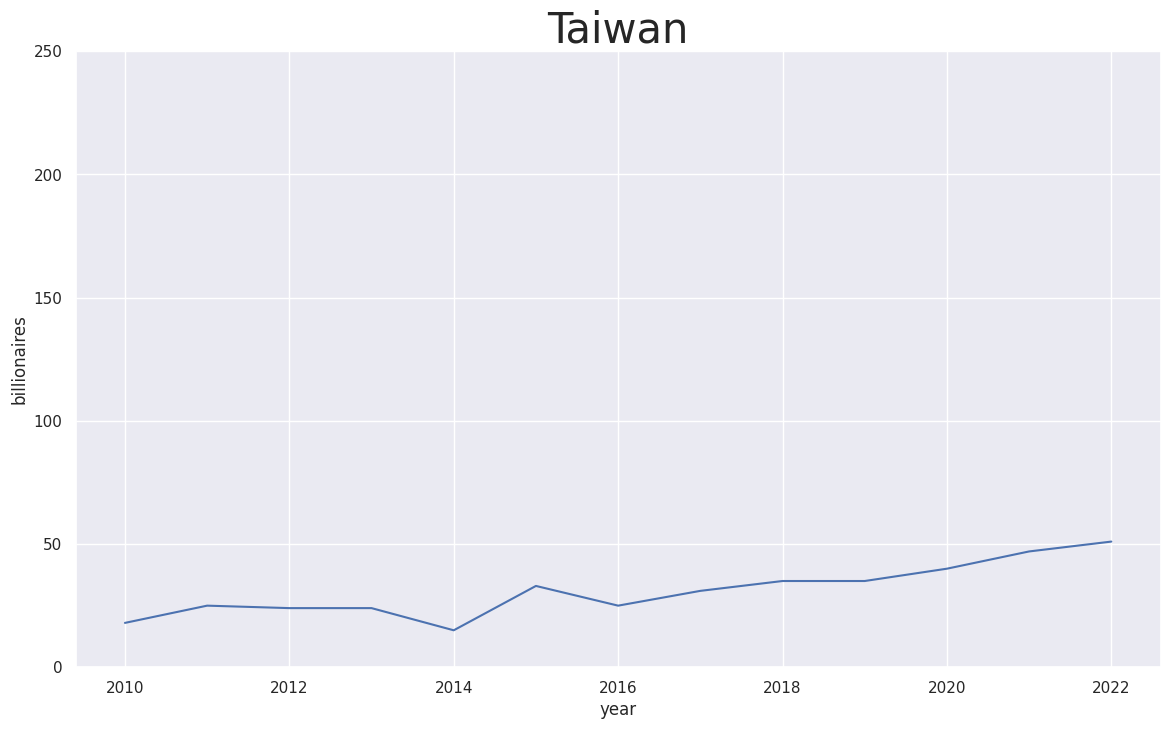

In [110]:
for i in top_countries:
    x = countries_df[countries_df['country']==i].groupby('year',as_index=False).sum()
    sns.set(rc={'figure.figsize':(14,8)})
    sns.lineplot(data=x,x='year',y='billionaires')
    plt.title(i,fontdict={'fontsize':30})
    if i not in ['United States','China']:
        plt.ylim((0,250))
    else:
        plt.ylim(0,800)
    
    plt.ticklabel_format(style='plain', axis='y',scilimits=(0,0))
    plt.show()                   



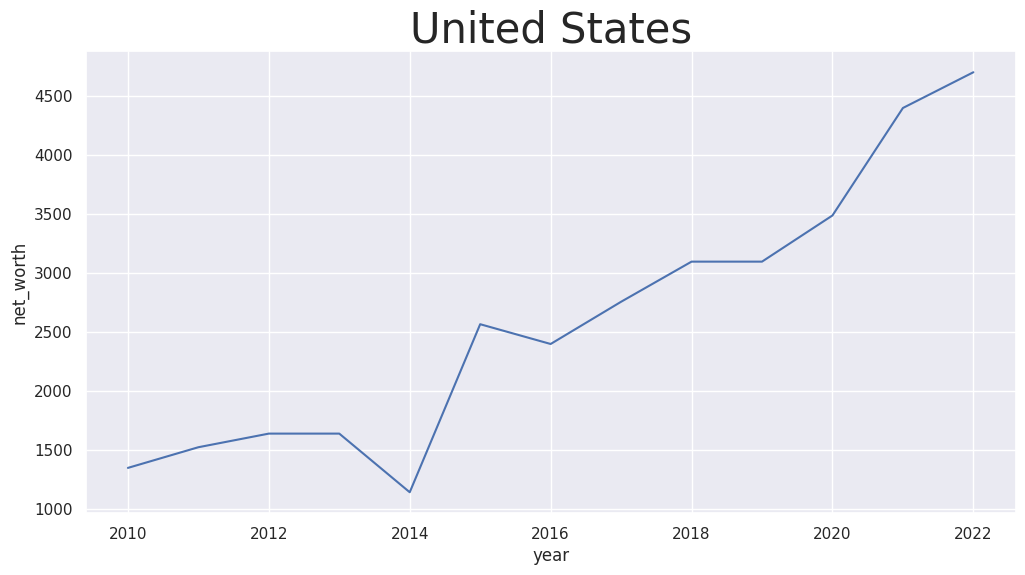

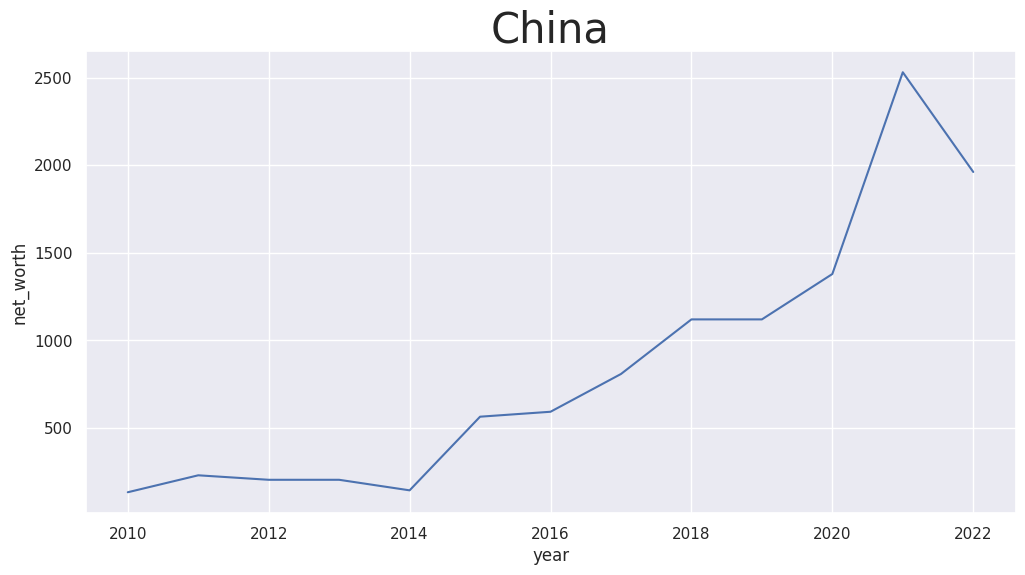

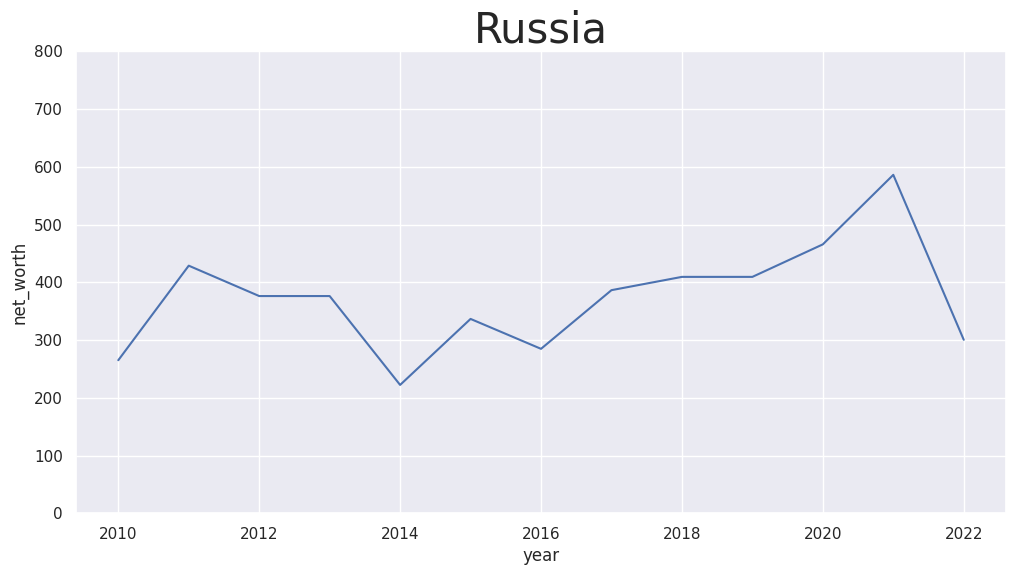

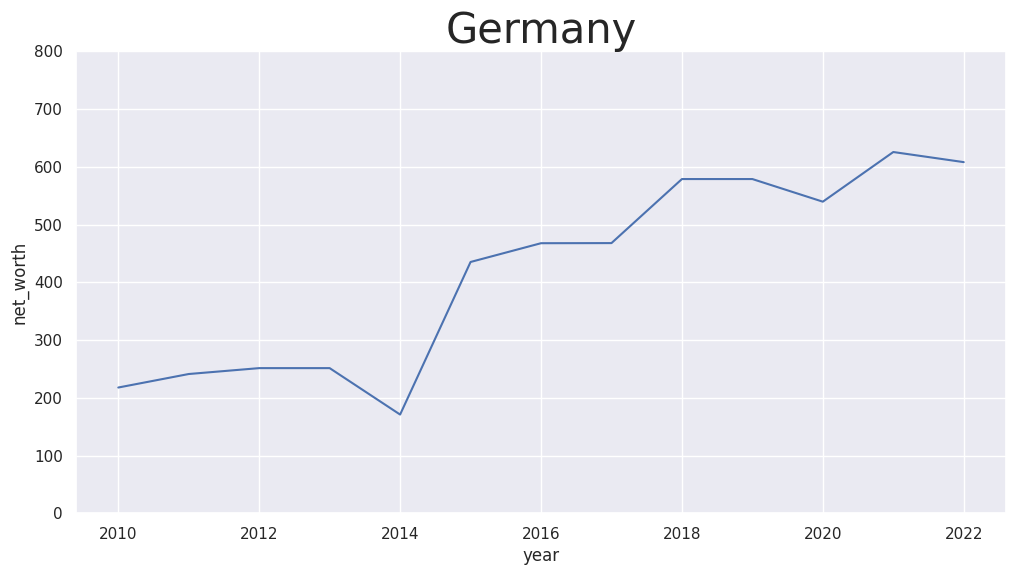

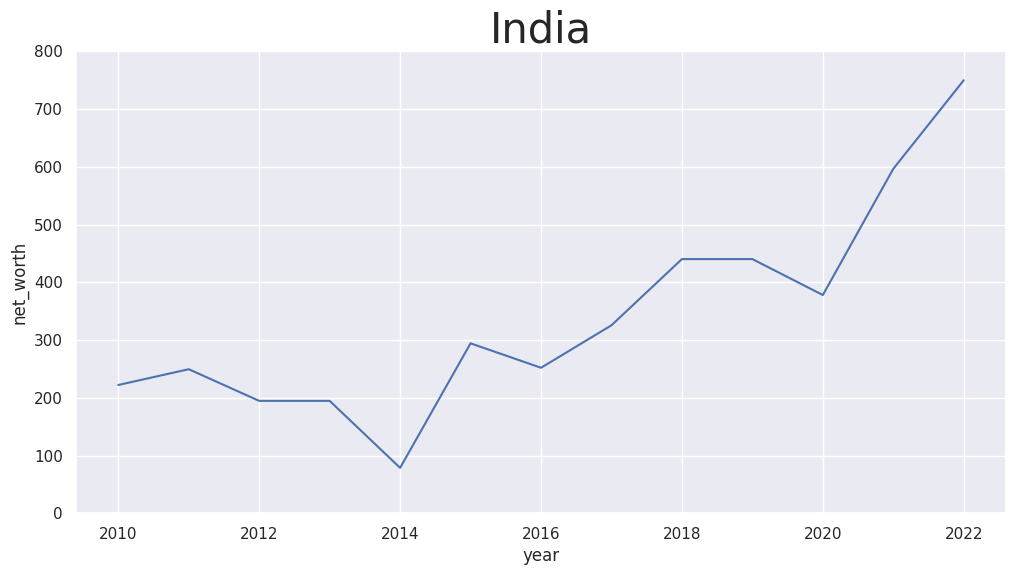

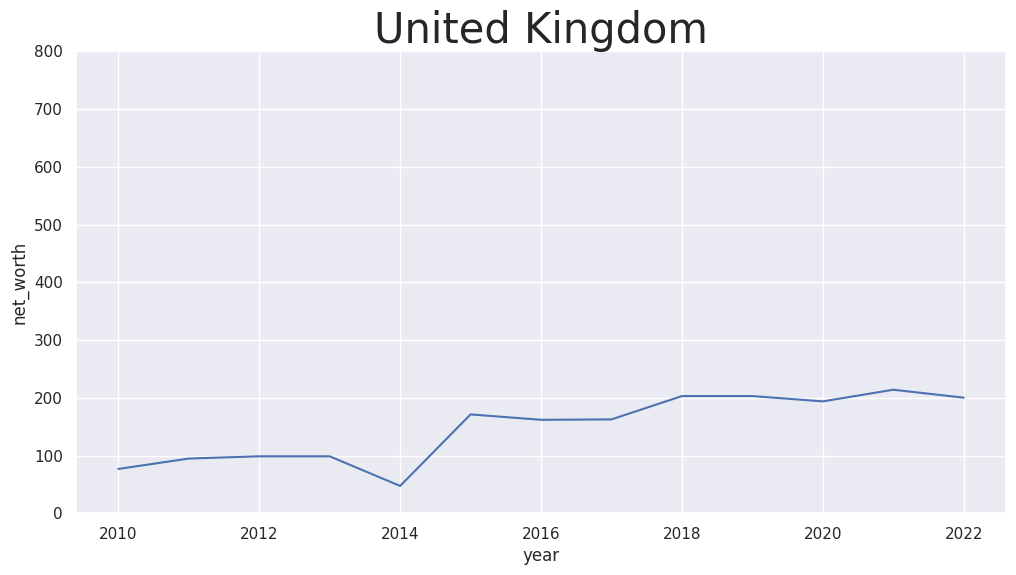

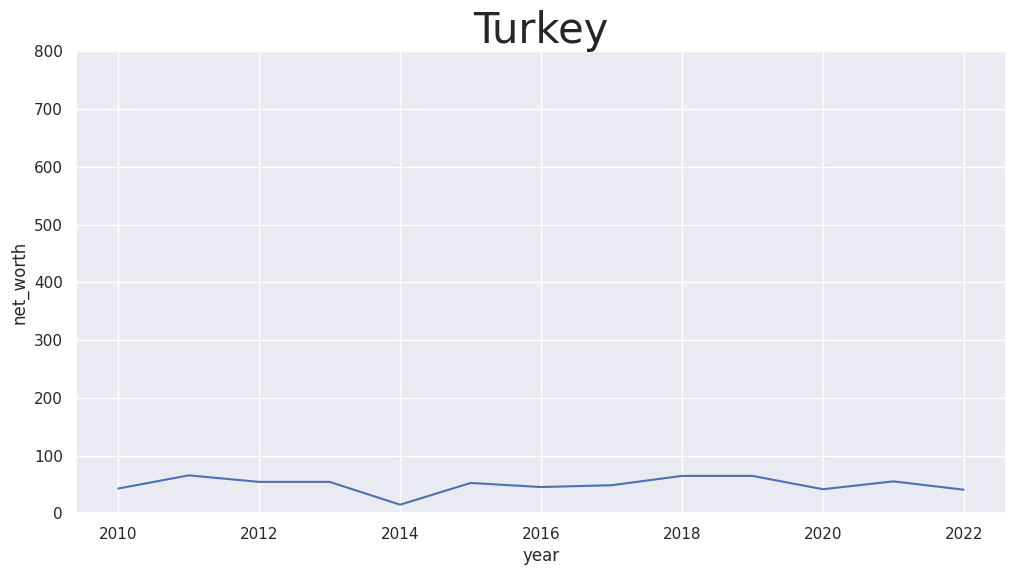

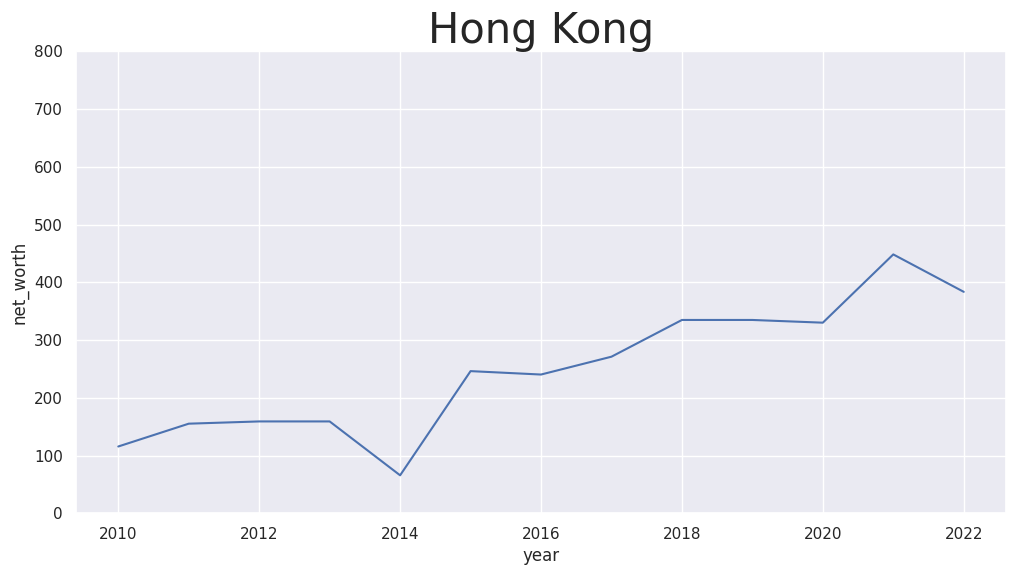

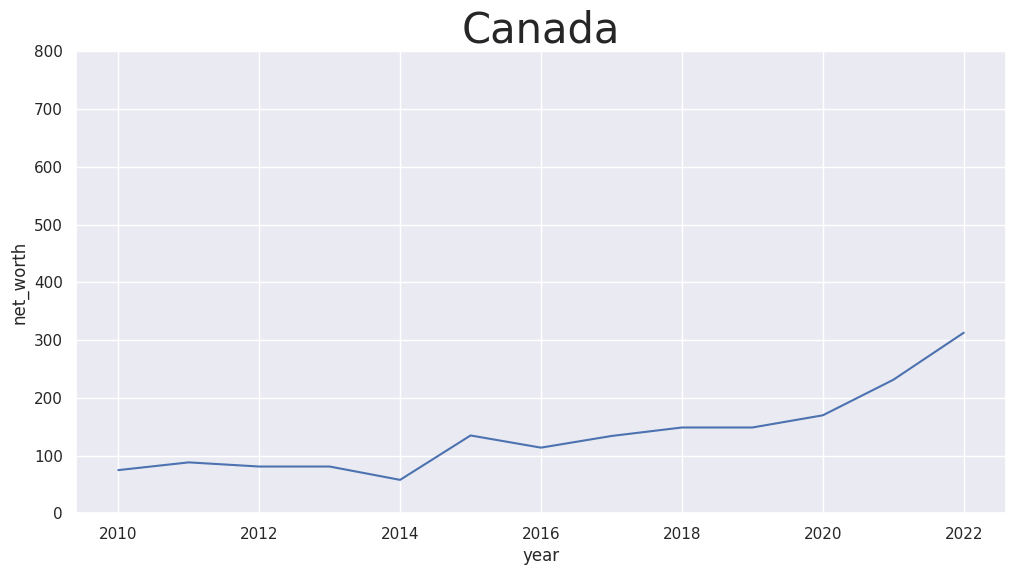

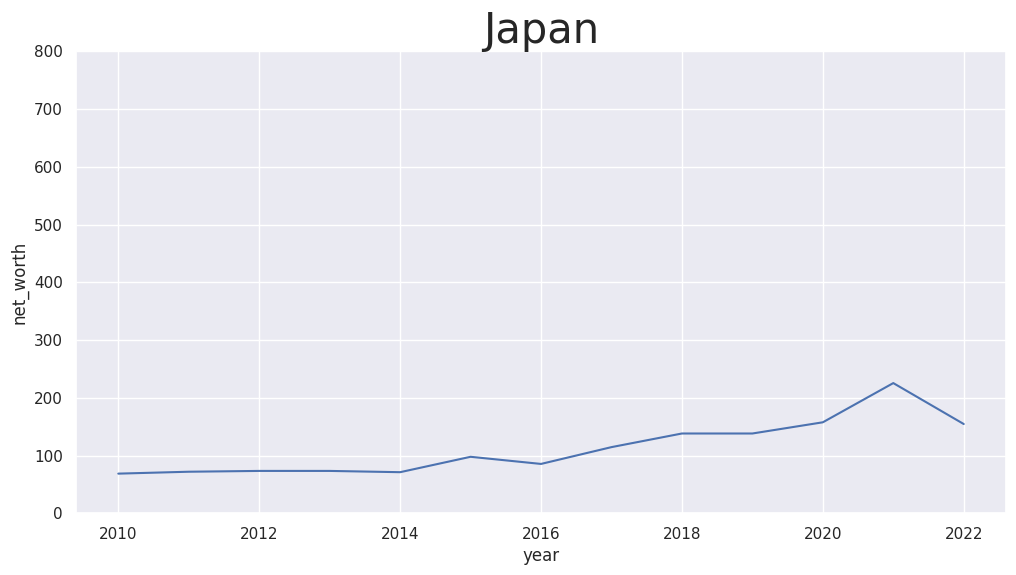

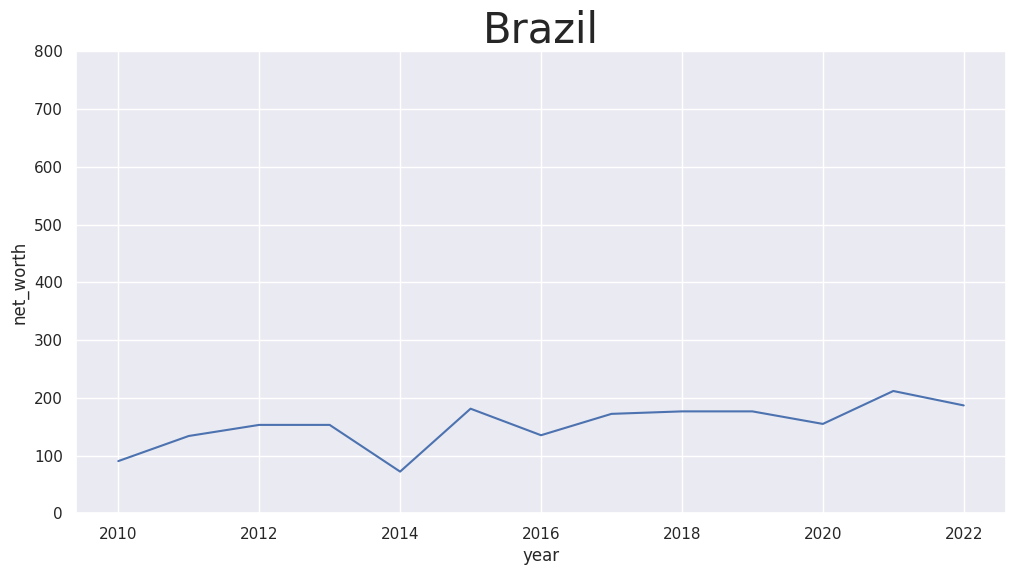

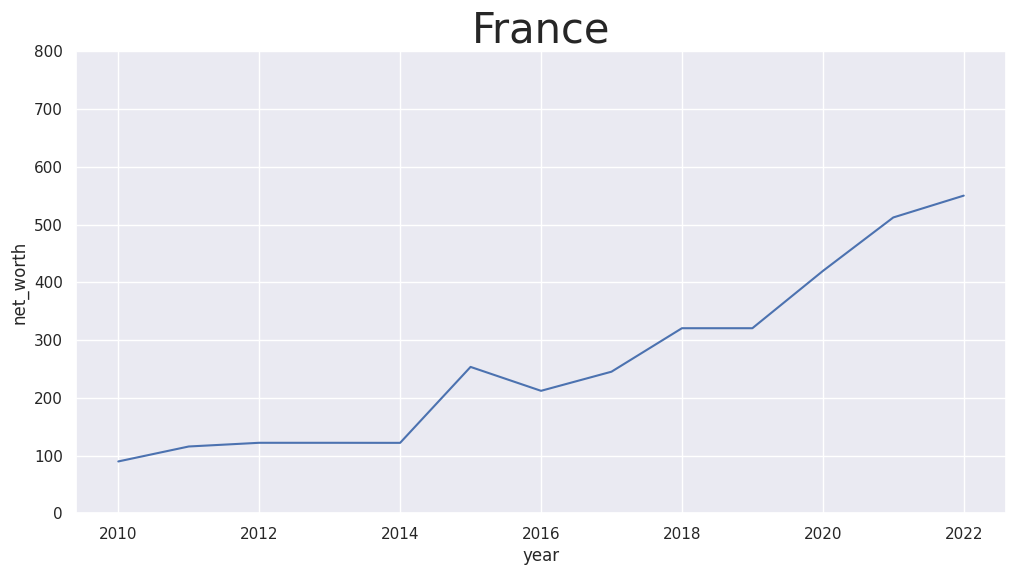

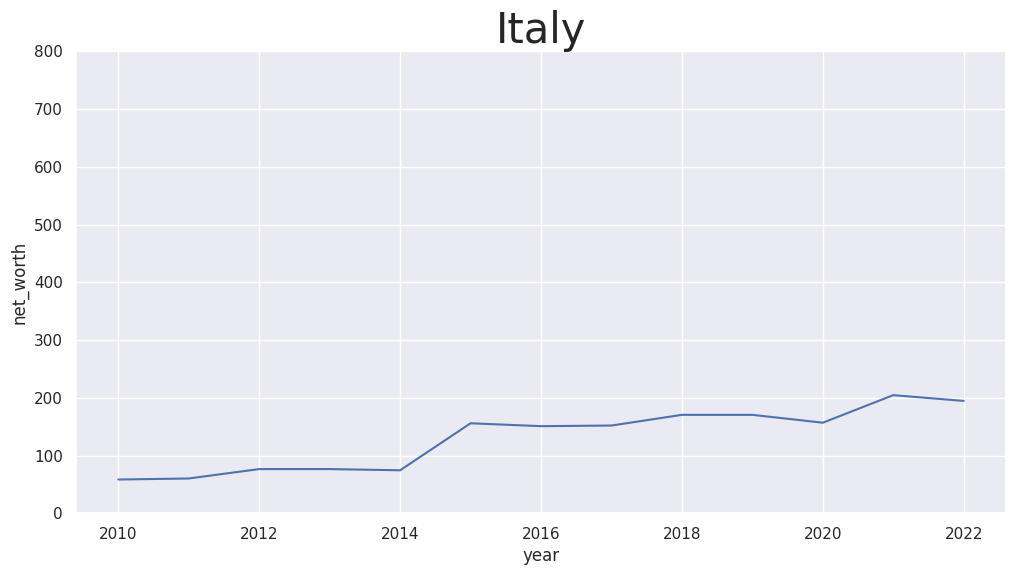

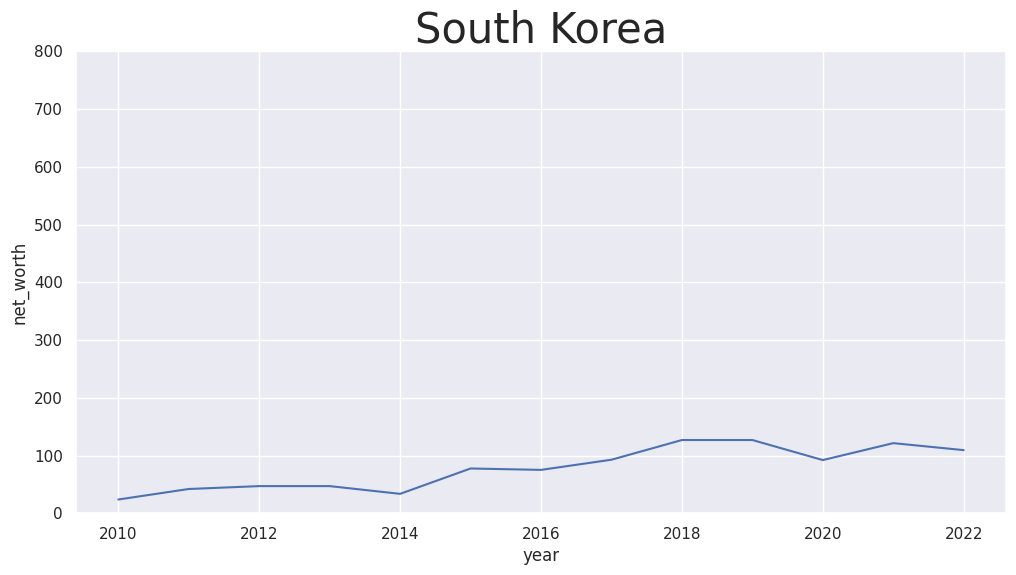

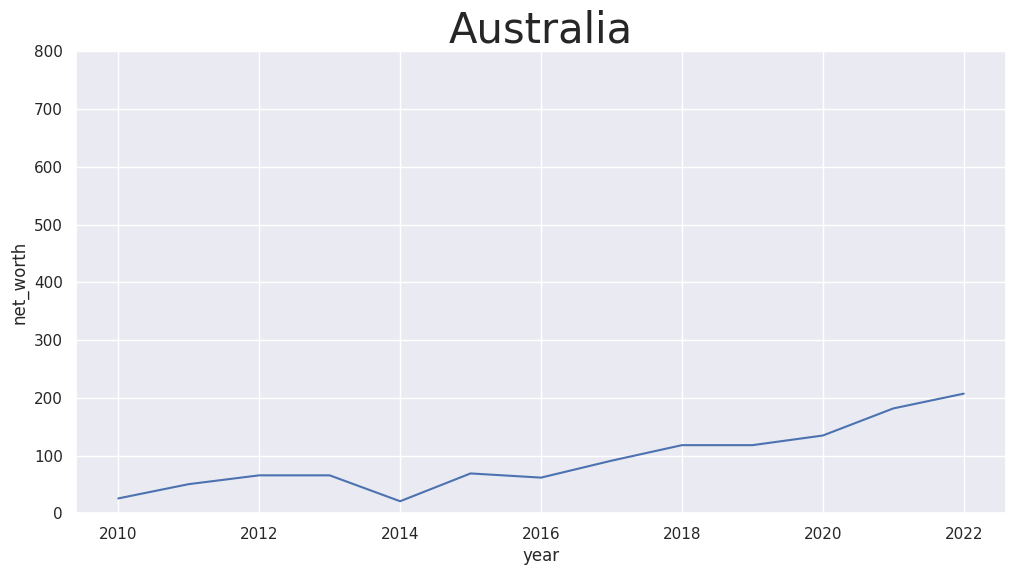

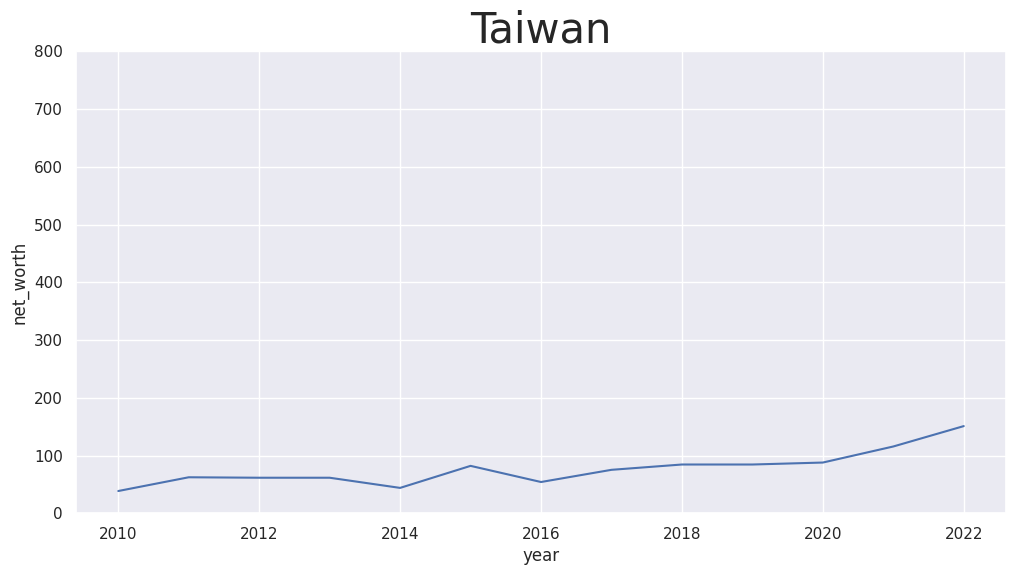

In [111]:
for i in top_countries:
    x = countries_df[countries_df['country']==i].groupby('year',as_index=False).sum()
    sns.set(rc={'figure.figsize':(12,6)})
    sns.lineplot(data=x,x='year',y='net_worth')
    plt.title(i,fontdict={'fontsize':30})
    if i not in ['United States','China']:
        plt.ylim((0,800))
    else:
        pass
    
    plt.ticklabel_format(style='plain', axis='y',scilimits=(0,0))
    plt.show()
    

In [112]:
str(top_countries)

"['United States', 'China', 'Russia', 'Germany', 'India', 'United Kingdom', 'Turkey', 'Hong Kong', 'Canada', 'Japan', 'Brazil', 'France', 'Italy', 'South Korea', 'Australia', 'Taiwan']"

### Observations
<font size = 4>
    <br>
    1) The numbers clearly show the reality that the US and, after 2014, China dominates in the number of billionairs as well as the combined net worth they hold. <br><br>
    2) United States, China, Russia, Germany, India, United Kingdom, Turkey, Hong Kong, Canada, Japan, Brazil, France, Italy, South Korea, Australia, Taiwan are among the top 10 countries that dominate in those spots from 2010 to 2022.<br><br>
    3) Interestingly, countries like <b> Hong Kong, South Korea, Taiwan </b> are very small both in respect of population and land size, yet they are comfortably competing in the space of rich countries.<br><br>
    

In [113]:
for con in df['continents'].unique()[:-1]:
    print(con,'\n\n')
    for y in df['year'].unique():
        print(y,'\n\n')
        print(df[(df['continents']==con) & (df['year']==y)][['rank','name','citizenship','net_worth']].sort_values('net_worth',ascending=False).head(10))
        print('\n\n\n\n')

North America 


2010.0 


    rank                       name    citizenship  net_worth
0    1.0  Carlos Slim Helu & family         Mexico       53.5
1    2.0          William Gates III  United States       53.0
2    3.0             Warren Buffett  United States       47.0
5    6.0           Lawrence Ellison  United States       28.0
11  12.0    Christy Walton & family  United States       22.5
14  15.0                 Jim Walton  United States       20.7
15  16.0               Alice Walton  United States       20.6
17  18.0           S. Robson Walton  United States       19.8
19  20.0     David Thomson & family         Canada       19.0
22  23.0          Michael Bloomberg  United States       18.0





2011.0 


      rank                       name    citizenship  net_worth
1011   1.0  Carlos Slim Helu & family         Mexico       74.0
1012   2.0                 Bill Gates  United States       56.0
1013   3.0             Warren Buffett  United States       50.0
1015   5.0          

       rank                                        name citizenship  net_worth
20444   3.0                    Bernard Arnault & family      France      158.0
20455  14.0       Francoise Bettencourt Meyers & family      France       74.8
20464  23.0                              Amancio Ortega       Spain       59.6
20469  28.0                              Dieter Schwarz     Germany       47.1
20472  31.0                     Rodolphe Saadé & family      France       41.4
20473  32.0                   François Pinault & family      France       40.4
20474  33.0                        Klaus-Michael Kuehne     Germany       37.3
20476  35.0  Beate Heister & Karl Albrecht Jr. & family     Germany       36.8
20477  36.0                            Giovanni Ferrero       Italy       36.2
20484  43.0                            Alain Wertheimer      France       31.2





South America 


2010.0 


      rank                                 name citizenship  net_worth
7      8.0                  

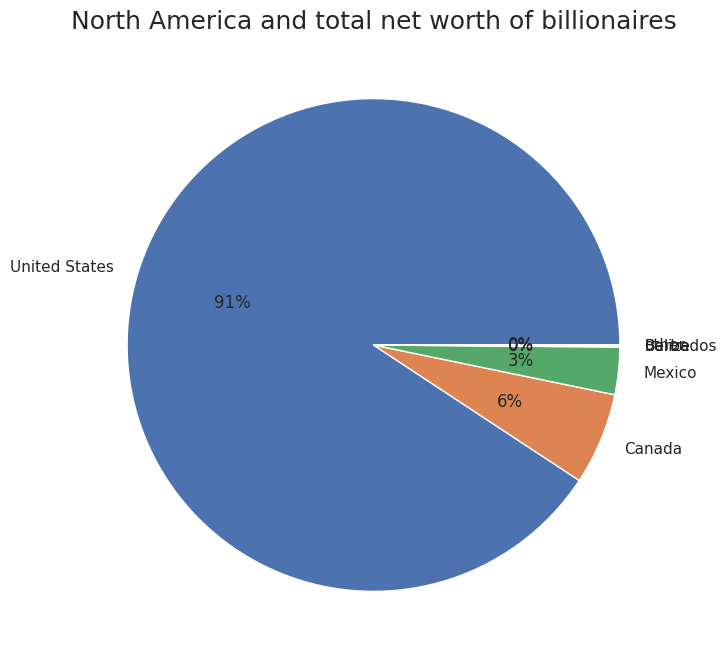

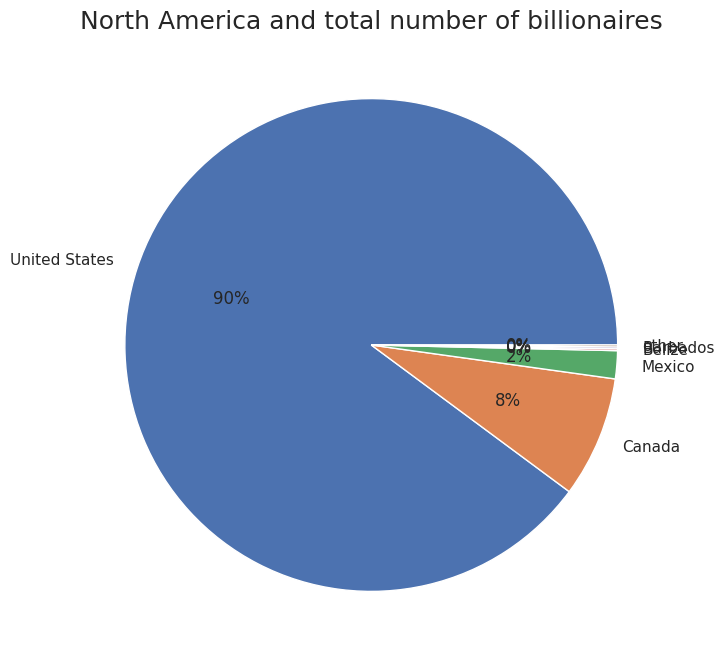

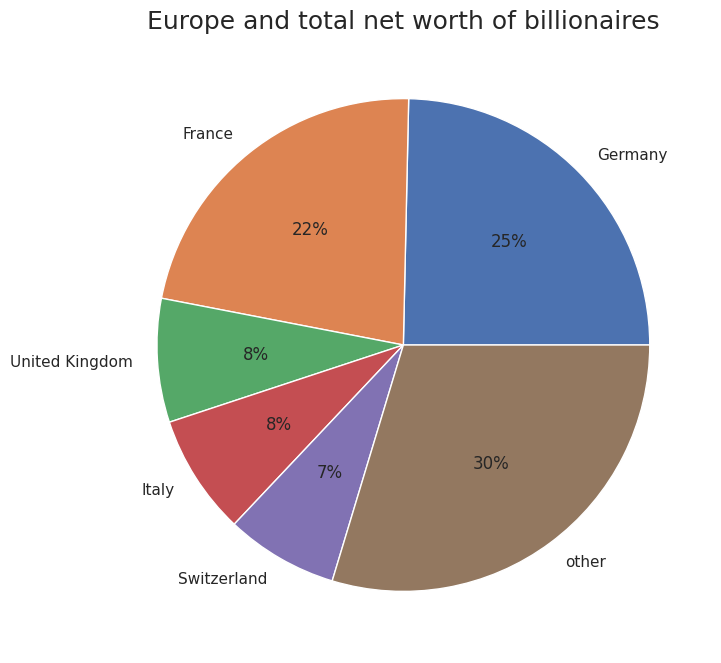

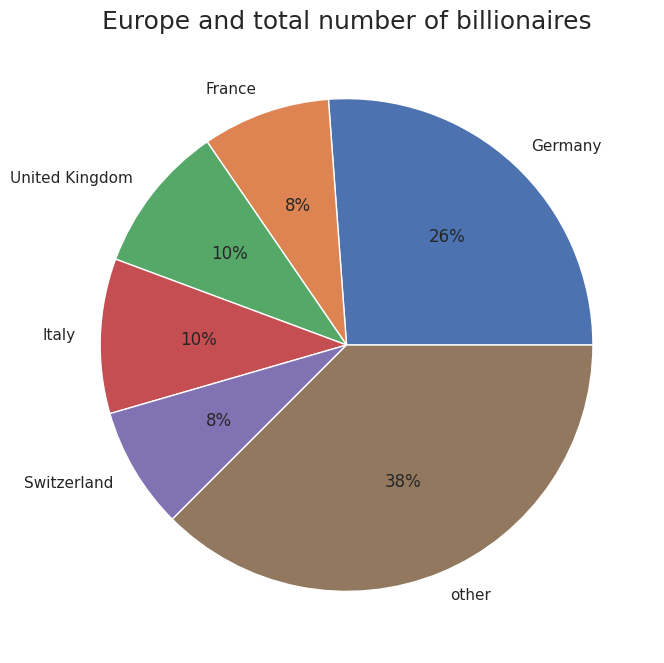

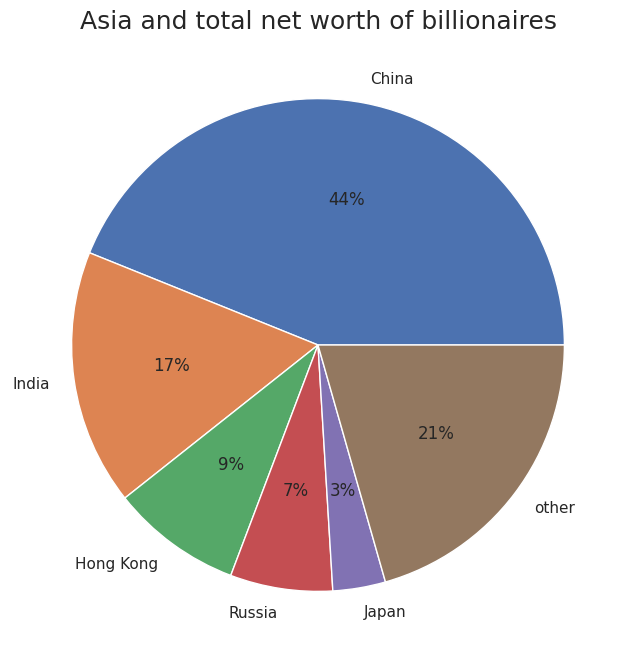

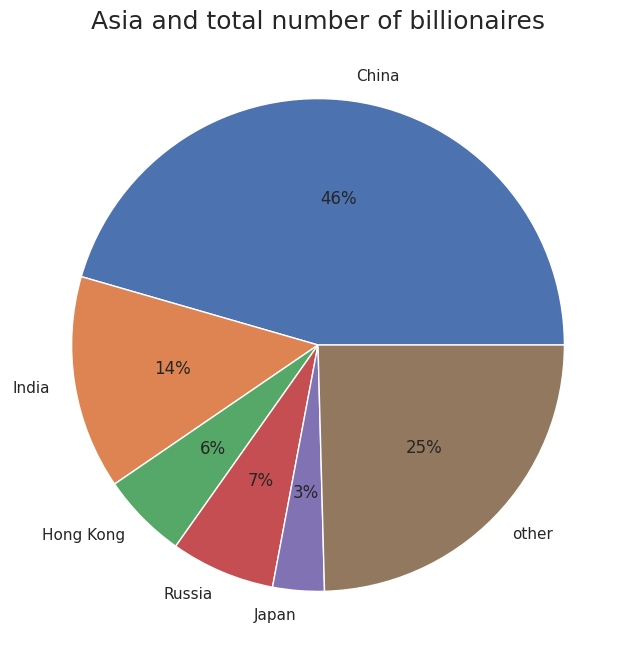

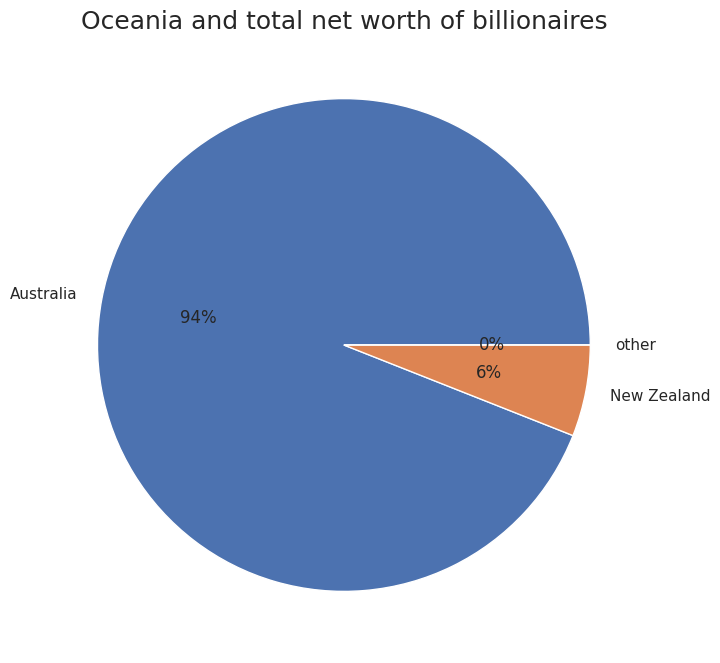

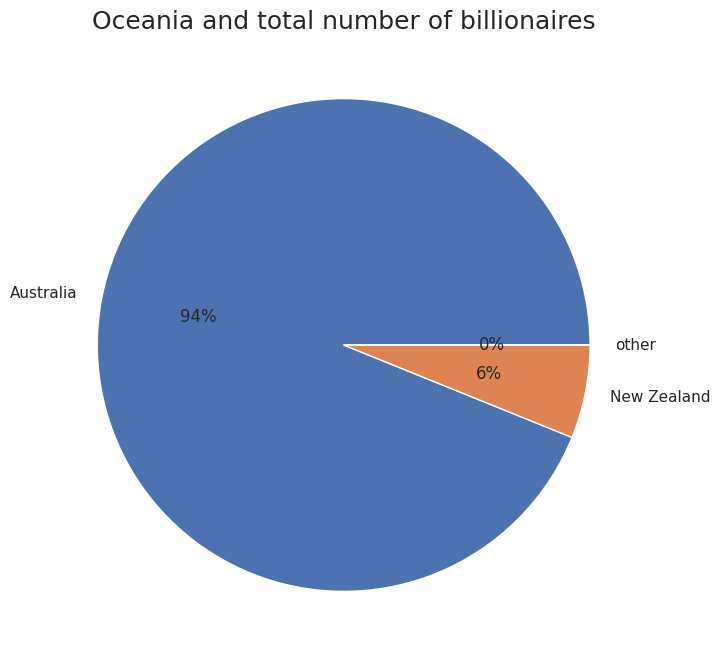

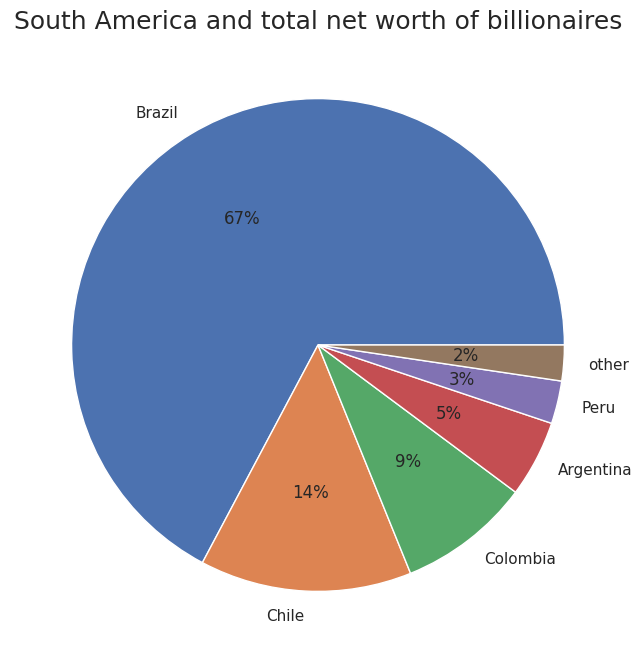

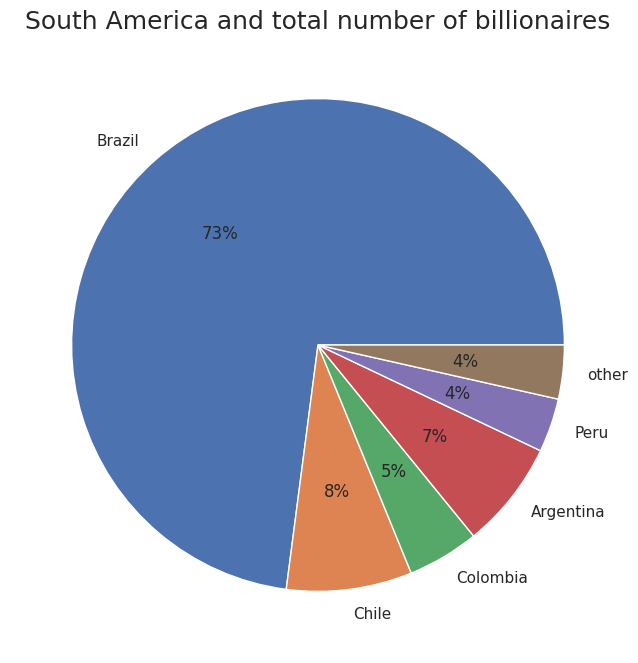

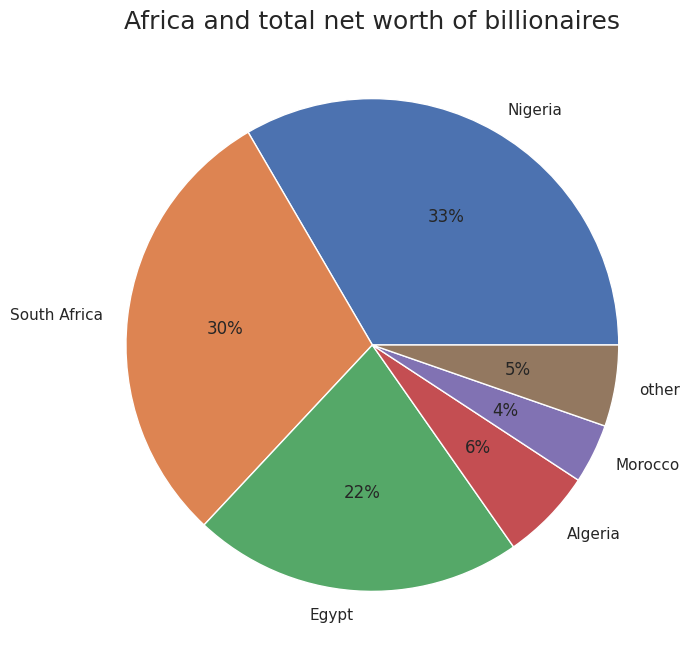

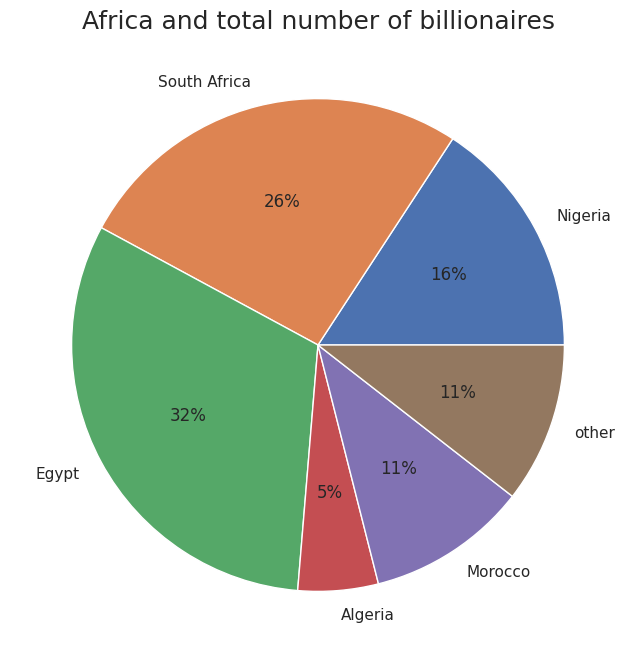

In [114]:
x = df_final[['year','citizenship','net_worth','continents','nth']].copy()
x = x[x['year']==2022]
x = x.drop(columns='year')

for i in x['continents'].unique()[:-1]:
    plt.figure(figsize=(8,8))
    y = x[x['continents']==i]
    y = y.groupby('citizenship',as_index=False).sum()
    z = y.copy()
    z = z.sort_values('net_worth',ascending=False)
    z = z.head(5)
    
    z.reset_index(drop=True,inplace=True)
    
    z.loc[len(z)] = ['other',y['net_worth'].sum() - z['net_worth'].sum(),y['nth'].sum() - z['nth'].sum()]
    plt.title(i+' and total net worth of billionaires',fontdict={'fontsize':18})
    plt.pie(z['net_worth'],labels=z['citizenship'],autopct='%.0f%%')
    plt.show()
    
    plt.figure(figsize=(8,8))
    plt.title(i+' and total number of billionaires',fontdict={'fontsize':18})
    plt.pie(z['nth'],labels=z['citizenship'],autopct='%.0f%%')
    plt.show()
    

## Observations :
<font size = 4>
    <br>
    1) in North America heavily dominates in the number of billionaires and their total wealth.<br><br>
    2) In Europe Genrmay and France hold half of the wealth of billionaires yet the number of billionaires in France are not as much.<br><br>
    3) In Asia India and China dominates and hold half of the billionaires and thier wealth.<br><br>
    4) In Oceania Australia dominates.<br><br>
    5) In South America Brazil heavily dominates holding nearly 2/3 of the billionaires and their wealth.<br><br>
    6) In Africa; Nigeria, South Africa and Egypt account for nearly 3/4 of the billionaires and their wealth.<br><br>

In [115]:
top_10_list = []
for i in list(range(2010,2023,1)):
    x = df[df['year']==i][['rank','name','net_worth','citizenship']].sort_values('net_worth',ascending=False).reset_index(drop=True).head(10)

    print(i,'\n\n',x,'\n\n')
    for i in x['name']:
        if i not in top_10_list:
            top_10_list.append(i)

2010 

    rank                       name  net_worth    citizenship
0   1.0  Carlos Slim Helu & family       53.5         Mexico
1   2.0          William Gates III       53.0  United States
2   3.0             Warren Buffett       47.0  United States
3   4.0              Mukesh Ambani       29.0          India
4   5.0             Lakshmi Mittal       28.7          India
5   6.0           Lawrence Ellison       28.0  United States
6   7.0            Bernard Arnault       27.5         France
7   8.0               Eike Batista       27.0         Brazil
8   9.0             Amancio Ortega       25.0          Spain
9  10.0              Karl Albrecht       23.5        Germany 


2011 

    rank                       name  net_worth    citizenship
0   1.0  Carlos Slim Helu & family       74.0         Mexico
1   2.0                 Bill Gates       56.0  United States
2   3.0             Warren Buffett       50.0  United States
3   4.0            Bernard Arnault       41.0         France
4   5

In [116]:
len(top_10_list)

30

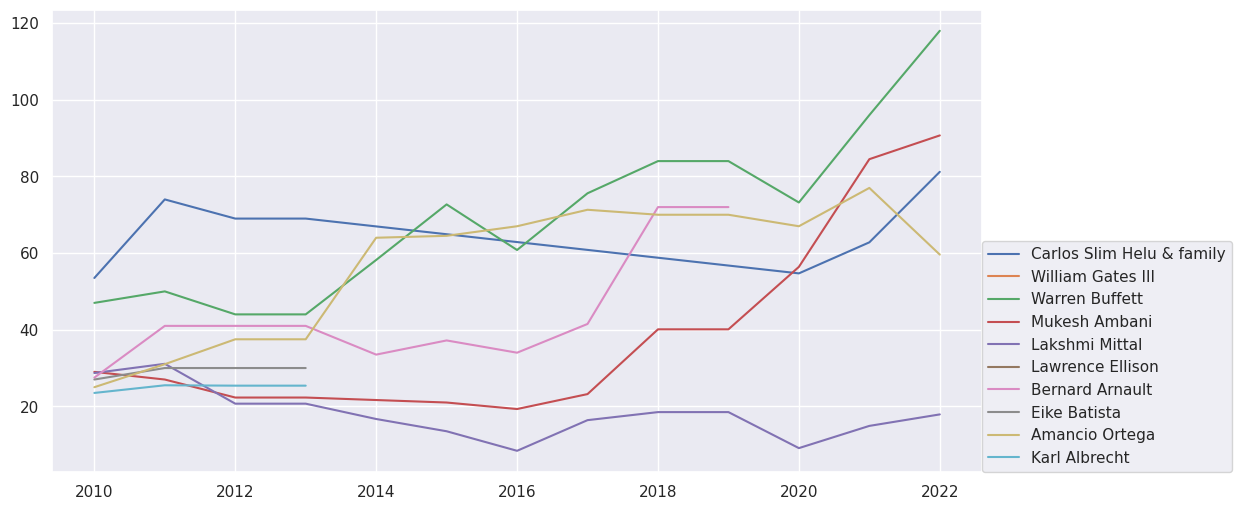

In [117]:
for i in top_10_list[:10]:
    x = df[df['name']==i].sort_values('year')
    plt.plot(x['year'],x['net_worth'],label=i)
    plt.legend(loc=(1,0))
    

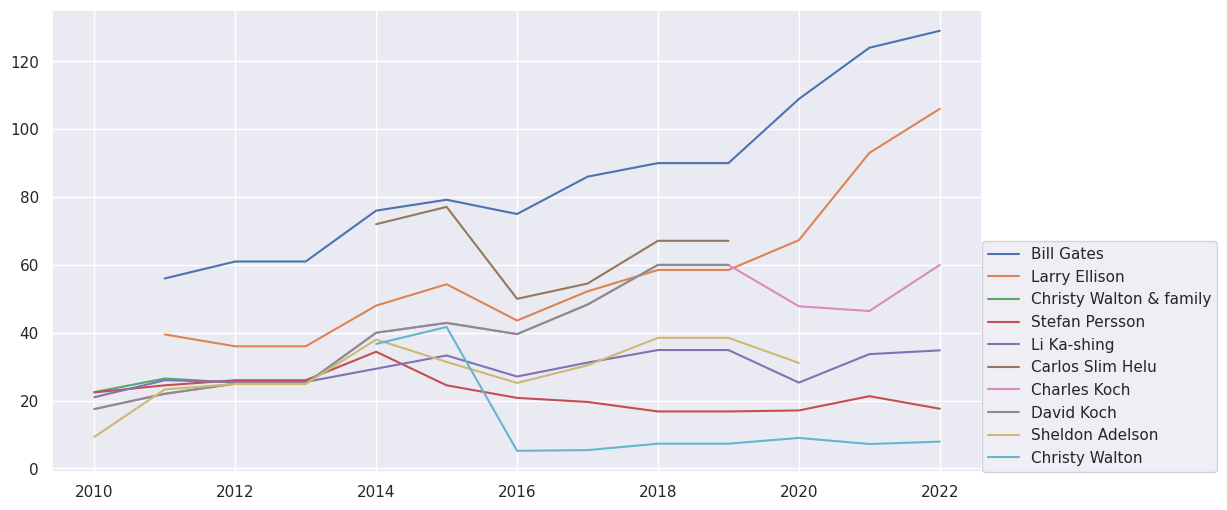

In [118]:
for i in top_10_list[10:20]:
    x = df[df['name']==i].sort_values('year')
    plt.plot(x['year'],x['net_worth'],label=i)
    plt.legend(loc=(1,0))
    

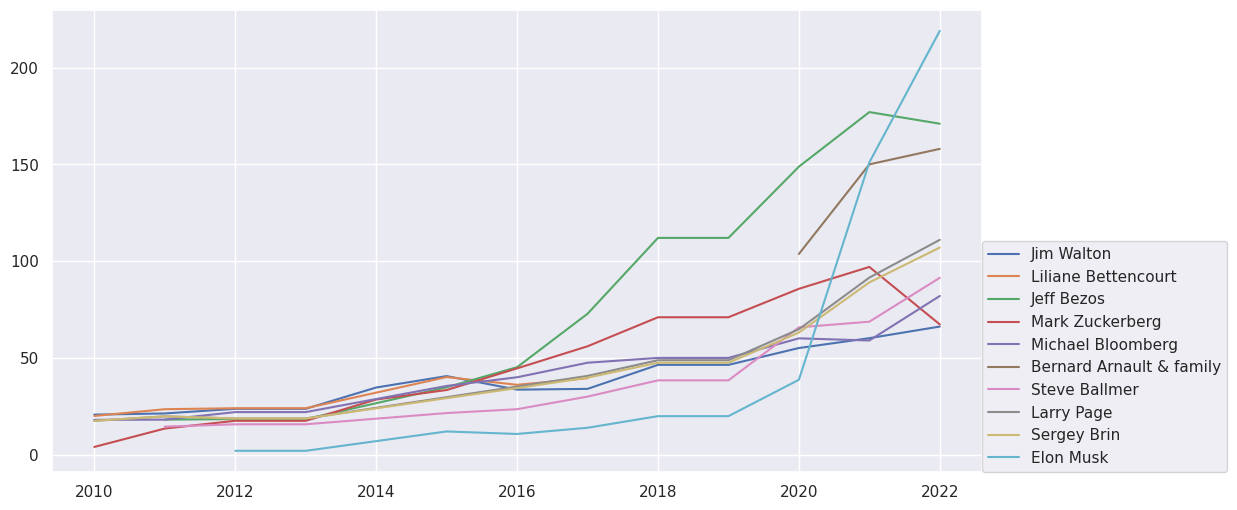

In [119]:
for i in top_10_list[20:]:
    x = df[df['name']==i].sort_values('year')
    plt.plot(x['year'],x['net_worth'],label=i)
    plt.legend(loc=(1,0))
    

In [120]:
n = []
t = []
for name in df['name'].unique():
    x = df[df['name']==name][['year','name','net_worth']].sort_values('year')
    x.reset_index(inplace=True)
    n.append(name)
    t.append(x.loc[len(x)-1]['net_worth'] / x.loc[0]['net_worth'])
    
results = pd.DataFrame({'name':n,'increased_wealth_times':t,}).sort_values('increased_wealth_times',ascending=False)

In [121]:
lines = '''
    select distinct(results.name), df.name as dfname,results.increased_wealth_times, df.citizenship
    from results left join df
    on results.name == df.name
    group by dfname
    order by results.increased_wealth_times
    desc


'''

x = sqldf(lines)
x.drop(columns='dfname',inplace=True)

In [122]:
x.head(30)

name  increased_wealth_times    citizenship
0                 Elon Musk              109.500000  United States
1            Changpeng Zhao               46.428571         Canada
2            Zhong Shanshan               34.578947          China
3                Robin Zeng               23.578947      Hong Kong
4               Qin Yinglin               20.083333          China
5                   Jack Ma               19.000000          China
6                 Wang Xing               18.642857          China
7              Huang Shilin               18.454545          China
8           Mark Zuckerberg               16.825000  United States
9             Gina Rinehart               15.100000      Australia
10           Daniel Gilbert               14.666667  United States
11          Thomas Peterffy               14.357143  United States
12      Mike Cannon-Brookes               13.909091      Australia
13           Scott Farquhar               13.727273      Australia
14              Liu Hanyuan               13.650000          China
15  Jiang Rensheng & family               13.615385          China
16              Dang Yanbao               13.454545          China
17              Lee Man Tat               13.384615      Hong Kong
18                 Li Shufu               13.166667          China
19             Sun Piaoyang               13.153846          China
20             Zhang Yiming               12.500000          China
21         Cyrus Poonawalla               12.150000          India
22              Ken Griffin               11.826087  United States
23           David Duffield               10.750000  United States
24               Ma Huateng               10.333333          China
25            Zhang Bangxin               10.230769          China
26             Seo Jung-Jin                9.916667    South Korea
27                Chen Bang                9.769231          China
28              Robert Pera                9.733333  United States
29               Jeff Bezos                9.447514  United States

<AxesSubplot:xlabel='name', ylabel='increased_wealth_times'>

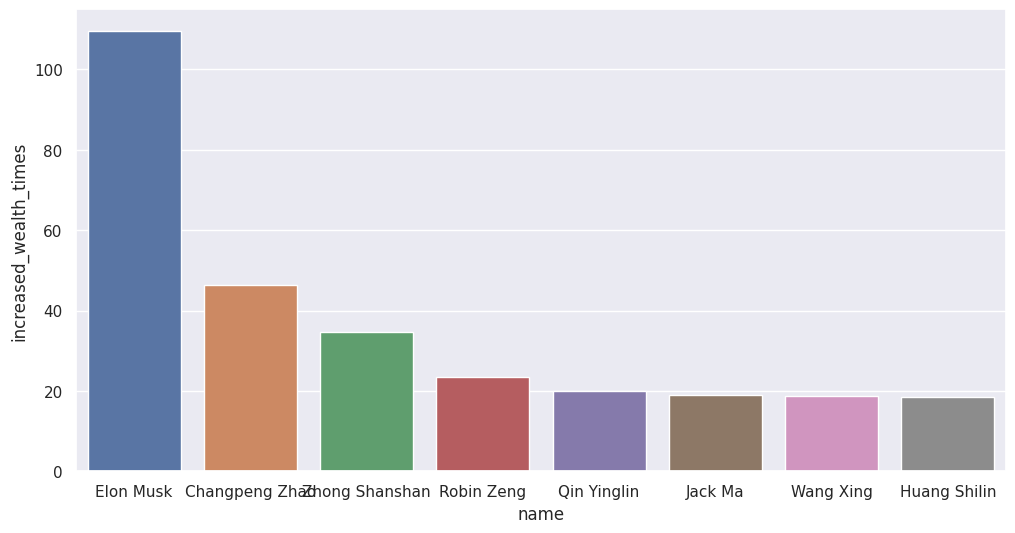

In [123]:
sns.barplot(data=x.head(8),x='name',y='increased_wealth_times')

In [124]:
x['nth'] = 1

<font size = 4>
    <br>
    countries where billionaires have tripled their wealth since they entered in the forbes billionaires' list

In [125]:
y = x[x['increased_wealth_times']>3][['nth','citizenship']].groupby('citizenship',as_index=False).sum().sort_values('nth',ascending=False)
y.reset_index(drop=True,inplace=True)
y

citizenship  nth
0    United States  118
1            China   86
2            India   19
3           France   13
4        Hong Kong   11
5          Germany    9
6           Canada    8
7   United Kingdom    7
8        Australia    6
9      South Korea    6
10       Indonesia    5
11           Japan    5
12          Russia    5
13          Sweden    4
14        Thailand    4
15  Czech Republic    4
16         Nigeria    3
17           Italy    3
18     Switzerland    2
19    South Africa    2
20         Vietnam    2
21      Kazakhstan    2
22          Israel    2
23         Ireland    2
24          Brazil    2
25          Mexico    1
26          Norway    1
27     Philippines    1
28          Poland    1
29        Malaysia    1
30         Finland    1
31         Denmark    1
32         Austria    1
33       Argentina    1

<AxesSubplot:xlabel='citizenship', ylabel='nth'>

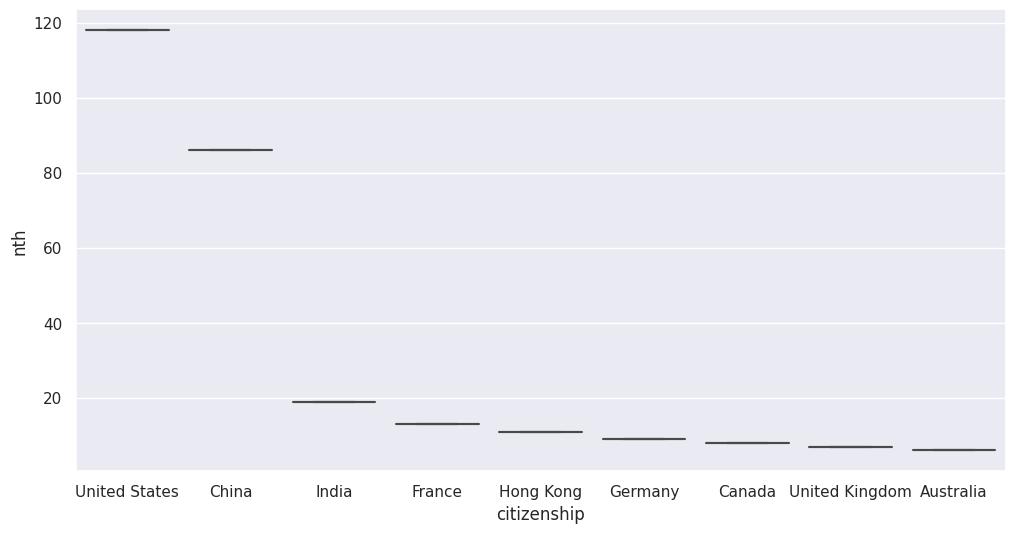

In [126]:
sns.boxplot(data=y.loc[:8],x='citizenship',y='nth')

In [127]:
y = x[x['increased_wealth_times']>3][['increased_wealth_times','citizenship']].groupby('citizenship',as_index=False).mean().sort_values('increased_wealth_times',ascending=False)
y.reset_index(drop=True,inplace=True)
y

citizenship  increased_wealth_times
0           Canada                9.434372
1        Australia                9.085193
2          Ireland                8.636364
3        Hong Kong                7.348866
4          Austria                6.682927
5            China                6.555751
6           Poland                6.200000
7           Israel                5.983333
8      South Korea                5.943953
9          Nigeria                5.738889
10  United Kingdom                5.680305
11   United States                5.591822
12       Indonesia                5.498889
13          Brazil                5.345833
14     Philippines                5.187500
15           Italy                5.026984
16          Russia                4.973736
17           India                4.929574
18         Denmark                4.800000
19         Germany                4.570907
20           Japan                4.317478
21        Thailand                4.294403
22     Switzerland                4.208333
23          Norway                4.090909
24          Sweden                4.028959
25          France                3.977934
26  Czech Republic                3.958681
27       Argentina                3.900000
28    South Africa                3.684783
29         Vietnam                3.537500
30      Kazakhstan                3.454545
31         Finland                3.307692
32          Mexico                3.175258
33        Malaysia                3.117647

<AxesSubplot:xlabel='citizenship', ylabel='increased_wealth_times'>

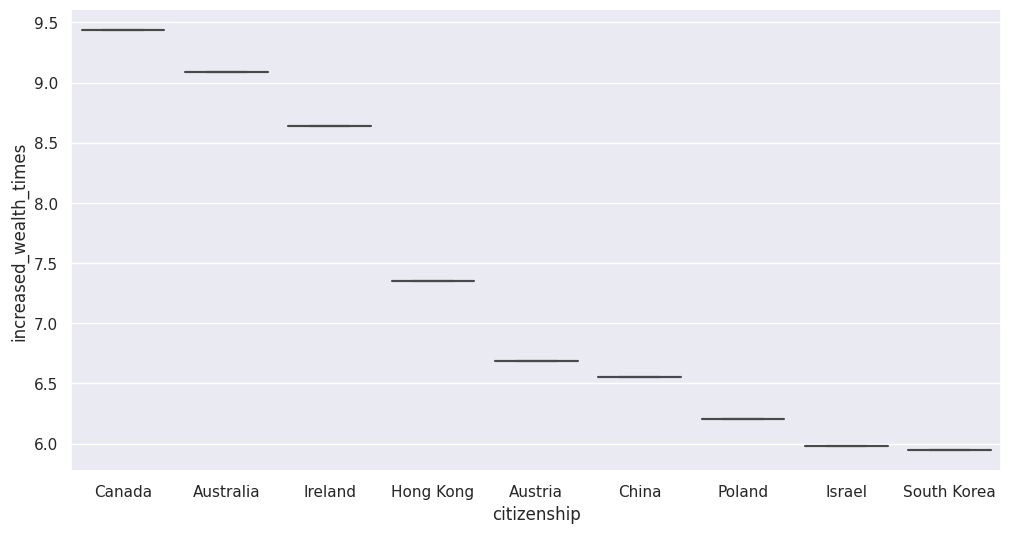

In [128]:
sns.boxplot(data=y.loc[:8],x='citizenship',y='increased_wealth_times')

In [129]:
df[df['name']=='Elon Musk'][['year','name','net_worth','rank']]

year       name  net_worth   rank
2885   2012.0  Elon Musk        2.0  665.0
4111   2013.0  Elon Musk        2.0  665.0
5476   2015.0  Elon Musk       12.0  100.0
7295   2016.0  Elon Musk       10.7   94.0
9093   2017.0  Elon Musk       13.9   80.0
11110  2018.0  Elon Musk       19.9   54.0
13318  2019.0  Elon Musk       19.9   54.0
15496  2020.0  Elon Musk       38.7   24.0
17688  2021.0  Elon Musk      151.0    2.0
20442  2022.0  Elon Musk      219.0    1.0

## Observations
<font size = 4>
    <br>
    1) <b>Elon Musk</b> has to be the star of billionaires list, as he has increased his wealth by 109 times since his first arrival on the list in 2012. He has climbed the ladder by becoming the richest man in the world from 665th richest man in just 10 years!<br><br>
    2) Again<b> US and China</b> leads in number of Billionaires who have tripled their wealth.<br><br>
    3) Interestingly, if we take the mean of how many times billionaires have increased their wealth, there are countries like <b>Canada, Australia, Ireland, Hong Kong </b>which leads unde that criteria. But then they do not churn out as many billionaires like US and China.
                                                                                                   

In [130]:
print('Source Nunique :',df['source'].nunique(),'\n\n' ,df['source'].value_counts().head(20),'\n\ntotal dataset size : ', len(df))

Source Nunique : 1724 

 real estate         1523
investments          805
diversified          761
pharmaceuticals      695
retail               459
hedge funds          412
banking              350
software             320
consumer goods       246
private equity       235
chemicals            220
finance              203
construction         186
media                170
telecom              170
manufacturing        164
auto parts           148
electronics          143
mining               134
money management     128
Name: source, dtype: int64 

total dataset size :  23110


<font size = 5>
    the label source contains 1724 unique categorization and they are very widely spread. 

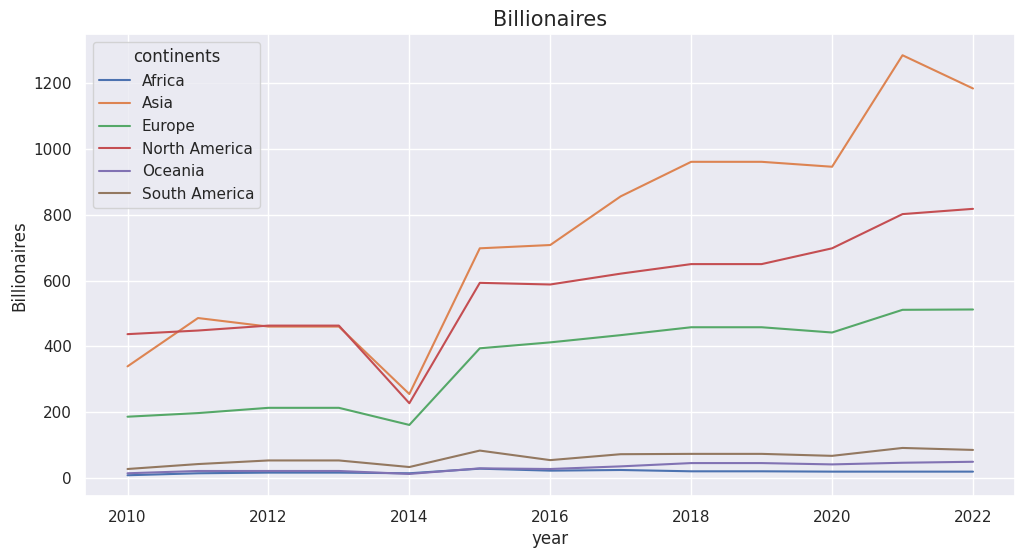

Text(0.5, 1.0, 'net_worth')

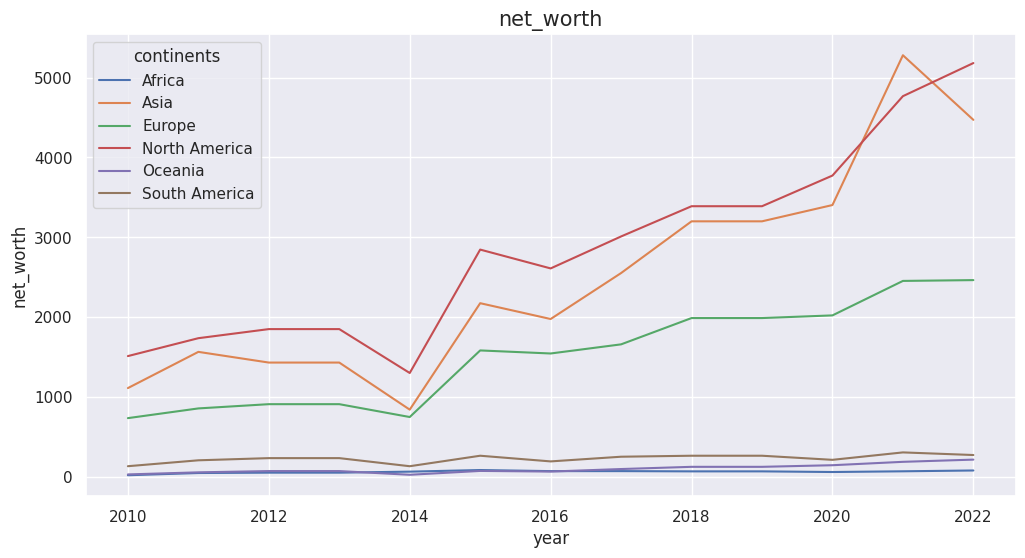

In [131]:
x = df_final[['year','continents','net_worth','nth']].groupby(['continents','year'],as_index=False).sum()
sns.lineplot(data=x,x='year',y='nth',hue='continents')
plt.title('Billionaires',fontdict={'fontsize':15})
plt.ylabel('Billionaires')
plt.show()
sns.lineplot(data=x,x='year',y='net_worth',hue='continents')
plt.title('net_worth',fontdict={'fontsize':15})

## observations
<font size = 4>
    <br>
    considering the continents Asia and North America are fastest growing regions for billionaires and their wealth. Effectively it showcases the rise of Asia over the years.<br><br>

<AxesSubplot:xlabel='net_worth', ylabel='billionaires'>

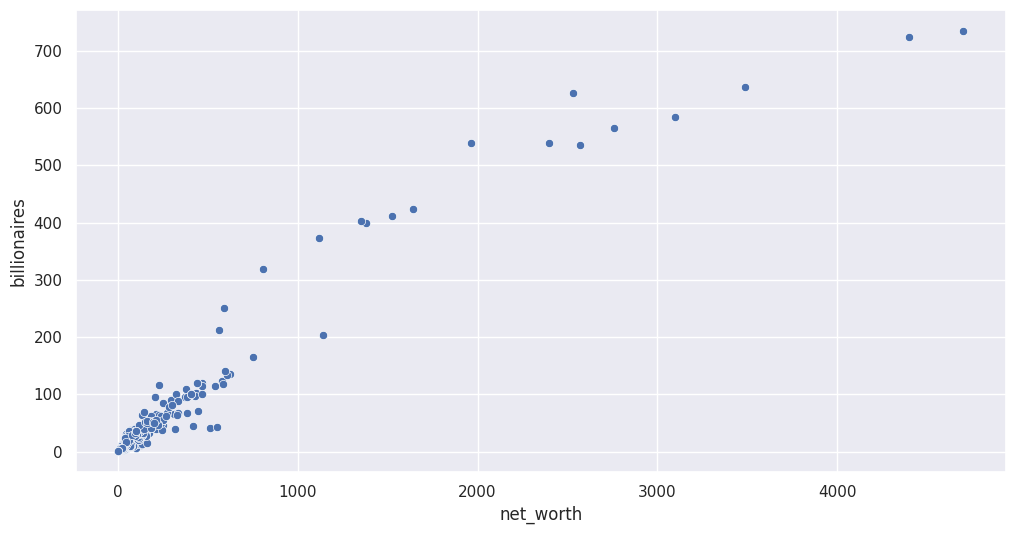

In [132]:
sns.scatterplot(data=countries_df,x='net_worth',y='billionaires')

## observations
<font size = 4>
    <br>
    1) Billionaires and their combined Net worth have positive corelation.<br>
    2) That means a country cannot have few billionaires and have most net worth.<br>
    3) In order to have more net worth, a country should have more billionaires<br><br><br>

In [133]:
india = countries_df[countries_df['country']=='India']
china = countries_df[countries_df['country']=='China']

def india_china_plot(x,y):
    plt.scatter(x=india[x],y=india[y],label='india')
    plt.scatter(x=china[x],y=china[y],label='china')
    plt.legend()

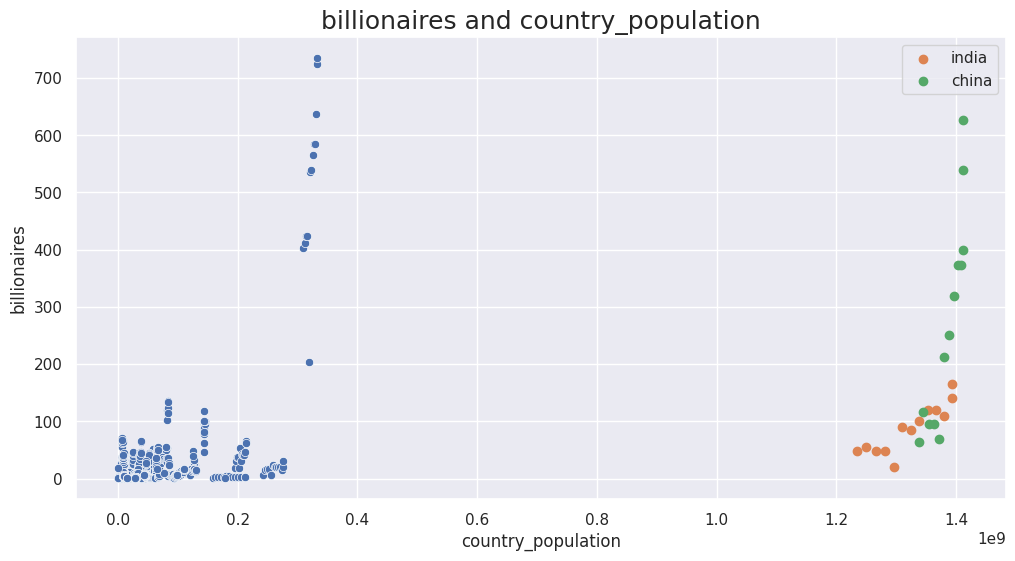

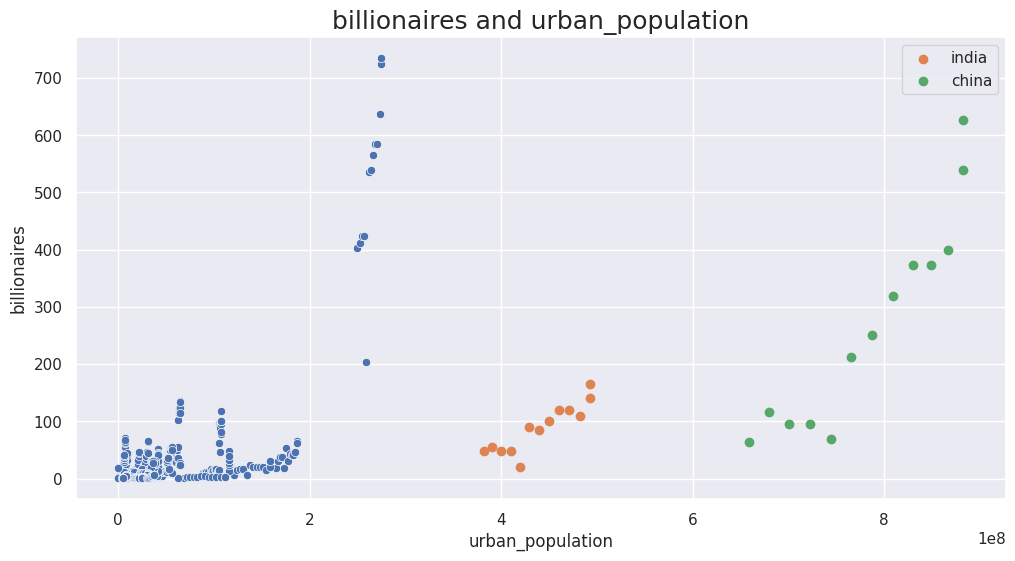

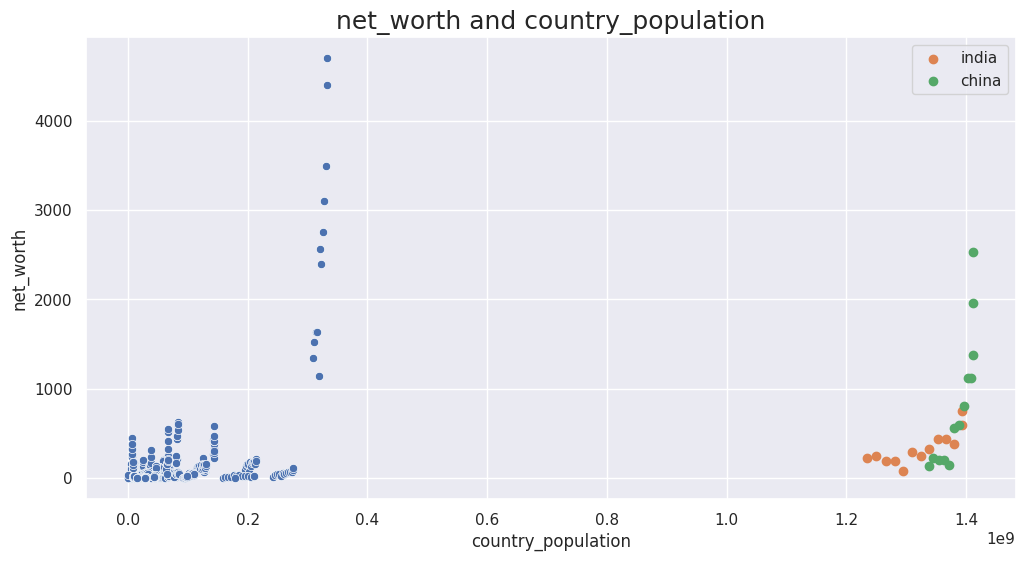

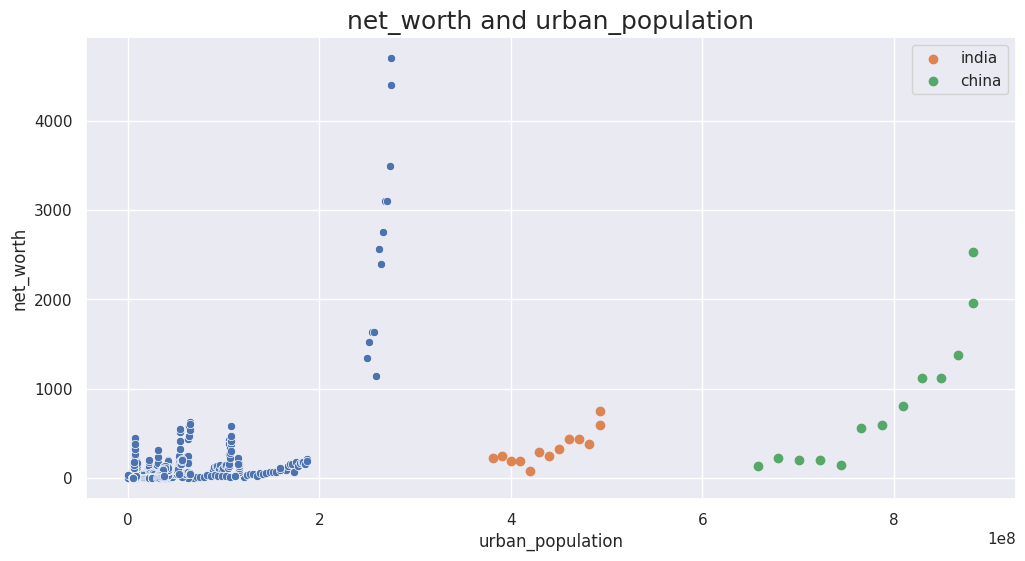

In [134]:
for ii in ['billionaires','net_worth']:
    for i in ['country_population','urban_population']:
        sns.scatterplot(data=countries_df,x=i,y=ii)
        plt.title(ii+' and '+i,fontdict={'fontsize':18})
        india_china_plot(i,ii)
        plt.show()

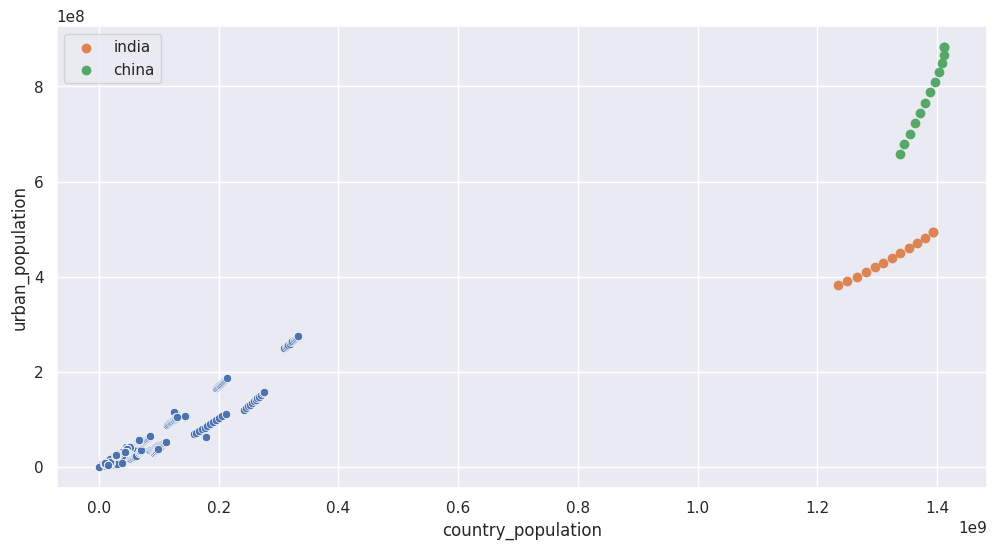

In [135]:
sns.scatterplot(data=countries_df,x='country_population',y='urban_population')

india_china_plot('country_population','urban_population')

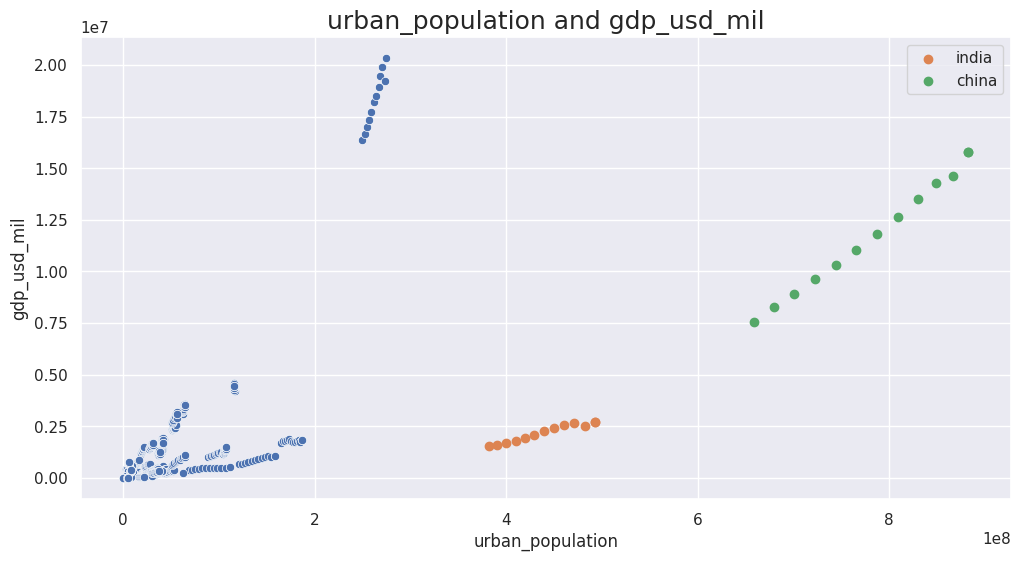

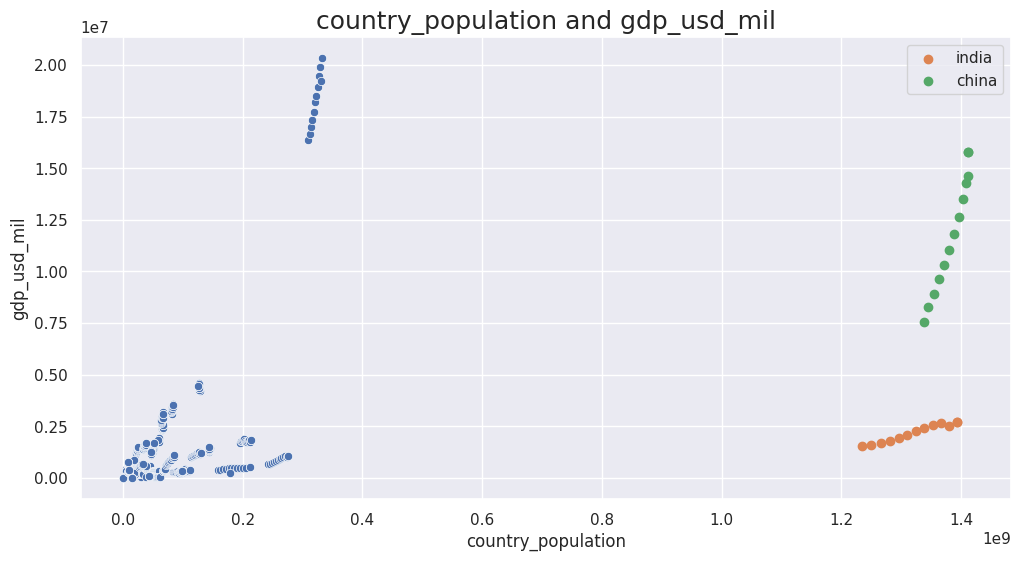

In [136]:
for i in ['urban_population','country_population']:
    sns.scatterplot(data=countries_df,x=i,y='gdp_usd_mil')
    plt.title(i+' and gdp_usd_mil',fontdict={'fontsize':18})
    india_china_plot(x=i,y='gdp_usd_mil')
    plt.show()

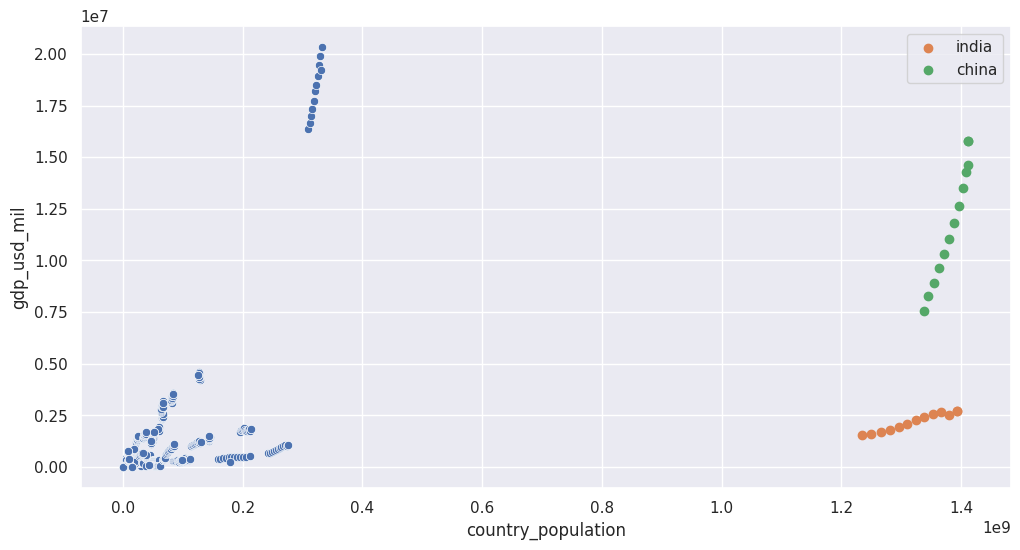

In [137]:
sns.scatterplot(data=countries_df,x='country_population',y='gdp_usd_mil')
india_china_plot(x='country_population',y='gdp_usd_mil')

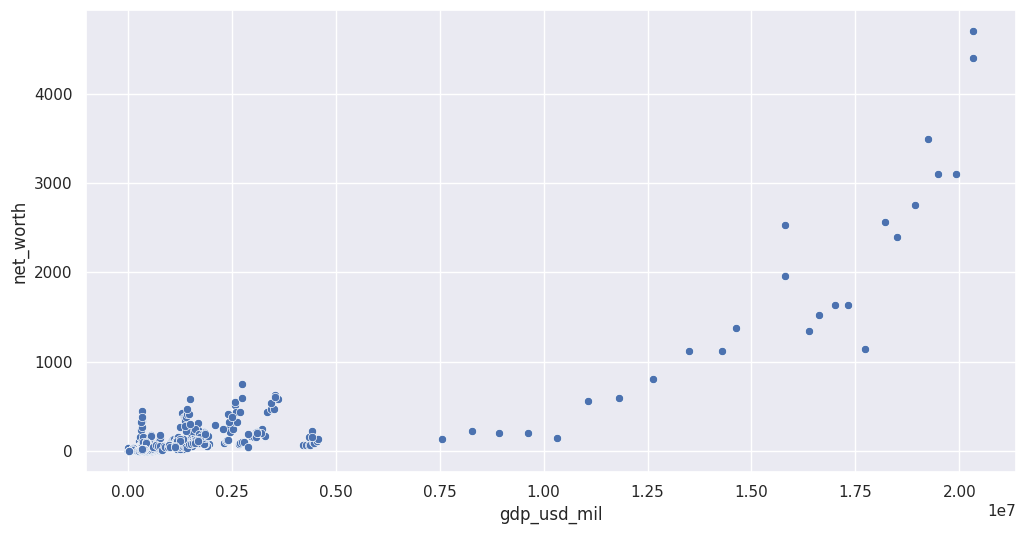

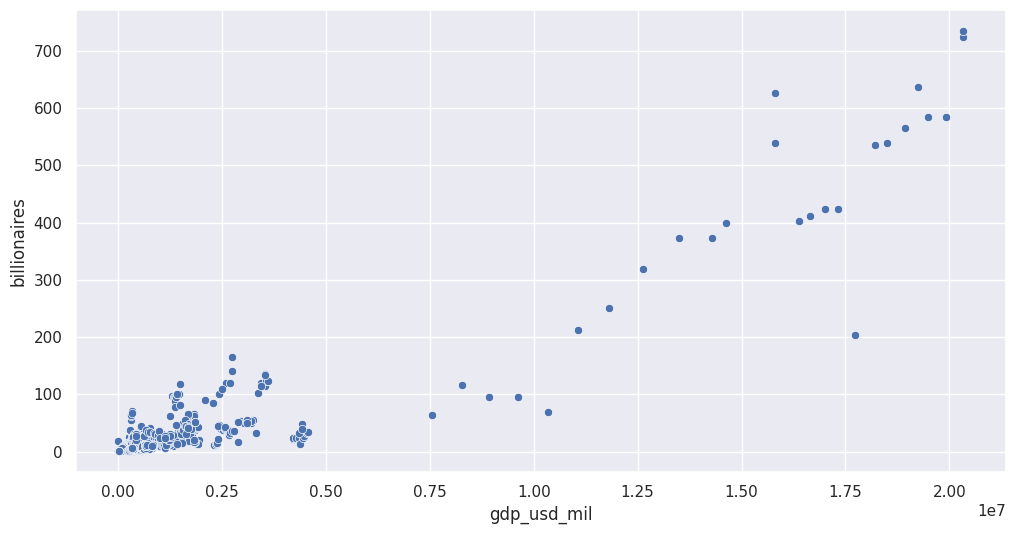

In [138]:
for i in ['net_worth','billionaires']:
    sns.scatterplot(data=countries_df,x='gdp_usd_mil',y=i)
    plt.show()

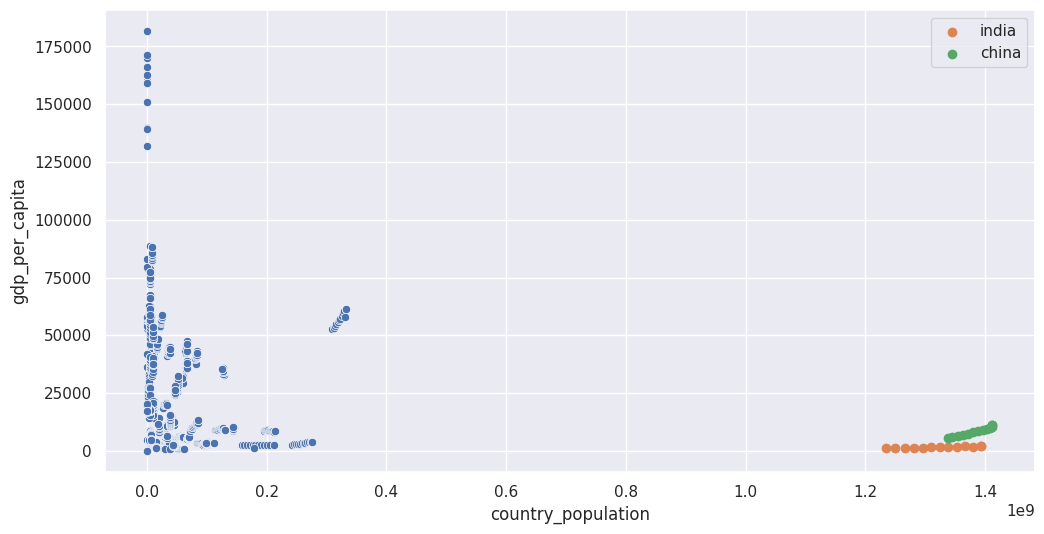

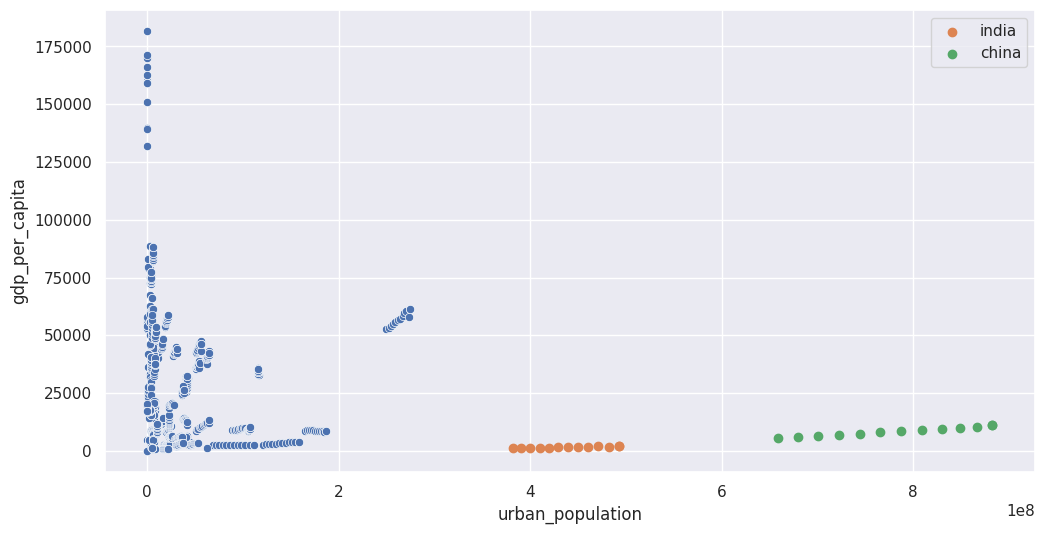

In [139]:
for i in ['country_population','urban_population']:
    sns.scatterplot(data=countries_df,x=i,y='gdp_per_capita')
    india_china_plot(x=i,y='gdp_per_capita')
    plt.show()

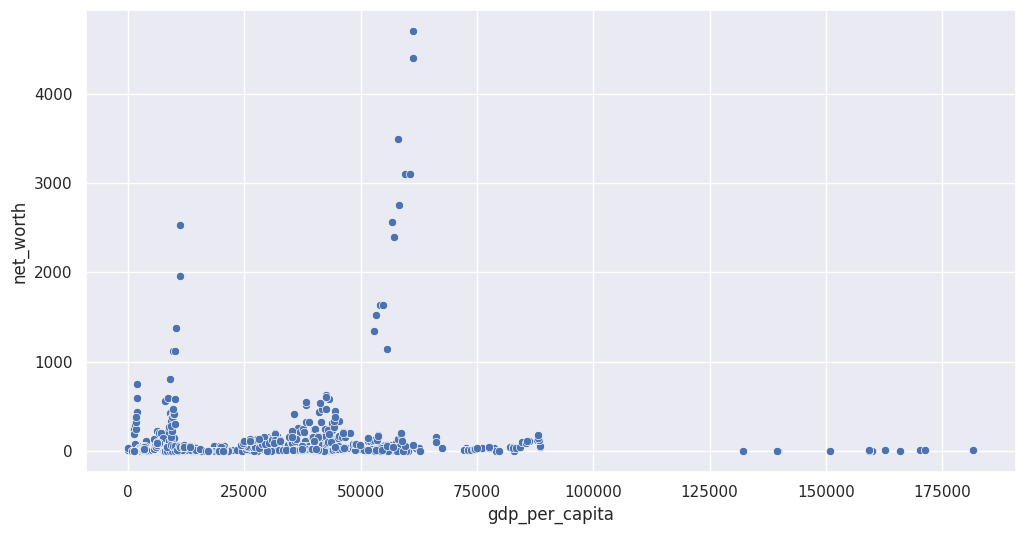

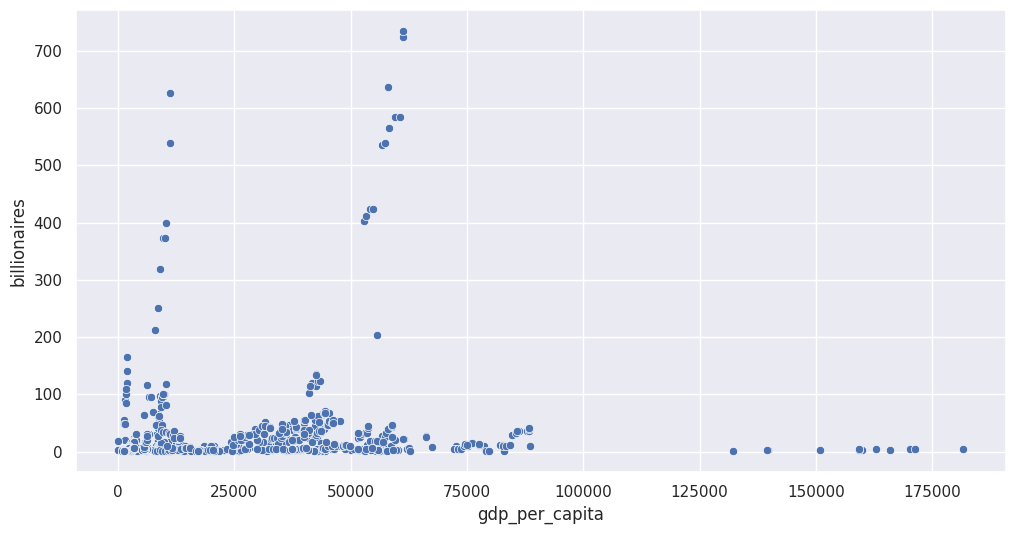

In [140]:
for i in ['net_worth','billionaires']:
    sns.scatterplot(data=countries_df,x='gdp_per_capita',y=i)
    plt.show()

## observations
<font size = 4>
    <br>
    1) when we take any features that have the mix of population, then the results are skewed by the populations of India and China. <br><br>
    2) one reason behind it might be that a country is a vague concept. A better metric would be, to devide the world in the boxes of longitude and latitude and then calculating where the billionaires, population and other features are concentrated. <br><br>
    3) Urban population and the overall population of a country has a positive correlationship. big cities lead to higher population for the country.<br><br>
    4) Gdp and the urban population has a positive correlationship. It can also mean that more population plays an importent and positive role in the gdp of a country. This explaination becomes more clearer when we observe changes within a country. For example in the case of both India and China we see that their population and gdp is increasing simulteniously.<br><br>
    5) within a country, at least, there seems to be a correlationship between <b>population and billionaires </b> although this correlationship is not concrete enough to see the effect accross the board.<br><br>
    6) Although gdp per capita and billionaires and their wealth have little to no correlationship, <b> GDP and billionaires and their wealth, on the other hand, have high correlationship. </b> <br><br>

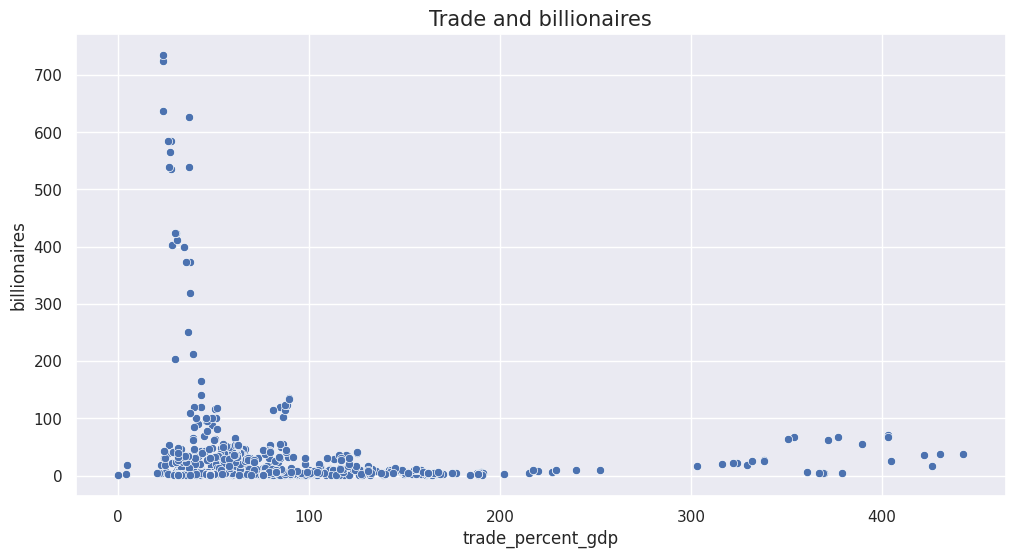

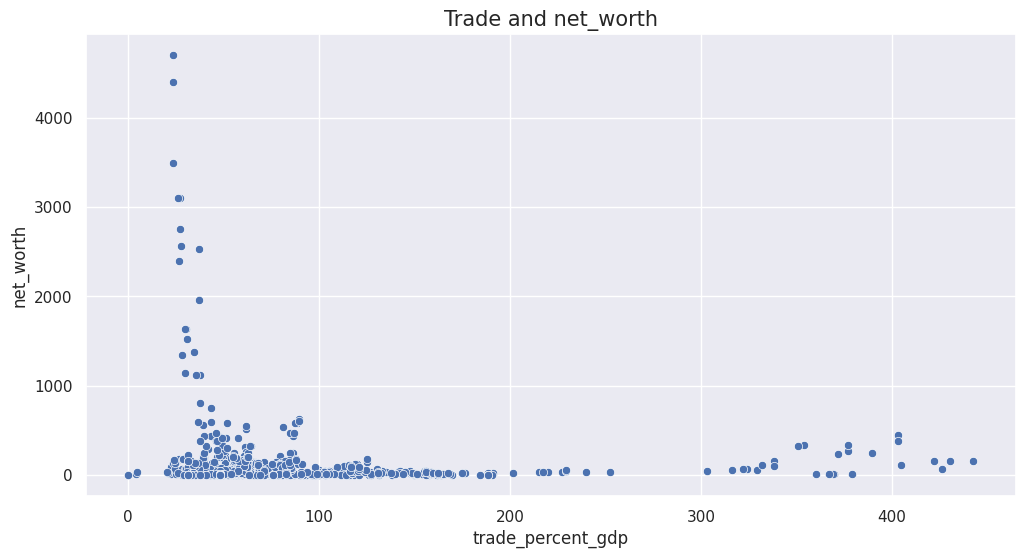

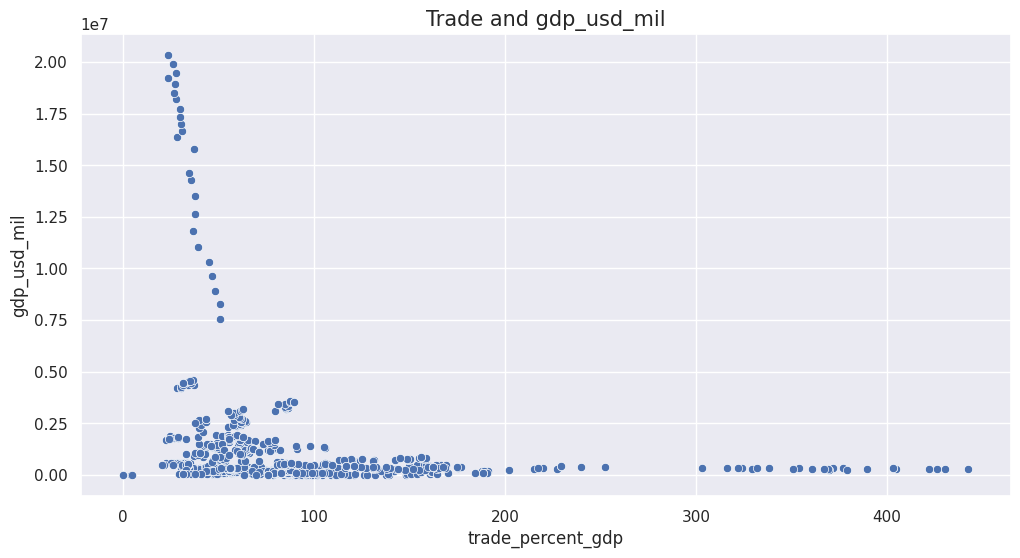

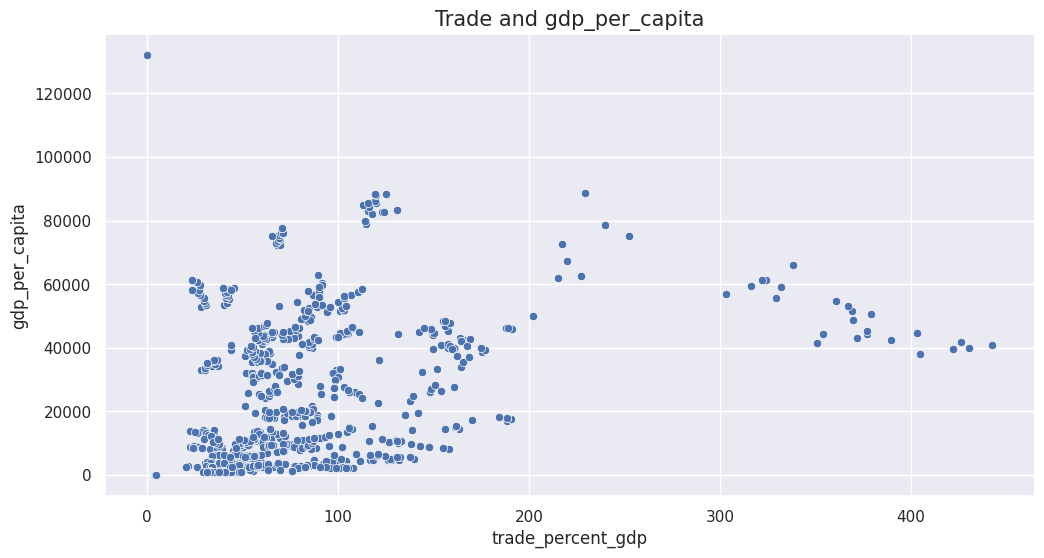

In [141]:
for i in ['billionaires','net_worth','gdp_usd_mil','gdp_per_capita']:
    plt.title('Trade and '+i,fontdict={'fontsize':15})
    sns.scatterplot(data=countries_df,x='trade_percent_gdp',y=i)
    plt.show()

## observations
<font size = 4>
    <br>
    1) Trade as a percentage of Gdp does not correlate with gdp, billionaires nor their wealth.<br>
    2) The only feature that correlates is Gdp per captia.
    <br><br>

In [142]:
countries_df[['co2_emmissions','country']].groupby('country',as_index=False).sum().sort_values('co2_emmissions',ascending=False).head(10)

country  co2_emmissions
12          China    1.554642e+08
78  United States    7.911903e+07
31          India    4.026572e+07
60         Russia    3.085906e+07
36          Japan    1.616767e+07
8          Brazil    1.376475e+07
32      Indonesia    1.163467e+07
24        Germany    1.063384e+07
10         Canada    9.264080e+06
65    South Korea    8.920770e+06

In [143]:
india = countries_df[countries_df['country']=='India']
United_States = countries_df[countries_df['country']=='United States']
China = countries_df[countries_df['country']=='China']

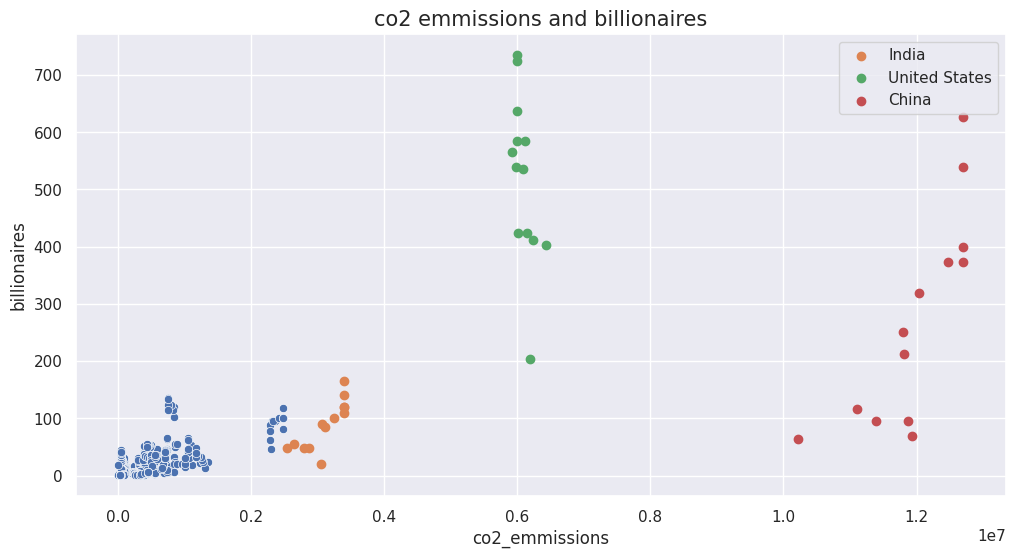

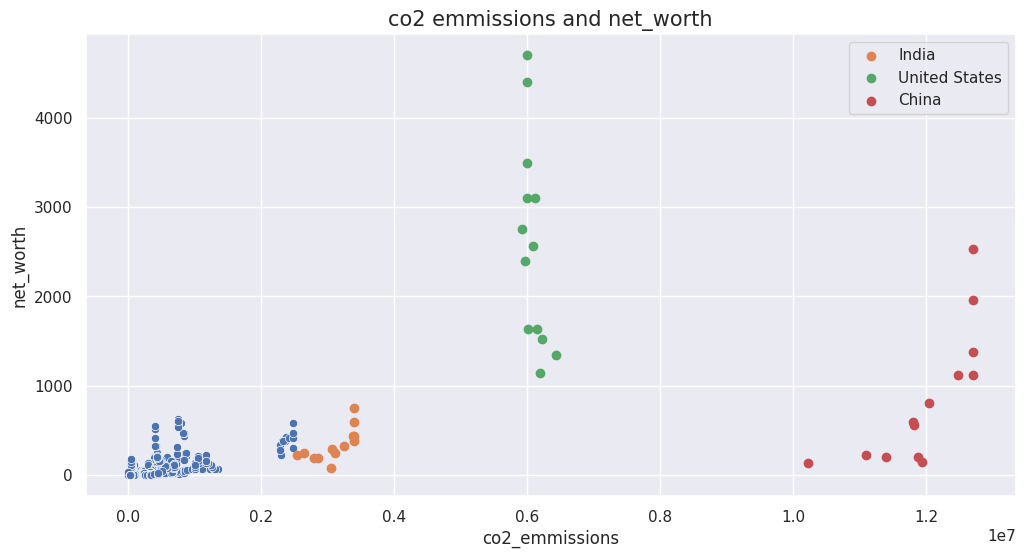

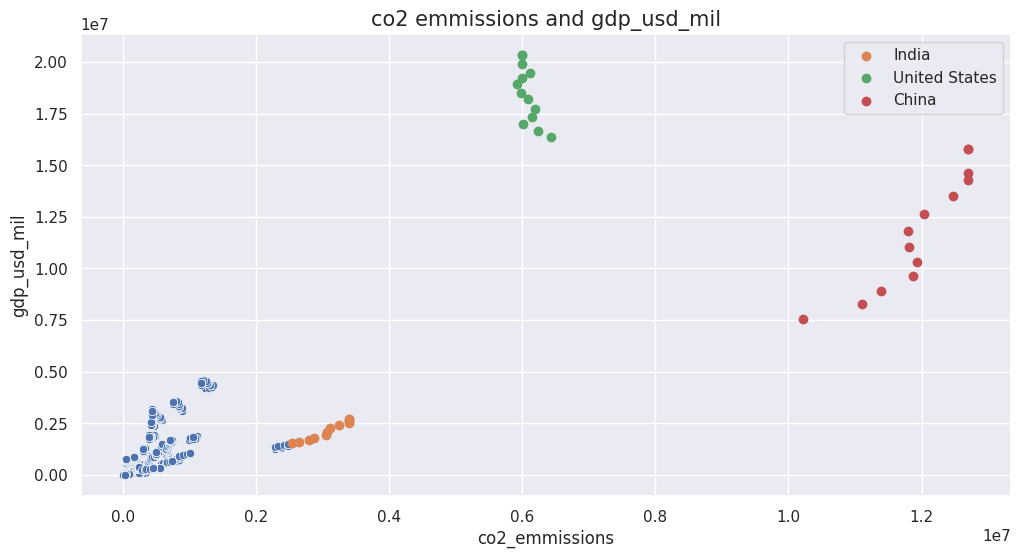

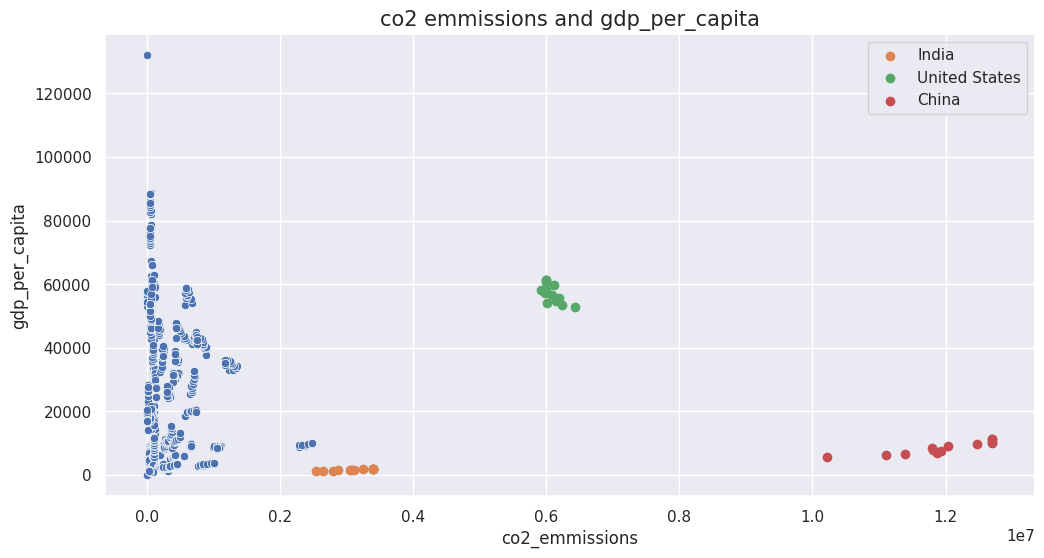

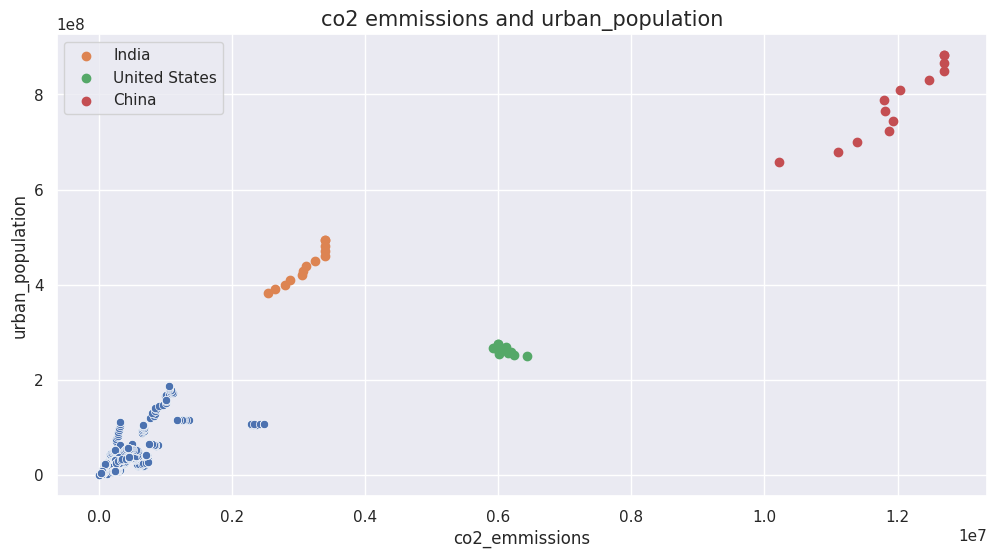

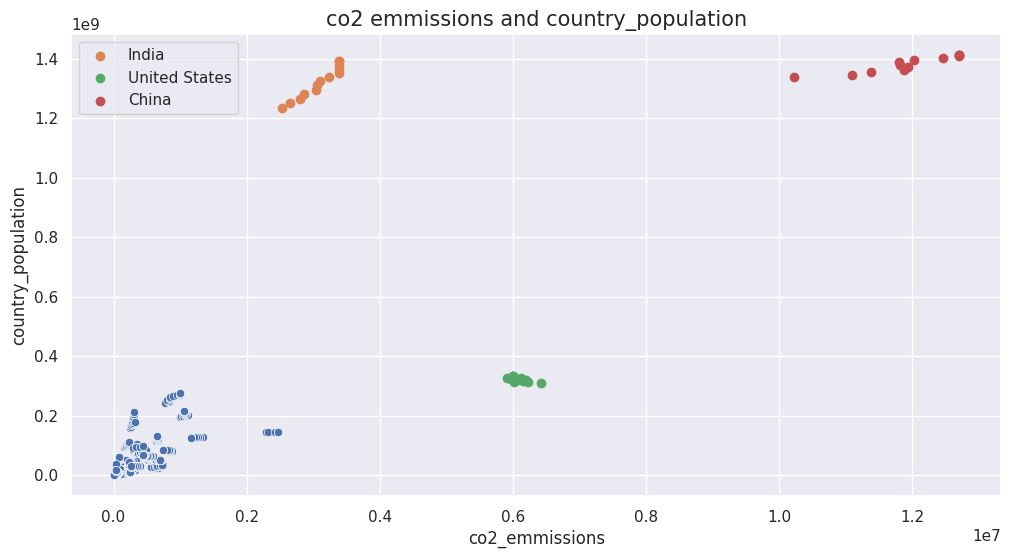

In [144]:
for i in ['billionaires','net_worth','gdp_usd_mil','gdp_per_capita','urban_population','country_population']:
    plt.title('co2 emmissions and '+i,fontdict={'fontsize':15})
    sns.scatterplot(data=countries_df,x='co2_emmissions',y=i)
    plt.scatter(india['co2_emmissions'],y=india[i],label='India')
    plt.scatter(United_States['co2_emmissions'],y=United_States[i],label='United States')
    plt.scatter(China['co2_emmissions'],y=China[i],label='China')
    plt.legend()
    plt.show()

## observations :
<font size = 4>
    <br>
    1) developed countries like US increase their GDP without increasing their co2 emmissions. On the other hand developing countries like India and China they increase their GDP and also increase co2 emmissions.<br><br>
    2) a reason behind this phenomenon is that rich countries can easily bear the cost of renewable energy, whereas developing countries find it hard to do so, and rely mostly on fossil fuels.

<AxesSubplot:>

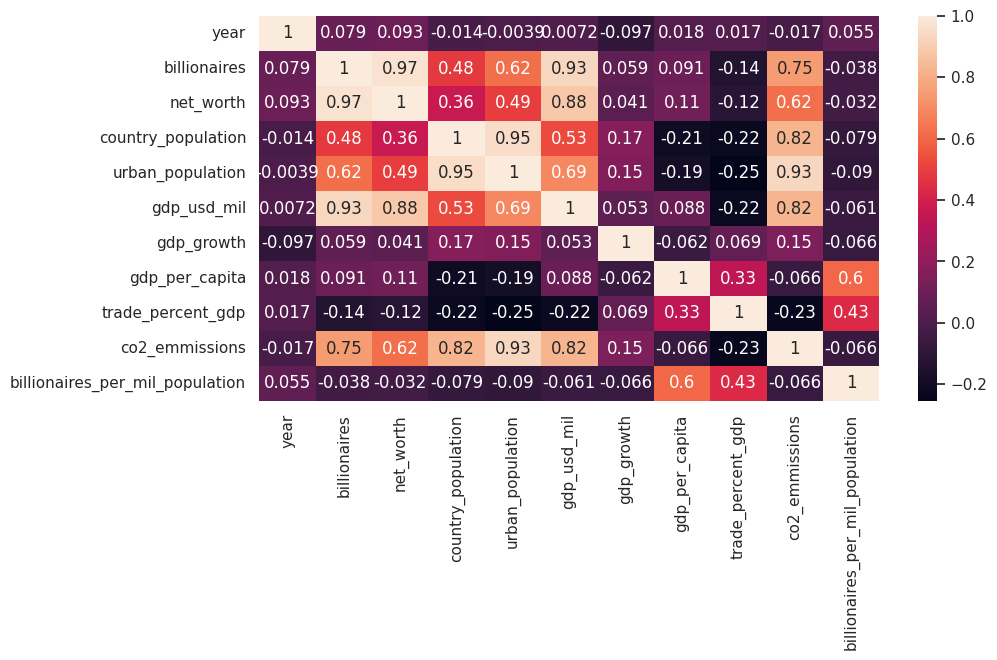

In [145]:
sns.set(rc={'figure.figsize':(10,5)})
sns.heatmap(countries_df.corr(),annot=True)

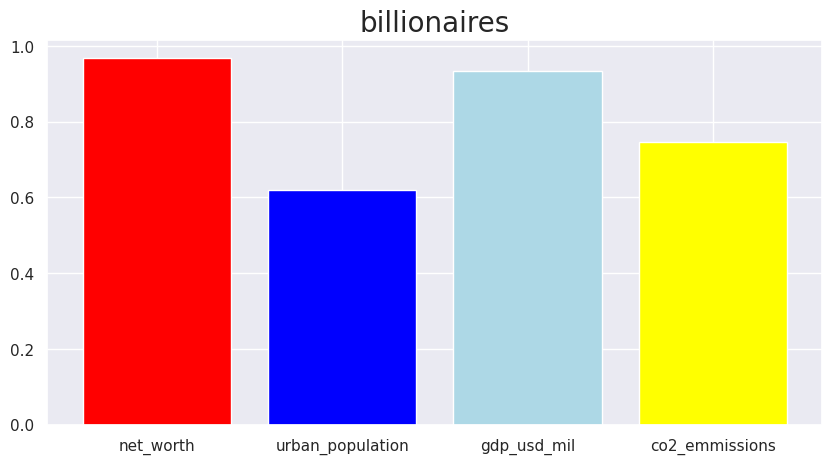

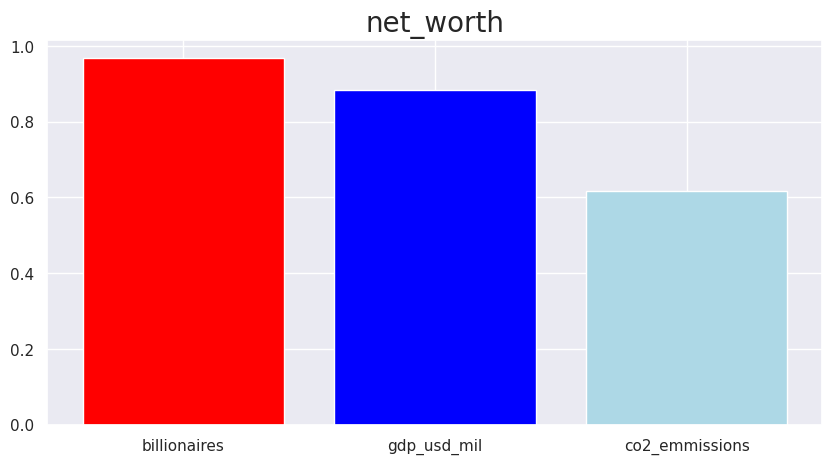

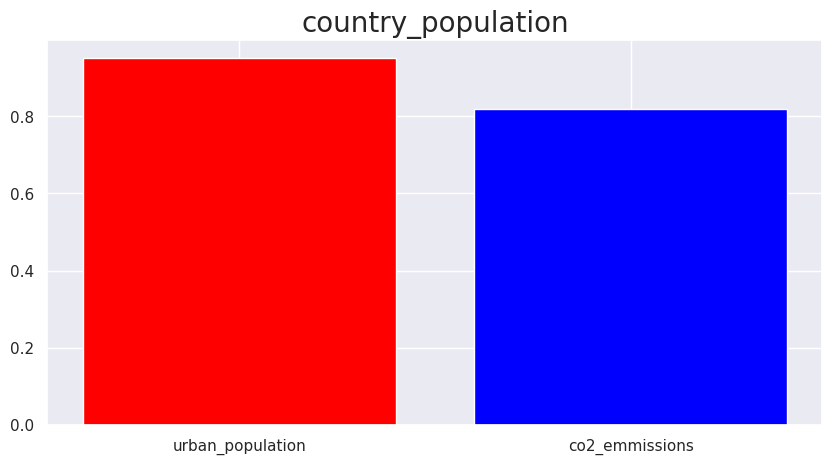

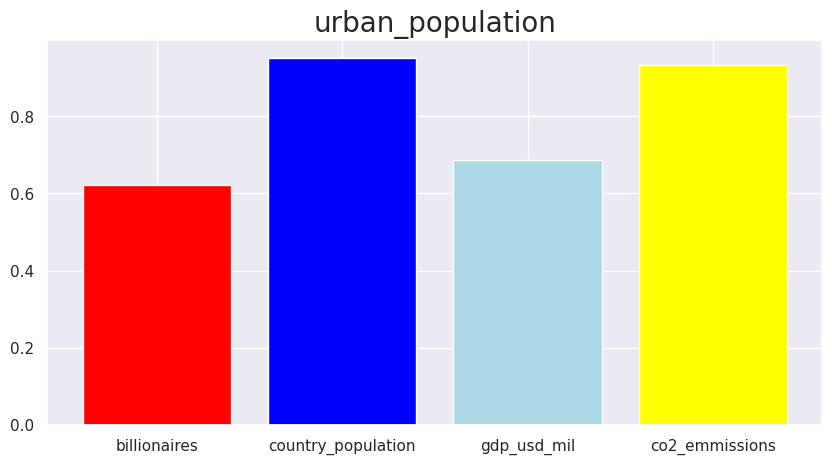

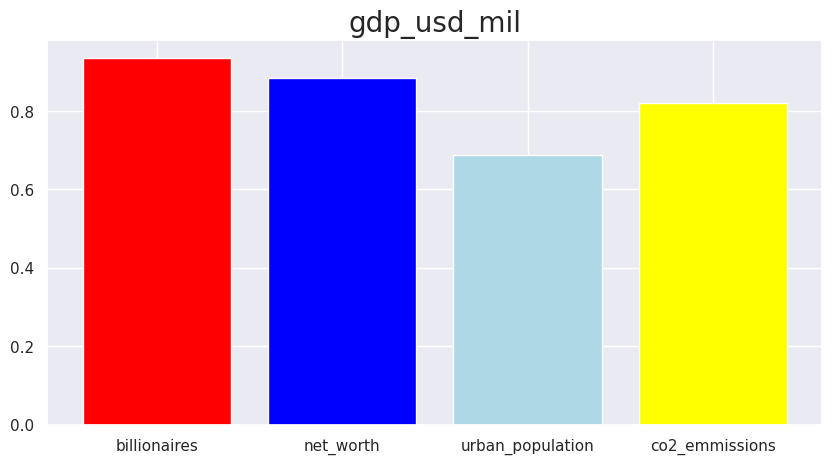

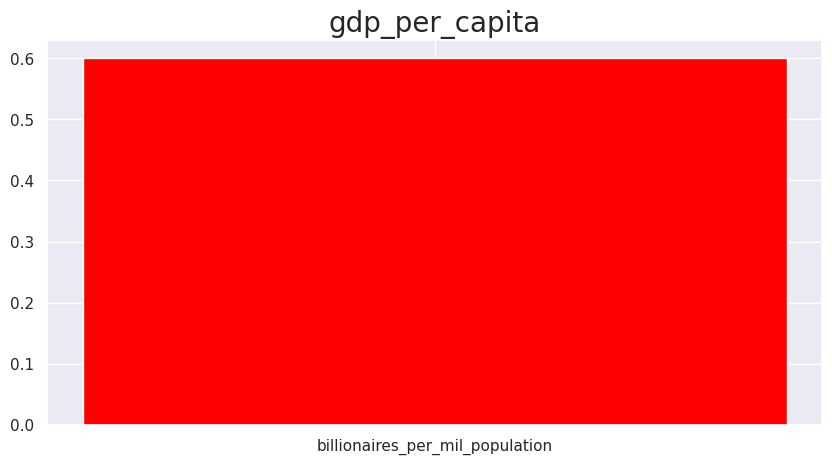

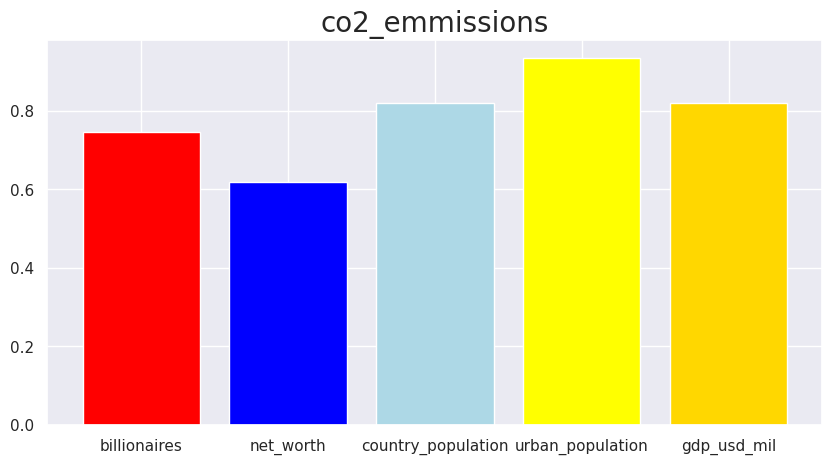

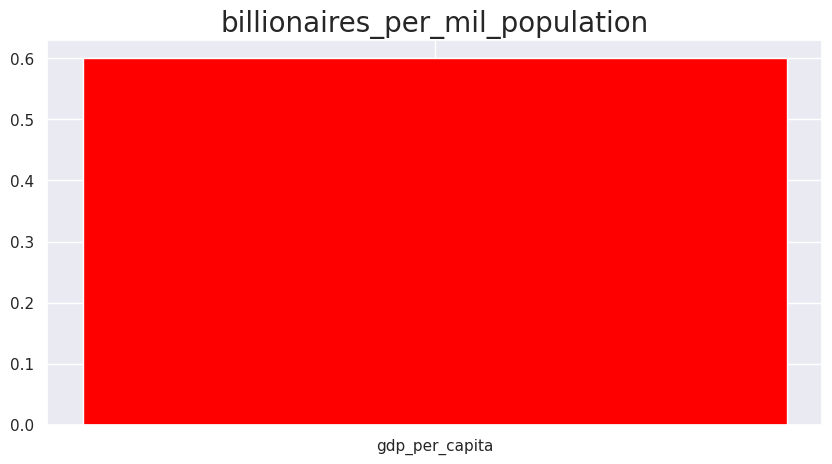

In [146]:
x = countries_df.corr()
y = list(x.index)
for col in x.columns:
    # print(col,'\n')
    o = []
    p = []
    for i,n in zip(x[col],y):
        if (i > 0.59 or i < -0.59) and col!=n:
            z = len(n)-15
            # print(n,' '*z,':   ',i)
            o.append(n)
            p.append(i)
    if len(o)>0:
        plt.title(col,fontdict={'fontsize':20})
        plt.bar(o,p,color=['red','blue','lightblue','yellow','gold'])
        plt.show()
        
        
    # print('\n\n')

<AxesSubplot:xlabel='year', ylabel='co2_emmissions'>

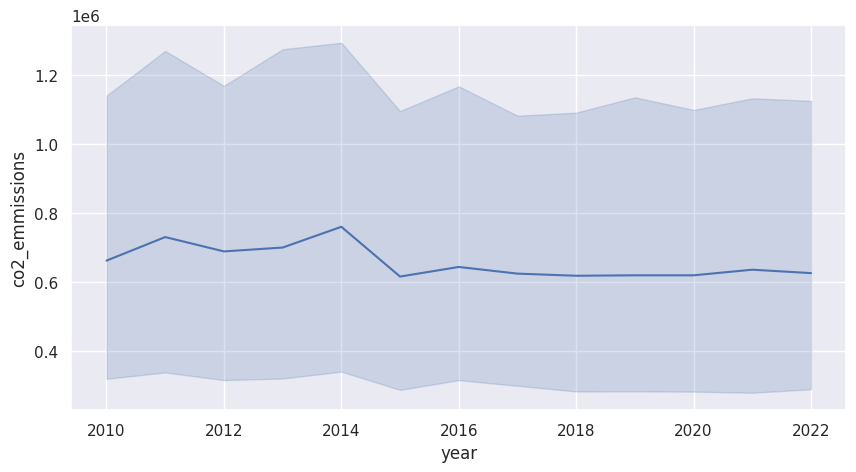

In [147]:
sns.lineplot(data=countries_df,x='year',y='co2_emmissions')

<AxesSubplot:xlabel='year', ylabel='gdp_usd_mil'>

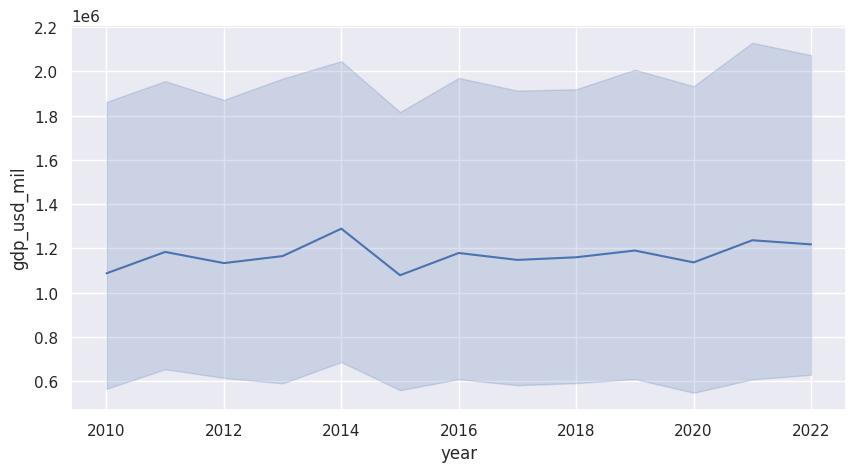

In [148]:
sns.lineplot(data=countries_df,x='year',y='gdp_usd_mil')

<AxesSubplot:xlabel='year', ylabel='gdp_per_capita'>

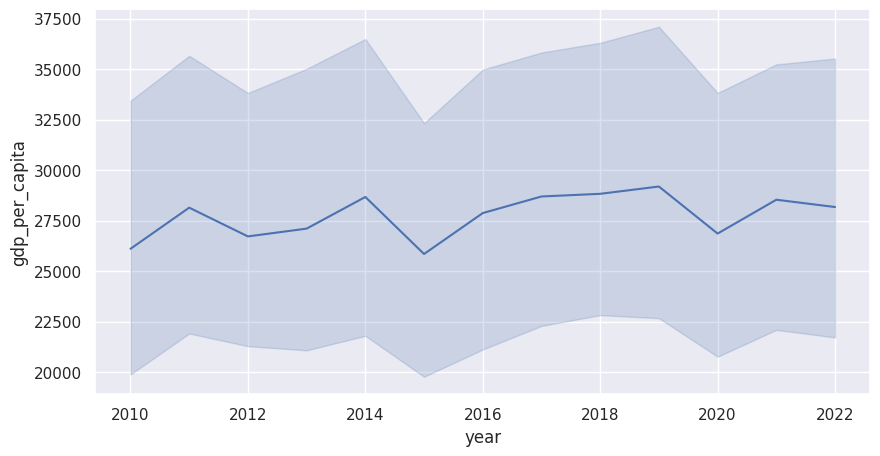

In [149]:
sns.lineplot(data=countries_df,x='year',y='gdp_per_capita')

<AxesSubplot:xlabel='gdp_growth', ylabel='Count'>

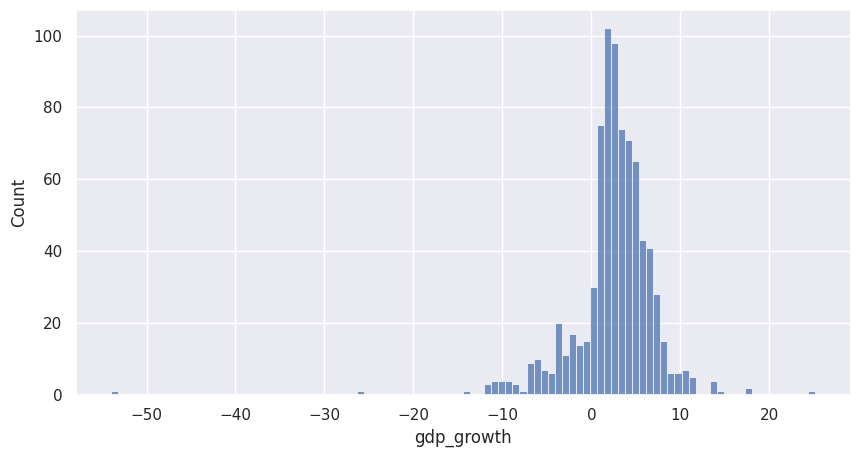

In [150]:
sns.histplot(data=countries_df,x='gdp_growth')

<AxesSubplot:xlabel='year', ylabel='gdp_growth'>

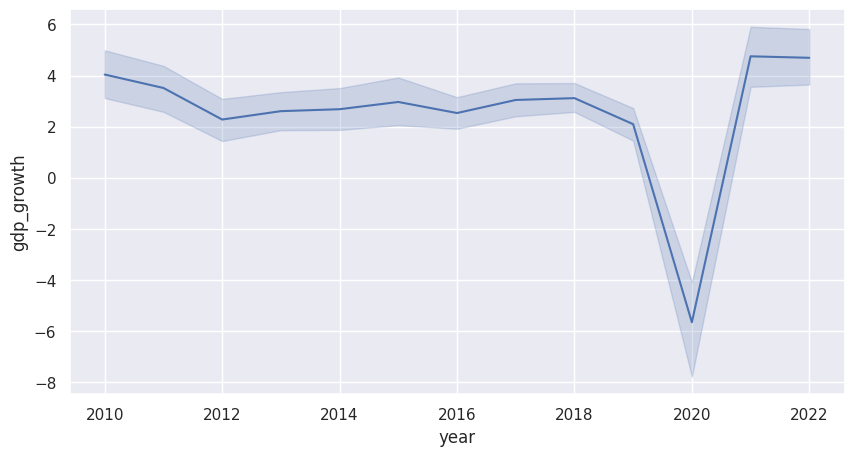

In [151]:
sns.lineplot(data=countries_df,x='year',y='gdp_growth')

<AxesSubplot:xlabel='year', ylabel='billionaires_per_mil_population'>

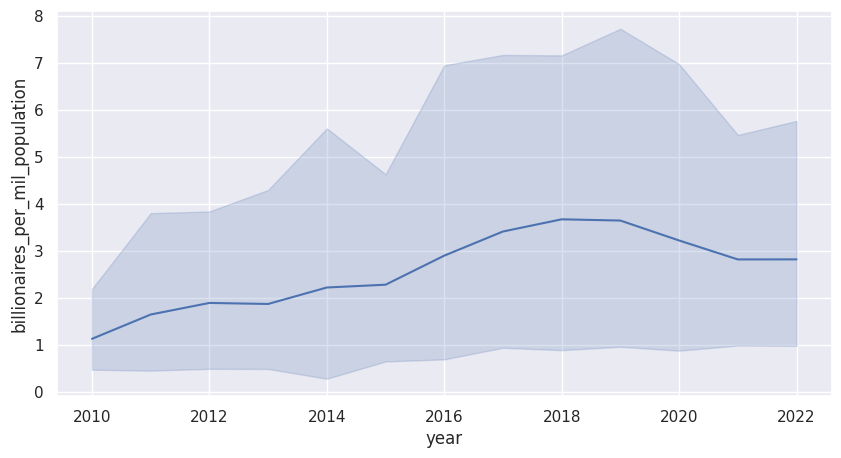

In [152]:
sns.lineplot(data=countries_df,x='year',y='billionaires_per_mil_population')

## observations
<font size = 4>
    <br>
    1) co2 emmissions are overall stable, over time among countries that have billionaires across.<br>
    2) overall gdp of the countries that have billionaires is increasing.<br>
    3) overall gdp per capita of the countries that have billionaires is also increasing.<br>
    4) gdp growth is mostly positive for countries with billionaires, except for 2019 and 2020.<br>
    5) on an avarage, billionaires per million of the population are also rising. it means that they are more billionaires per million people in 2022 than in 2010. <br>

In [153]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             856 non-null    float64
 1   billionaires                     856 non-null    int64  
 2   country                          855 non-null    object 
 3   net_worth                        856 non-null    float64
 4   country_population               812 non-null    float64
 5   urban_population                 812 non-null    float64
 6   gdp_usd_mil                      792 non-null    float64
 7   gdp_growth                       805 non-null    float64
 8   gdp_per_capita                   792 non-null    float64
 9   trade_percent_gdp                774 non-null    float64
 10  co2_emmissions                   778 non-null    float64
 11  billionaires_per_mil_population  812 non-null    float64
dtypes: float64(10), int64(

In [154]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

final_df = countries_df.copy()

In [155]:
final_df.dropna(inplace=True)

In [156]:
col = [i for i in final_df.columns if i not in ['billionaires','country','net_worth','billionaires_per_mil_population']]

In [157]:
col[:15]

['year',
 'country_population',
 'urban_population',
 'gdp_usd_mil',
 'gdp_growth',
 'gdp_per_capita',
 'trade_percent_gdp',
 'co2_emmissions']

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [159]:
X = final_df[col]
y = final_df['billionaires']

In [160]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

In [161]:
X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(np.array(y).reshape(-1,1))

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
for model in [LinearRegression(),svm.SVR(),DecisionTreeRegressor(),RandomForestRegressor()]:
    print(model)
    model.fit(X_train,y_train)
    print(model.score(X_test,y_test),'\n\n')
    

LinearRegression()
0.5816574363564567 


SVR()
0.7135379110387905 


DecisionTreeRegressor()
0.8602152714769029 


RandomForestRegressor()


/home/heramb96/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_254242/67204696.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


0.8069263524449767 




In [164]:
param_grid = {'C': [0.1, 0.5, 1,5, 10, 50, 100, 500, 1000], 'gamma': [1,0.5 ,0.1, 0.05,0.01, 0.005, 0.001,0.0005, 0.0001], 'kernel': ['rbf']} 

grid = GridSearchCV(svm.SVR(),param_grid,refit=True,verbose=3)
grid.fit(X_train,np.ravel(y_train))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.153 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.036 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.229 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.061 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.067 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.216 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.086 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.315 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.110 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.5, kernel=rbf;, score=0.110 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.361 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

[CV 5/5] END .....C=1, gamma=0.0005, kernel=rbf;, score=0.315 total time=   0.0s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.106 total time=   0.0s
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.054 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.171 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.086 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.105 total time=   0.0s
[CV 1/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.946 total time=   0.0s
[CV 2/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 3/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.885 total time=   0.0s
[CV 4/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.934 total time=   0.0s
[CV 5/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.932 total time=   0.0s
[CV 1/5] END ........C=5, gamma=0.5, kernel=rbf;, score=0.956 total time=   0.0s
[CV 2/5] END ........C=5, ga

[CV 3/5] END .......C=50, gamma=0.1, kernel=rbf;, score=0.942 total time=   0.0s
[CV 4/5] END .......C=50, gamma=0.1, kernel=rbf;, score=0.957 total time=   0.0s
[CV 5/5] END .......C=50, gamma=0.1, kernel=rbf;, score=0.974 total time=   0.0s
[CV 1/5] END ......C=50, gamma=0.05, kernel=rbf;, score=0.957 total time=   0.0s
[CV 2/5] END ......C=50, gamma=0.05, kernel=rbf;, score=0.973 total time=   0.0s
[CV 3/5] END ......C=50, gamma=0.05, kernel=rbf;, score=0.948 total time=   0.0s
[CV 4/5] END ......C=50, gamma=0.05, kernel=rbf;, score=0.971 total time=   0.0s
[CV 5/5] END ......C=50, gamma=0.05, kernel=rbf;, score=0.976 total time=   0.0s
[CV 1/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.941 total time=   0.0s
[CV 2/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.981 total time=   0.0s
[CV 3/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.927 total time=   0.0s
[CV 4/5] END ......C=50, gamma=0.01, kernel=rbf;, score=0.982 total time=   0.0s
[CV 5/5] END ......C=50, gam

[CV 2/5] END ....C=500, gamma=0.005, kernel=rbf;, score=0.982 total time=   0.1s
[CV 3/5] END ....C=500, gamma=0.005, kernel=rbf;, score=0.929 total time=   0.1s
[CV 4/5] END ....C=500, gamma=0.005, kernel=rbf;, score=0.971 total time=   0.0s
[CV 5/5] END ....C=500, gamma=0.005, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END ....C=500, gamma=0.001, kernel=rbf;, score=0.927 total time=   0.0s
[CV 2/5] END ....C=500, gamma=0.001, kernel=rbf;, score=0.980 total time=   0.0s
[CV 3/5] END ....C=500, gamma=0.001, kernel=rbf;, score=0.915 total time=   0.0s
[CV 4/5] END ....C=500, gamma=0.001, kernel=rbf;, score=0.980 total time=   0.0s
[CV 5/5] END ....C=500, gamma=0.001, kernel=rbf;, score=0.965 total time=   0.0s
[CV 1/5] END ...C=500, gamma=0.0005, kernel=rbf;, score=0.911 total time=   0.0s
[CV 2/5] END ...C=500, gamma=0.0005, kernel=rbf;, score=0.972 total time=   0.0s
[CV 3/5] END ...C=500, gamma=0.0005, kernel=rbf;, score=0.872 total time=   0.0s
[CV 4/5] END ...C=500, gamma

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
                         'gamma': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001,
                                   0.0005, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [165]:
grid.score(X_test,np.ravel(y_test))

0.7457568471928606

In [166]:
regression = RandomForestRegressor()
regression.fit(X_train,y_train)
regression.score(X_test,y_test)

/tmp/ipykernel_254242/777810036.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regression.fit(X_train,y_train)


0.8212296297099047

In [167]:
len(X_train),len(X_test)

(591, 148)

In [168]:
final_df[col].head()

year  country_population  urban_population  gdp_usd_mil  gdp_growth  \
1  2015.0          39728020.0        28146508.0    165979.28         3.7   
2  2016.0          40551398.0        28977623.0    171290.62         3.2   
3  2017.0          41389174.0        29821728.0    173517.39         1.3   
4  2018.0          42228415.0        30670076.0    175426.09         1.1   
5  2019.0          43053054.0        31510100.0    177180.35         1.0   

   gdp_per_capita  trade_percent_gdp  co2_emmissions  
1         4177.89              59.70       263140.01  
2         4224.04              55.93       265359.99  
3         4192.34              55.32       268899.99  
4         4154.22              58.07       278030.00  
5         4115.40              51.84       282010.01

## Observations :

<font size = 4>
    <br>
    1) with Random Forest Regressor we can get nearly 80 % accuracy over the ML model <br><br>
    2) we have purposefully taken out the countries, number of billionaires and net_worth of the billionaires as it may affect the ML model as there are countries like US, China etc. which create more billionaires and the rest of the world, therefore if we just have the ML model the name of the country, it will be quite easy to predict the number of billionaires.

In [169]:
countries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             856 non-null    float64
 1   billionaires                     856 non-null    int64  
 2   country                          855 non-null    object 
 3   net_worth                        856 non-null    float64
 4   country_population               812 non-null    float64
 5   urban_population                 812 non-null    float64
 6   gdp_usd_mil                      792 non-null    float64
 7   gdp_growth                       805 non-null    float64
 8   gdp_per_capita                   792 non-null    float64
 9   trade_percent_gdp                774 non-null    float64
 10  co2_emmissions                   778 non-null    float64
 11  billionaires_per_mil_population  812 non-null    float64
dtypes: float64(10), int64(

In [170]:
countries_df.to_csv('datasets/countries_with_billionaires.csv')

In [171]:
df.to_csv('datasets/forbes_billionaires_list.csv')

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23110 entries, 0 to 23109
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         23110 non-null  float64
 1   rank         23110 non-null  float64
 2   name         23110 non-null  object 
 3   citizenship  23110 non-null  object 
 4   age          22418 non-null  float64
 5   net_worth    23110 non-null  float64
 6   residence    1011 non-null   object 
 7   source       22099 non-null  object 
 8   category     5423 non-null   object 
 9   continents   23099 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1.8+ MB
